# Objective

Implement a neural network.


### Function implementations


* sigmoid
* softmax
* cross entropy log loss (binary and categorical)

### Layer implementations


* Standardization
* Matmul
* Activation (sigmoid, softmax)
* Log loss output
* Batch normalization (TBD)

Mathjax formulas get corrupted in github.

### Classifier Implementations

* Binary classifiation with (matmul-loss) layers.
* Categorical classifiation with (matmul-ReLu-matmul-Relu-loss) layers.

# References

* [CS231n: Convolutional Neural Networks for Visual Recognition 2017](http://cs231n.stanford.edu/2017/syllabus)
    - [cs231n 2017 assignment #1 kNN, SVM, SoftMax, two-layer network](https://cs231n.github.io/assignments2017/assignment1/)
    - [Training a Softmax Linear Classifier](https://cs231n.github.io/neural-networks-case-study)
* [ゼロから作る Deep Learning](https://github.com/oreilly-japan/deep-learning-from-scratch)
* [Mathematics for Machine Learning](https://mml-book.github.io/)

---

# Neural network overview

Structure of the network and how forward and backward propagations work.

<img src="image/nn_diagram.png" align="left">

# Concepts 

## Objective function

The network trains the layers so as to minimize the objective function ```L``` which calculates the loss. Each layer at ```i``` is a function $f_i$ which takes an input $X_i$ from a previous layer and outputs $Y_i = f(X_i)$. The post layers of the form an objective function $L_i$ for the layer: $L = L_i(Y_i)$. 


<img src="image/nn_functions.png" align="left">

## Forward path

The process where each layer ```i``` calculate its output $Y_i = f(X_i)$ and forward it to the next layer(s) as their input $X_{i+1}$.

## Backward path

The process of automatic differentication, or *back-propagation* where each layer calculates its gradient $\frac {\partial L_i(Y_i)}{\partial Y_i}$ , that is, the impact $Y_i$ will make on the objective ```L``` when it changes. With the gradient, we can apply the gradient descent $X_i = X_i - \lambda  \frac {\partial L_i(Y_i)}{\partial Y_i} \frac {\partial Y_i }{\partial X_i}$ to update $X_i$ that would reduce the objective ```L```.

## Cycle

A round-trip of a forward path and a backward path with a batch data set $(X, T)$. How many cycles to happen with each batch is an implementation decision. 

## Epoch

Total cycles to consume the entire training data.

---

# Terminologies

## X
A batch input to a layer. Matrix shape is ```(N, D)```.

* ```N``` : Number of rows in a batch X, or batch size
* ```D``` : Number of features in a data in X.


## T
Labels for X. There are two formats available for the label.

#### One Hot Encoding (OHE) labels

When a neural network predicts a class out of ```3``` classes for an input ```x``` and the correct class is ```2```, then the label ```t``` is specified as ```t = [0, 1, 0]```.

$
\begin{align*}
\overset{ (N,M) }{ T_{_{OHE}} } &= ( 
    \overset{ (M,) }{ T_{(n=0)} }, \dots , \overset{ (M,) }{ T_{(n=N-1)} } 
) 
\\
\overset{ (M,) }{ T_{ _{OHE} (n)} } &= ( \overset{ () }{ t_{(n)(m=0)} }, \; \dots \;, \overset{ () }{ t_{(n)(m=M-1)} })
\end{align*}
$

#### Index labels

The label ```t``` is specified as ```t = 2```. 

$
\begin{align*}
\overset{ (N,) }{ T_{_{IDX}} } &= (\overset{ () }{ t_{(n=0)} }, \; \dots \;, \overset{ () }{ t_{(n=N-1)} }) \end{align*}
$

## W
A set of weight parameters of a node in a Matmul layer. Shape is ```(M, D)```.

* ```M``` : Number of nodes in a layer



# Matrix order

Use the row-order matrix. For instance, the weight matrix ```W``` of a Matmul layer has a shape ```(M, D)``` where each row in ```W``` represents a node in the layer. It will be efficient to use the column order matrix of shape ```(D, M)``` for ```W``` so that the matrix multiplication at a Matmul layer can be executed as ```X@W```  which is a ```shape:(N,D) @ shape:(D,M)``` operation without transpose. 

However, for the purpose of consistency and clarity, use the shape ```W:(M, D)``` although it will cause transposes ```W.T``` at the Matmul operations, and revese transposing ```dL/dW.T``` to ```dL/dW``` when updating ```W``` at the gradient descents.


---

# Python & Jupyter setups

In [1]:
from typing import (
    Optional,
    Union,
    List,
    Dict,
    Tuple,
    Callable
)

### Python path
Python path setup to avoid the relative imports.

In [2]:
import sys
import os 

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

### Package dependencies

In [3]:
import inspect
from functools import partial
import copy
import logging
import numpy as np
import matplotlib.pyplot as plt

### Jupyter notebook

In [4]:
#!conda install line_profile memory_profiler
%load_ext memory_profiler
%load_ext line_profiler

# Logging is enabled by calling logging.basicConfig
# logging.basicConfig(stream=sys.stdout, level=logging.ERROR)
# Logger = logging.getLogger("neural_network")

%load_ext autoreload
%autoreload 2

### Matplotlib

In [5]:
import matplotlib.style as mplstyle
mplstyle.use('fast')
plt.ion()

# Note: with notebook backend from the top, updating the plot line does not work...
%matplotlib notebook
# %matplotlib inline

### numpy

In [6]:
np.set_printoptions(threshold=sys.maxsize)
np.set_printoptions(linewidth=80) 

---

---

# Normalization Layer
Apply normalization or use batch normaliation.

---

# Matmul layer

In [7]:
from common import (
    xavier,
    he,
    uniform
)
from layer.matmul import Matmul

## Forward path
$
\begin{align*}
\overset{ (N,M) }{ Y } 
&= 
\begin{bmatrix}
{ Y_{(n=0)} } \\
\vdots \\
{ Y_{(n)} } \\
\vdots \\
{ Y_{(n=N-1)} }
\end{bmatrix}
=
\overset{ (N,D) }{ X } \; @ \; \overset{ (D,M) }{ W^T }
\\
\\
\overset{ (M,) }{ Y_{(n)} } &= (y_{(n)(m=0)}, \; \dots, \; y_{(n)(m)},  \; \dots, \; y_{(n)(m=M-1)})
\\
\overset{ () }{ y_{(n)(m)} }
&= \overset{ (D,) }{ X_{(n)} } \cdot \overset{ (D,) }{ W_{(m)}^T }
= \sum\limits ^{D}_{d=0}  \overset{ () }{ x_{(n)(d)} } * \overset{ () }{ w_{(m)(d)} }
\\
_{(0 \le d \le D, \; 0 \le n \lt N, \; 0 \le m \lt M)}
\end{align*}
$

## Backward path
### Gradient dL/dX

Impact on L by $dX$.

$
\begin{align*}
\overset { (N,D) }{ \frac {\partial L }{ \partial X } }
= \overset { (N,M) }{ \frac {\partial L}{\partial Y} }
@ \overset { (M,D) }{ W } 
\end{align*}
$
<img src="image/nn_back_propagation_dL_dX.png" align="left" />

### Gradient dL/dW.T
Impact on L by $dW^T$.

$
\begin{align*}
\overset { (N,M) }{ \frac {\partial L }{ \partial W^T } }
= \overset { (D,N) }{ X^T } 
@ 
\overset { (N,M) }{ \frac {\partial L}{\partial Y} }
\end{align*}
$

<img src="image/nn_back_propagation_dL_dWT.png" align="left" />

---

# Batch Normalization Layer

* [Understanding the backward pass through Batch Normalization Layer](http://kratzert.github.io/2016/02/12/understanding-the-gradient-flow-through-the-batch-normalization-layer.html)
<img src="image/bn_back_propagation.png" align="left" />
<img src="image/batch_normalization_steps_small.jpg" align="left" />

---

# Activation layer

## Forward path
$
\begin{align*}
\overset{ (N,M) }{ A } &= 
activation \left( 
    \overset{ (N,M) }{ Y }  = 
    \begin{bmatrix}
    { Y_{(n=0)} } \\
    \vdots \\
    { Y_{(n)} } \\
    \vdots \\
    { Y_{(n=N-1)} }
    \end{bmatrix}
\right)
\\
\overset{ (M,) }{ A_{(n)} } 
&= activation \left( \overset{ (M,) }{ Y_{(n) }} \right)  \\
&= (a_{(n)(m=0)}, \; \dots, \; a_{(n)(m)},  \; \dots, \; a_{(n)(m=M-1)})
\\
\overset{ () }{ a_{(n)(m)} } &= activation \left( \overset{ () }{ y_{(n)(m)} } \right)
\quad _{(0 \le n \lt N, \; 0 \le m \lt M)}
\end{align*}
$

## Backward path
### Gradient dL/dY

Impact on L by dY from the matmul layer.

$
\begin {align*}
\overset { (N,M) }{ \frac {\partial L }{ \partial Y } }
= \overset { (N,M) }{ \frac {\partial L}{\partial A} } 
* 
\overset { (N,M) }{ \frac {\partial A}{\partial Y} }
\end {align*}
$

#### For sigmoid activation

$
\begin{align*}
\overset {(N,M)}{\frac { \partial L }{ \partial Y} }
&= \frac { \partial A }{ \partial Y} * A * (1 - A)
\\
\frac { \partial y_{(n)(m)} } { \partial a_{(n)(m)} }
&= a_{(n)(m)} * (1 - a_{(n)(m)} )  \\ 
y_{(n)(m)} = sigmoid(a_{(n)(m)} )&=  \frac {1}{ 1 + exp(y_{(n)(m)})}
\end{align*}
$

#### For ReLU activation

$
\begin{align*}
\frac { \partial a_{(n)(m)} }{ \partial y_{(n)(m)} }
&= 1 \quad y_{(n)(m)}  \gt 0 \\
&= 0 \quad y_{(n)(m)}  \le 0 \\
\end{align*}
$

---

# Softmax layer
$C_n$ is to prevent the overflow at $np.exp()$.

<img src="image/softmax.png" align="left" width=400/>

exp(x) can take all x values and produces a positive, which is required for log(y) that needs y > 0, hence fit-for-purpose to build a probability function.

<img src="image/exp.gif" align="left" width=250/>

Softmax and Cross Entropy Log Loss are combined as the gradient results in a simple form $P - T$.

In [8]:
from layer import CrossEntropyLogLoss
from common import softmax

lines = inspect.getsource(softmax)
print(lines)

def softmax(X: np.ndarray, out=None) -> np.ndarray:
    """Softmax P = exp(X) / sum(exp(X))
    Args:
        X: batch input data of shape (N,M).
            N: Batch size
            M: Number of nodes
        out: A location into which the result is stored
    Returns:
        P: Probability of shape (N,M)
    """
    name = "softmax"
    assert isinstance(X, float) or (isinstance(X, np.ndarray) and X.dtype == TYPE_FLOAT), \
        "X must be float or ndarray(dtype=TYPE_FLOAT)"

    # --------------------------------------------------------------------------------
    # exp(x-c) to prevent the infinite exp(x) for a large value x, with c = max(x).
    # keepdims=True to be able to broadcast.
    # --------------------------------------------------------------------------------
    C = np.max(X, axis=-1, keepdims=True)
    exp = np.exp(X - C)
    P = np.divide(exp, np.sum(exp, axis=-1, keepdims=True), out=out)
    Logger.debug("%s: X %s exp %s P %s", name, X, exp, P)

    return P



## Foward path
$
\begin{align*}
\overset{ (N,1) }{ C } &= np.max\left( 
    \overset{ (N,M) }{ A }, \; axis=-1,  \; keepdim=True 
\right) \\
&=  
\begin{bmatrix}
    \begin{bmatrix} \overset{ () }{ c_{(n=0  )} } \end{bmatrix} \\
    \begin{bmatrix} \overset{ () }{ c_{(n    )} } \end{bmatrix} \\
    \begin{bmatrix} \overset{ () }{ c_{(n=N-1)} } \end{bmatrix}
\end{bmatrix} 
\\
\overset{ (N,M) }{ EXP } &= np.exp \left( \overset{ (N,M) }{ A } - \overset{ (N,1) }{ C } \right)
= np.exp \left(
    \begin{bmatrix}
    { A_{(n=0)} } - { C_{(n=0)} }\\
    \vdots \\
    { A_{(n)} }   - { C_{(n)} }\\
    \vdots \\
    { A_{(n=N-1)} } - { C_{(n=N-1)} }\\
    \end{bmatrix}
\right) 
\\
&= 
\begin{bmatrix}
    e_{(n=0)(m=0)}   & \dots      & e_{(n=0)(m=M-1)}   \\  
    \vdots           & e_{(n)(m)} & \vdots             \\
    e_{(n=N-1)(m=0)} & \dots      & e_{(n=N-1)(m=M-1)} 
\end{bmatrix} 
\\
\\
\overset{ (N,1) }{ S } &= \overset{ (N,1) }{ sum(EXP) } = np.sum \left( 
    \overset{ (N,M) }{ EXP }, \; axis=-1,  \; keepdim=True 
\right)
\\
&= 
\begin{bmatrix}
    \begin{bmatrix} \overset{ () }{ s_{(n=0  )} } \end{bmatrix} \\
    \begin{bmatrix} \overset{ () }{ s_{(n    )} } \end{bmatrix} \\
    \begin{bmatrix} \overset{ () }{ s_{(n=N-1)} } \end{bmatrix}
\end{bmatrix} 
\\
\overset{ () }{ s_{(n)} } &= \sum\limits ^{M-1}_{m=0} np.exp(\; a_{(n)(m)} - c_{(n)} \; )
\\
\\
\overset{ (N,M) }{ P } &= \overset{ (N,M) }{ EXP }  \;\; / \;\; \overset{ (N,1) }{ sum(EXP) } 
\\
\overset{ (N,) }{ P_{(n)} } &= (p_{(n)(m=0)}, \; \dots, \; p_{(n)(m)} , \; \dots, \; p_{(n)(m=M-1)})
\\
{ p_{(n)(m)} } 
&= \frac {np.exp \left( 
    { a_{(n)(m) } } - { c_{(n)} }) \right) 
}
{  
np.sum \left( 
    np.exp \left( 
        a_{(n)(m) } - c_{(n)}
    \right)
\right) 
}
\end{align*}
$

## Backward path

### Gradient dL/dA

Impact on L by dA from the activation layer.

$
\begin{align*}
\overset { (N,M) }{ \frac {\partial L }{\partial A} }
= \overset { (N,M) }{ \frac {\partial L}{\partial P} }
* 
\overset { (N,M) }{ \frac {\partial P }{\partial A} } 
= 
\frac {1}{N} (P - T)
\end{align*}
$

$
Jacobian \; : \; f \circ g \rightarrow Jf \circ Jg
\\
\begin{align*}
\\
L &= f(\; p_{(n)(m=0)} \;) = f( \; g(\;  a_{(n)(m=0)} \; ) \; ) \quad : p = g(a) = softmax(a)
\\
\frac {\partial L} { \partial a_{(n)(m=0)} }
&= Jf(p) \circ Jg(a) 
=  \frac {\partial L} { \partial p_{(n)(m=0)} } * \frac {\partial  p_{(n)(m=0)}} { \partial a_{(n)(m=0)} }
\\
&= \frac {1}{N} \left(
 p_{(n)(m=0)} -t_{(n)(m=0)}
\right)
\end{align*}
$

The formula is calculated by chaing the gradient from ***cross-entropy-log-loss***, and the gradients of the steps in ***softmax***.

#### Gradient from the cross entropy log loss

$
\begin{align*}
\frac { \partial L }{ \partial  p_{(n)(m=0)} }
&= \frac{-1}{N} t_{(n)(m=0)} * \frac {s_{(n)}}{e_{(n)(m=0)}}
\\
\frac { \partial L }{ \partial  p_{(n)(m=1)} } 
&= \frac{-1}{N} t_{(n)(m=1)} * \frac {s_{(n)}}{e_{(n)(m=1)}}
\end{align*}
$


####  Gradient $\frac { \partial  L } { \partial s^{-1}_{(n)} } $

$
\begin{align*}
p_{(n)(m=0)} &= \frac {e_{(n)(m=0)} }{ s_{(n)} } \\
p_{(n)(m=0)} &= f \circ g_{(m=0)} = { s^{-1}_{(n)} } \; * \; { e_{(n)(m=0)} }
\rightarrow \frac { \partial  p_{(n)(m=0)} } { \partial s^{-1}_{(n)} } = e_{(n)(m=0)}
\\
p_{(n)(m=1)} &= \frac {e_{(n)(m=1)} }{ s_{(n)} } \\
p_{(n)(m=1)} &= f \circ g_{(m=1)} = { s^{-1}_{(n)} } \; * \; { e_{(n)(m=1)} }
\rightarrow \frac { \partial  p_{(n)(m=1)} } { \partial s^{-1}_{(n)} } = e_{(n)(m=1)}
\\
\frac { \partial  L } { \partial s^{-1}_{(n)} } 
&=
\left[
    \frac { \partial  p_{(n)(m=0)} } { \partial s^{-1}_{(n)} } * 
    \frac { \partial L }{ \partial  p_{(n)(m=0)} } 
    +
    \frac { \partial  p_{(n)(m=1)} } { \partial s^{-1}_{(n)} } * 
    \frac { \partial L }{ \partial  p_{(n)(m=1)} } 
\right]
\\
&= \sum\limits^{M-1}_{m=0} 
    e_{(n)(m)}  * \frac { \partial L }{ \partial  p_{(n)(m)} } 
\\
\\
\frac { \partial  L } { \partial s^{-1}_{(n)} } 
&=
    \begin{bmatrix}
    e_{(n)(m=0)}  * \frac { \partial L }{ \partial  p_{(n)(m=0)} } \\
    + \\
    e_{(n)(m=1)}  * \frac { \partial L }{ \partial  p_{(n)(m=1)} } 
    \end{bmatrix}
\\
&= -s_{(n)}(\; t_{(n)(m=0)} + t_{(n)(m=1)} \;) \\
&= -s_{(n)}
\\
\frac { \partial  L } { \partial s^{-1}_{(n)} } 
&=
\left[
    e_{(n)(m=0)}  * \frac { \partial L }{ \partial  p_{(n)(m=0)} } 
    + 
    e_{(n)(m=1)}  * \frac { \partial L }{ \partial  p_{(n)(m=1)} } 
\right]
\end{align*}
$

#### Gradient $\frac {\partial L }{ \partial { s_{(n)} } } $

$
\begin{align*}
\frac {1} { s_{(n)} } &= s^{-1}_{(n)} \rightarrow
\frac { \partial { s^{-1}_{(n)} } } {\partial s_{(n)}} = \frac {-1}{s^{2}_{(n)}}
\\
\frac {\partial L }{ \partial { s_{(n)} } } 
&=
\frac {-1}{s^{2}_{(n)}} * 
\frac {\partial L}{ \partial s^{-1}_{(n)} } \\
&= \frac {1}{s_n}
\end{align*} \\
$



#### Gradient $\frac {\partial L}{ \partial e_{(n)(m=0)} } $
$
\begin{align*}
s_{(n)} &= \sum\limits ^{M-1}_{m=0} e_{(n)(m)} \rightarrow 
\frac { \partial { s_{(n)} } } {\partial e_{(n)(m=0)}} = 1
\\
p_{(n)(m=0)} &= \frac {e_{(n)(m=0)} }{ s_{(n)} }\rightarrow 
\frac { \partial { p_{(n)(m=0)} } } {\partial e_{(n)(m=0)}} = \frac {1}{s_{(n)}}
\\
\frac {\partial L}{ \partial e_{(n)(m=0)} } 
&= \begin{bmatrix}  
    \frac { \partial { s_{(n)} } } {\partial e_{(n)(m=0)}} *  
    \frac {\partial L }{ \partial { s_{(n)} } } \\
    + \\
    \frac { \partial { p_{(n)(m=0)} } } {\partial e_{(n)(m=0)}} * 
    \frac {\partial L }{ \partial p_{(n)(m=0)} } 
\end{bmatrix}
= \begin{bmatrix}  
    \frac {\partial L }{ \partial { s_{(n)} } } \\
    + \\
    \frac {1}{s_{(n)}} * 
    \frac {\partial L }{ \partial p_{(n)(m=0)} } 
\end{bmatrix}
\\
\frac {\partial L}{ \partial e_{(n)(m=0)} } &= 
\left[
    \frac {1}{s_{(n)}} * 
    \frac {\partial L }{ \partial p_{(n)(m=0)} } 
    + 
    \frac {\partial L }{ \partial { s_{(n)} } } 
\right]
\\
\frac {\partial L}{ \partial e_{(n)(m=0)} } &= 
\begin{bmatrix}  
    \frac {1}{s_{(n)}} * 
    \frac {\partial L }{ \partial p_{(n)(m=0)} }  \\
    +  \\
    \frac {\partial L }{ \partial s_{(n)} } 
\end{bmatrix} \\
&= \frac {-t_{(n)(m=0)}}{e_{(n)(m=0)} } + \frac {1}{s_{n}}
\end{align*}
$



#### Gardient $\frac {\partial L}{ \partial a_{(n)(m=0)} } $

$
\begin{align*}
e_{(n)(m)} &= exp(\; a_{(n)(m)} \; ) \rightarrow \frac { \partial e_{(n)(m)} }{ \partial a_{(n)(m)} } = e_{(n)(m)} 
\\
e_{(n)(m=0)} &= exp(a_{(n)(m=0)}) \rightarrow \frac { \partial e_{(n)(m=0)} }{ \partial a_{(n)(m=0)} } = e_{(n)(m=0)} 
\\
e_{(n)(m=1)} &= exp(a_{(n)(m=1)}) \\
\frac {\partial L}{ \partial a_{(n)(m=0)} } 
&=   \frac { \partial e_{(n)(m=0)} }{ \partial a_{(n)(m=0)} } * 
    \frac { \partial L }{ \partial e_{(n)(m=0)} } 
= e_{(n)(m=0)} * \frac { \partial L }{ \partial e_{(n)(m=0)} } 
\\
\frac {\partial L}{ \partial a_{(n)(m=0)} } 
&= e_{(n)(m=0)} * \frac { \partial L }{ \partial e_{(n)(m=0)} } \\
&= -t_{(n)(m=0)} + \frac { e_{(n)(m=0)} }{ s_{n} } \\
&= p_{(n)(m=0)} -t_{(n)(m=0)} 
\end{align*}
$

---

# Cross Entropy Log Loss

A probability distribution $P(x)$ can be represented with its entropy $E(x) = \sum\limits_{x}  \frac {p(x)}{log(p(x)} = - \sum\limits_{x} p(x) log(p(x))$. In the diagram, x: (0:dog, 1:cat, 2:fish, 3:bird) are labels and p(dog) is 0.5. When  a NN predicts an input x as a probability distribution $P(x)$, then the $E(x) = 1.75$. 

0. $p(dog)=\frac {1}{2}$
1. $p(cat)=\frac {1}{4}$
2. $p(fish)=\frac {1}{8}$
3. $p(bird)=\frac {1}{8}$

When the truth is that x is a dog, then the probability distribution of the truth $P(t)$ has the entropy $E(t) = 0$.

0. $p(dog)=1$
1. $p(cat)=0$
2. $p(fish)=0$
3. $p(bird)=0$

The difference E(x) - E(t) = E(x) = 1.75 can be used as the distance or the error of the prediction from the truth. Need to understand further but  the actuall loss function is $E(x) = -tlog(p(x)) = -log(p(x))$ where p(x) is the probability from the softmax for the correct label.


<img src="image/entropy.png" align="left" width=600/><br>

np.log() is ln based on the mathematical constant $e$ and its derivative $\frac {\partial log(x)}{\partial x} = \frac {1}{x}$.

* [Logarithm](https://en.wikipedia.org/wiki/Logarithm)


<img src="image/logarithm_plots.png" align="left" width=300/>

* [ML Grossary - Loss Functions](https://ml-cheatsheet.readthedocs.io/en/latest/loss_functions.html)

<img src="image/cross_entropy_log_loss.png" align="left" width=500/>

[cross_entropy_log_loss_input_combinations.xlsx](./common/cross_entropy_log_loss_input_combinations.xlsx)

In [9]:
from common import (
    cross_entropy_log_loss,
    OFFSET_LOG
)
lines = inspect.getsource(cross_entropy_log_loss)
print(lines)

def cross_entropy_log_loss(
        P: Union[np.ndarray, float],
        T: Union[np.ndarray, int],
        f: Callable = categorical_log_loss,
        offset: float = OFFSET_LOG
) -> np.ndarray:
    """Cross entropy log loss [ -t(n)(m) * log(p(n)(m)) ] for multi labels.
    Args:
        P: activation or probabilities from an activation function.
        T: labels
        f: Cross entropy log loss function f(P, T) where P is activation, T is label
        offset: small number to avoid np.inf by log(0) by log(0+offset)

    Returns:
        J: Loss value of shape (N,), a loss value per batch.

    NOTE:
        Handle only the label whose value is True. The reason not to use non-labels to
        calculate the loss is TBD.

        See transform_X_T for the format and shape of P and T.
    """
    name = "cross_entropy_log_loss"
    P, T = transform_X_T(P, T)
    if P.ndim == 0:
        assert False, "P.ndim needs (N,M) after transform_X_T(P, T)"
        # -----------------------------

## For label using One Hot Encoding (OHE)
For instance, if multi labels are (0,1,2,3,4) and each label is OHE, then the label for 2 is (0,0,1,0,0).   


### Product of matrix rows

There is no formal operation to calculate the dot products of the rows from two matrices, but to calculate the diagonal of the matlix multiplication that also calculate non-diagonals. To avoid calculating non-diagonals, use [einsum](https://numpy.org/doc/stable/reference/generated/numpy.einsum.html).

* [Name of matrix operation of ```[A[0] dot B[0], A[1] dot B[1] ]``` from 2x2 matrices A, B](https://math.stackexchange.com/questions/4010721/name-of-matrix-operation-of-a0-dot-b0-a1-dot-b1-from-2x2-matrices-a)

<img src="image/dot_products_of_matrix_rows.png" align="left"/>


In [10]:
import numpy as np

a = np.arange(6).reshape(2,3)
b = np.arange(0,-6,-1).reshape(2,3)
c = [
    np.inner(a[0], b[0]),
    np.inner(a[1], b[1]),    
]
print(f"a is \n{a}")
print(f"b.T is \n{b.T}\n")
fmt=f"""c[
    np.inner(a[0], b[0]),
    np.inner(a[1], b[1]),    
] is {c}\n
"""
print(fmt)

# Use einsum
e = np.einsum('ij,ji->i', a, b.T)
fmt="np.einsum('ij,ji->i', a, b.T)"
print(f"{fmt} is {e}")

a is 
[[0 1 2]
 [3 4 5]]
b.T is 
[[ 0 -3]
 [-1 -4]
 [-2 -5]]

c[
    np.inner(a[0], b[0]),
    np.inner(a[1], b[1]),    
] is [-5, -50]


np.einsum('ij,ji->i', a, b.T) is [ -5 -50]


### Foward path (OHE)
$
\text{ for one hot encoding labels }
\\
\begin{align*}
\overset{ (N,) }{ J } &= - \sum\limits^{M-1}_{m=0} 
    \left[ \; \;  
        t_{(n)(m)} \;  * \;  np.log(p_{(n)(m)}) \;\;  
    \right]
\\
\overset{ () }{ j_{(n)} } &= \overset{ (M,) }{ T_{(n)} } \cdot \overset{ (M,) }{ P_{(n)} } 
\end{align*}
$

### Gradient dL/dP

Impact on L by the $dP$ from the softmax layer for one hot encoding labels.

$
\begin{align*}
\overset { (N,M) }{ \frac { \partial L }{ \partial P} }
&= \overset { (N,) }{ \frac { \partial L }{ \partial J} } * 
\overset { (N,M) }{ 
\left(
 - \frac { \partial T } { \partial P }
 \right) 
} 
= - \frac {1}{N }  \frac { \partial T } { \partial P }
\\
\frac {\partial L }{\partial p_{(n)(m=0)}} 
&= \frac {\partial L}{\partial j_{(n)}} * \frac {\partial j_{(n)}} {\partial p_{(n)(m=0)}} 
= \frac {1}{N} \frac { -t_{(n)(m=0)}}{ p_{(n)(m=0)} } 
=  \frac {1}{N} \left(
 -t_{(n)(m=0)} * \frac { s_{(n)} }{ e_{(n)(m=0)} }
\right)
\end{align*}
$

## For label using indexing 
For instance, if the multi labels are (0,1,2,3,4) then the index is 2 for the label 2. If the labels are (2,4,6,8,9), then the index is 3 for the label 8.  

Use LP to select the probabilities from P for the corresponding labels. For instance, if the label is 2 (hence the index is 2) for X(n=0), and 4 for X(n=3), then the numpy tuple indexing selects ```P[n=0][m=2]``` and ```P[n=3][m=4] ```.

```
P[
   (0, 3),
   (2, 4)
]
```

$
\text{ for index labels e.g. (5, 2, 0, 9, ...)}
\\
\\
\overset{ (N,) }{ J } = - np.sum(\; np.log(LP), \; axis = -1 \;) \\
LP = label\_probability = P \left[ \\
\quad ( \; 0, \; \dots, \;  {N-1}) , \\
\quad ( \; t_{(n=0)} \; , \dots , \; t_{(n=N-1)}) \\
\right]
\\
\\
$

---

# Total loss

## Forward path
$
\begin{align*}
\overset{ () }{ L } = \frac {1}{N} \sum\limits^{N-1}_{n=0} \overset{ () }{ j_{{(n)}} }
\end{align*}
$

## Gardient dL/dJ

Impact on L by $dJ$ from the cross entropy log loss layer.

$
\begin{align*}
\overset { (N,) }{ \frac {\partial L}{\partial J} }  &= \frac {1}{N} \overset{(N,)}{ones}
\\
\frac {\partial L}{\partial j_{(n)} } &= \frac {1}{N} 
\end{align*}
$

In [11]:
N = 3
dJ = np.ones(N) / N
dJ

array([0.33333333, 0.33333333, 0.33333333])

---


# Gradient check

## Numerical gradient

The objective of back-propagation is to analytically calculate the gradient of the objective function $g(X_i) = \frac {\partial L_i(Y_i)}{\partial Y_i} \frac {\partial Y_i}{\partial X_i}$ at each layer. Suppose the shape of $X_i$ is ```(N, M)```. We can take an element of X at an index ```(n,m)``` and add a small change ```h```, then see what impact ```h``` makes by calculating the numerical gradient ```gn``` as: $
\begin {align*}
gn(X_i) = \frac {L_i(f_i(X_i+h)) - L_i(f_i(X_i-h))} {2h }
\end {align*}
$. Then $gn(X_i) \approx \; $gn(X_i)$ would assure the gradient calculation should be correct.

In [12]:
from common import (
    numerical_jacobian,
    OFFSET_DELTA
)
lines = inspect.getsource(numerical_jacobian)
print(lines)

def numerical_jacobian(
        f: Callable[[np.ndarray], np.ndarray],
        X: Union[np.ndarray, float],
        delta: Optional[TYPE_FLOAT] = OFFSET_DELTA
) -> np.ndarray:
    """Calculate Jacobian matrix J numerically with (f(X+h) - f(X-h)) / 2h
    Jacobian matrix element Jpq = df/dXpq, the impact on J by the
    small difference to Xpq where p is row index and q is col index of J.

    Note:
        Beware limitations by the float storage size, e.g. loss of significance.
        https://docs.oracle.com/cd/E19957-01/806-3568/ncg_goldberg.html
        https://ece.uwaterloo.ca/~dwharder/NumericalAnalysis/Contents/
        https://ece.uwaterloo.ca/~dwharder/NumericalAnalysis/02Numerics/Weaknesses/
        https://www.cise.ufl.edu/~mssz/CompOrg/CDA-arith.html

    Args:
        f: Y=f(X) where Y is a scalar or shape() array.
        X: input of shame (N, M), or (N,) or ()
        delta: small delta value to calculate the f value for X+/-h
    Returns:
        J: Jacobian matrix that 


### Consideration

#### Instability of numerical calculations

A float number can have infinite length e.g. ```1/3``` in the real world, but a computer needs to approximate it by rounding it to fit into a limited storage. Need to assure numerical errors are prevented or detected while calculating gradient numerically. See [Numerical errors](numerical_errors.ipynb). 

### Example 

Comparing the analytical gradient and the numerical gradient of a logistic log loss ```L = -(1-T) * log(Z)``` where ```T = 0``` and ```Z=sigmoid(X)```.

In [13]:
def t_0_logistic_log_loss(X):
    """Logistic log loss function"""
    # --------------------------------------------------------------------------------
    # For numerical stability, re-forumulate the logistic log loss -(1-T)log(1-Z) as
    # X + log(1+exp(-X)).
    
    # By Reza.B
    # Let z=1/(1+p), p= e^(-x), then log(1-z)=log(p)-log(1+p), which is more stable
    # in terms of rounding errors (we got rid of division, which is the main issue 
    # in numerical instabilities). 
    # --------------------------------------------------------------------------------
    L = np.sum(X + np.log(1 + np.exp(-X)))
    return L.tolist()

def gradient_t_0_loss(X):
    return 1 / (1 + np.exp(-X))

X = np.random.uniform(-5, 5, (2,2))
print(f"The analytical and numerical gradients of the logistic log loss for X:\n{X}\n")

analytical_gradient = gradient_t_0_loss(X)
numerical_gradient = numerical_jacobian(t_0_logistic_log_loss, X)

print(f"Analytical gradient:\n{analytical_gradient}\n")
print(f"Numerical gradient:\n{numerical_gradient}")

The analytical and numerical gradients of the logistic log loss for X:
[[ 2.78964315  0.64176548]
 [-2.48800383  0.12515952]]

Analytical gradient:
[[0.94211359 0.65515244]
 [0.07670345 0.5312491 ]]

Numerical gradient:
[[0.94211305 0.65515593]
 [0.07670753 0.5312506 ]]


---

# Binary classification

Use Matmul and CrossEntropyLogLoss layers to build a binary classifer.

In [14]:
%reload_ext autoreload
%autoreload 2
from common import (
    weights,
    transform_X_T,
    sigmoid_cross_entropy_log_loss,
    softmax_cross_entropy_log_loss
)
from data import (
    linear_separable
)
from optimizer import (
    Optimizer,
    SGD
)
from network import (
    train_binary_classifier
)
from drawing import (
    COLOR_LABELS,   # labels to classify outside/0/red or inside/1/green.
    plot_categorical_predictions
)

## X

Training data is two dimensional plots that can be linearly separable with a line whose normal is $(w1, w2)$ and point is $b=-w0/w2$. The line is written as $X \cdot W = 0$ where $W = (w0,w1,w2)$ and $X = (x0, x1, x2)$. $T$ are binary labels that tells if each plot is classfied as 0 or 1.

In [15]:
N = 500    # Number of plots
D = 2      # Number of features
from data import (
    linear_separable
)
X, T, V = linear_separable(d=D, n=N)
_X = np.c_[
    np.ones(N),     # Bias
    X
]
#print(f"X.shape {X.shape} T.shape {T.shape} W {V}")

### Classification goal

<IPython.core.display.Javascript object>


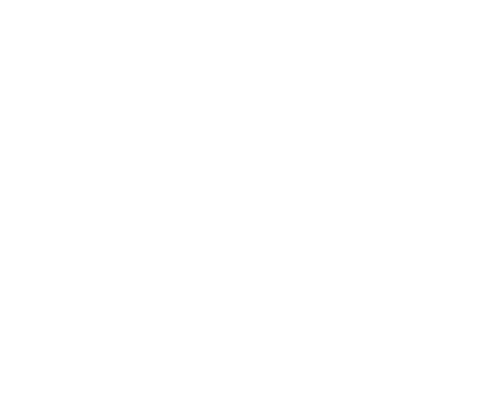

In [16]:
fig, ax = plt.subplots(figsize=(5,4))
ax.set_xlabel('x label')
ax.set_ylabel('y label')
ax.axis('equal')
ax.set_title('Linarly seprable two dimensional plots')

ax.scatter(X[T==0, 0], X[T==0, 1], c='red')
ax.scatter(X[T==1, 0], X[T==1, 1], c='green')

# Hyperplace (X-b)V = 0 -> x1V1 + x2V2 - bV2 = 0
x = np.linspace(-3,3,100)
y = -(V[1] / V[2]) * x - (V[0] / V[2])
ax.plot(x, y)
ax.set_xlim(-3, 3)
ax.set_ylim(-3, 3)
ax.grid()

## Train binary classifiers
1. Sigmoid binary classifier
2. Softmax binary classifier

In [17]:
%matplotlib notebook

def draw_training(X, W, _ax=None, _fig=None, colors=['b']):
    w0 = W[0]
    w1 = W[1]
    w2 = W[2]
    
    #_ax.set_xlim(-3, 3)
    #_ax.set_ylim(-3, 3)
    #_ax.set_title(label=f"W: {W}")

    #_ax.scatter(X[T==0, 1], X[T==0, 2], c='red')
    #_ax.scatter(X[T==1, 1], X[T==1, 2], c='green')
    x = np.linspace(-3,3,100)
    if _ax.lines:
        for line in _ax.lines:
            line.set_xdata(x)
            y = -w1/w2 * x - w0 / w2
            line.set_ydata(y)
    else:
        for color in colors:
            y = -w1/w2 * x - w0 / w2
            _ax.plot(x, y, color)

    fig.canvas.draw()

    _x = np.linspace(-3,3,100)
    _y = -w1/w2 * x - w0 / w2
    _ax.plot(_x, _y, label='linear')  # Plot some data on the _axes.


## Sigmoid classifier training


<IPython.core.display.Javascript object>


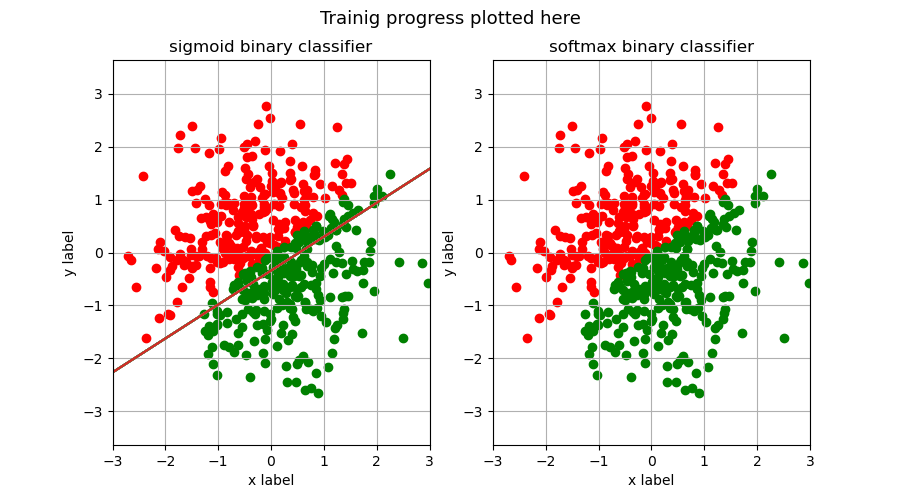

Train a sigmoid classifier to find optimal W (0.00507323563459043, 0.5901809003819253, -0.8072550818078359) for the boundary.
iteration 0 Loss 0.6481638890447898


KeyboardInterrupt: 

In [18]:
fig, ax = plt.subplots(1, 2, figsize=(9,5))
for i in range(2):
    ax[i].scatter(X[T==0, 0], X[T==0, 1], c='red')
    ax[i].scatter(X[T==1, 0], X[T==1, 1], c='green')
    ax[i].set_xlabel('x label')
    ax[i].set_ylabel('y label')
    ax[i].axis('equal')
    ax[i].set_xlim(-3, 3)
    ax[i].set_ylim(-3, 3)
    ax[i].grid()

fig.suptitle('Trainig progress plotted here', fontsize=13)
ax[0].set_title("sigmoid binary classifier")
ax[1].set_title("softmax binary classifier")




print(f"Train a sigmoid classifier to find optimal W {tuple(V)} for the boundary.")
MAX_TEST_TIMES = 50

M = 1
W = weights.xavier(M, D+1)    # Xavier initialization for Sigmoid
optimizer = SGD(lr=0.3)
draw = partial(draw_training, X=X, _fig=fig, _ax=ax[0])
ax[0].set_xlim(-3, 3)
ax[0].set_ylim(-3, 3)

train_binary_classifier(
    N=N,
    D=D,
    M=M,
    X=X,
    T=T,
    W=W,
    log_loss_function=sigmoid_cross_entropy_log_loss,
    optimizer=optimizer,
    num_epochs=MAX_TEST_TIMES,
    test_numerical_gradient=False,
    callback=draw
)

In [ ]:
%lprun \
    -T train_sigmoid_binary_classifier.log \
    -f train_binary_classifier \
    train_binary_classifier(\
        N=N,D=D,M=M,X=X,T=T,W=W,\
        log_loss_function=sigmoid_cross_entropy_log_loss, \
        optimizer=optimizer, \
        num_epochs=MAX_TEST_TIMES, \
        test_numerical_gradient=False \
    )

print(open('train_sigmoid_classifier.log', 'r').read())

## softmax classifier training
Two class classification with softmax activation. 
Plots in the previous cell.

In [ ]:
print(f"Train a softmax classifier to find optimal W {tuple(V)} for the boundary.")
MAX_TEST_TIMES = 100

M = 2                      
W = weights.he(M, D+1)
optimizer = SGD(lr=0.3)
draw = partial(draw_training, X=X, _fig=fig, _ax=ax[1])
ax[1].set_xlim(-3, 3)
ax[1].set_ylim(-3, 3)

train_binary_classifier(
    N=N,
    D=D,
    M=M,
    X=X,
    T=T,
    W=W,
    log_loss_function=softmax_cross_entropy_log_loss,
    optimizer=optimizer,
    num_epochs=MAX_TEST_TIMES,
    test_numerical_gradient=False, 
    callback=draw
)

In [ ]:
%lprun \
    -T train_softmax_binary_classifier.log \
    -f train_binary_classifier \
    train_binary_classifier(\
        N=N,D=D,M=M,X=X,T=T,W=W,\
        log_loss_function=softmax_cross_entropy_log_loss, \
        optimizer=optimizer, \
        num_epochs=MAX_TEST_TIMES, \
        test_numerical_gradient=False \
    )

print(open('train_softmax_classifier.log', 'r').read())

---

# Categorical Classification

Use Matmul and CrossEntropyLogLoss layers to classify M categorical data.

In [19]:
%reload_ext autoreload
%autoreload 2
from common import (
    prediction_grid,
)
from data import (
    linear_separable_sectors,
)
from network import (
    train_matmul_relu_classifier
)

## Linearly separable multiple categories

### Data X and Label T
Training data to linearly classify into M categories and labels T.

In [20]:
print(f"Train a categorical classifier")
N = 1000
D = 2      # Dimension
M = 3

rotation = np.radians(35)
# x0 = X[::,0] is the bias 1
X, T, B = linear_separable_sectors(n=N, d=D, m=M, r=2, rotation=rotation)
X_backup = copy.deepcopy(X)
T_backup = copy.deepcopy(T)

Train a categorical classifier


#### Plot X, T

<IPython.core.display.Javascript object>


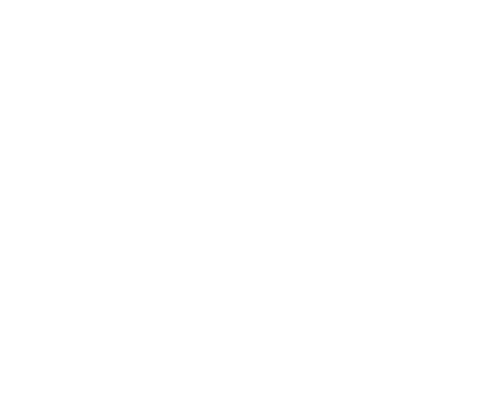

In [21]:
# Radius of a circle within which to place plots.
radius = 2   

# --------------------------------------------------------------------------------
# Plot area
# --------------------------------------------------------------------------------
fig, ax = plt.subplots(figsize=(5,4))
for i in range(2):
    ax.set_xlabel('x label')
    ax.set_ylabel('y label')
    ax.axis('equal')
    ax.set_xlim(-3, 3)
    ax.set_ylim(-3, 3)
    ax.grid()

ax.set_title(f"Categorical data of {M} classes")

# --------------------------------------------------------------------------------
# Cirle within which to place random plots.
# --------------------------------------------------------------------------------
r = np.linspace(0, 2 * np.pi, 100)
ax.plot(radius * np.cos(r), radius * np.sin(r), "b--")

# --------------------------------------------------------------------------------
# Classify plots (x, y) if inside the coverage sector
# labels to classify outside/0/red or inside/1/green.
# --------------------------------------------------------------------------------
Y = COLOR_LABELS[
    T
]

# --------------------------------------------------------------------------------
# Plot color-classified points.
# --------------------------------------------------------------------------------
ax.scatter(X[::,0], X[::,1], marker='o', color=Y)

# --------------------------------------------------------------------------------
# Plot sector bases
# --------------------------------------------------------------------------------
for i in range(B.shape[0]):
    ax.plot((0, radius * B[i, 0]), (0, radius * B[i, 1]), COLOR_LABELS[i])

# ax.legend()
fig.suptitle('Categorical classifiation data', fontsize=16)

plt.draw()
plt.show()


### Train on linearly separable multiple categories

In [22]:
MAX_TEST_TIMES = 500
W = weights.he(M, D+1)
W_backup = copy.deepcopy(W)
optimizer = SGD(lr=0.5)

# W = train_classifier(
W = train_matmul_relu_classifier(
    N=N,
    D=D,
    M=M,
    X=X,
    T=T,
    W=W,
    log_loss_function=softmax_cross_entropy_log_loss,
    optimizer=optimizer,
    num_epochs=MAX_TEST_TIMES,
    test_numerical_gradient=False
)

Expected dL/dW 
[[-0.10218159  0.05796373 -0.11349377]
 [ 0.          0.          0.        ]
 [-0.00247219 -0.16111212  0.08100672]]
Diff
[[ 0.0100598  -0.0043972   0.01018124]
 [ 0.          0.          0.        ]
 [-0.00133438  0.0076613  -0.01015743]]


iteration 0 Loss 1.0590592004899888
iteration 10 Loss 0.8063486918384951
iteration 20 Loss 0.7419612932775844
iteration 30 Loss 0.7062301653015103
iteration 40 Loss 0.6824379025180858
iteration 50 Loss 0.6650577221055576
iteration 60 Loss 0.651449452085238
iteration 70 Loss 0.6403690596592583
iteration 80 Loss 0.6311100738332798
iteration 90 Loss 0.6231982408706376
iteration 100 Loss 0.6162803025043344
iteration 110 Loss 0.6102628629711598
iteration 120 Loss 0.6049354352194768
iteration 130 Loss 0.6002145439428405
iteration 140 Loss 0.5959565034555376
iteration 150 Loss 0.5920236081040708
iteration 160 Loss 0.5884078954193742
iteration 170 Loss 0.5850786534666522
iteration 180 Loss 0.5819988122352552
iteration 190 Loss 0.5790971858768537
iteration 200 Loss 0.5763909871321818
iteration 210 Loss 0.5738686088755812
iteration 220 Loss 0.5715239631943041
iteration 230 Loss 0.5693185508207114
iteration 240 Loss 0.5672190169344993
iteration 250 Loss 0.5652273158259474
iteration 260 Loss 0.563

### Run predictions

Run preditions against the grid coordinates (x1, x2).
```
x1: X[:, 1].min() - 1 <= x1 <=  X[:, 1].max() + 1
x2: X[:, 2].min() - 1 <= x2 <=  X[:, 2].max() + 1
grid = np.meshgrid(x1, x2)

# np.argmax(scores) selets the highest score for each data point in X.
# e.g score[i] = [0.2, 8.2, 0.3], then np.argmax(scores[i]) selects index 1 as the prediction. 
# Then cluster of predition/label == 1 will form a contour.
sores = grid @ W.T
predictions = p.argmax(score, axis=1)
```

### Plot predictions

<IPython.core.display.Javascript object>


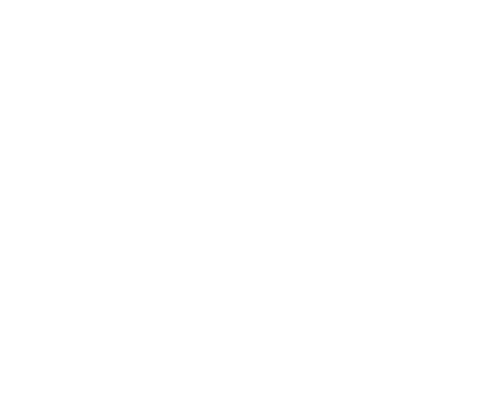

/home/oonisim/home/repository/git/oonisim/python_programs/nlp/src/drawing/functions.py:67: UserWarning: linewidths is ignored by contourf
  axes.contourf(grid[0], grid[1], predictions, cmap=plt.cm.gist_rainbow, alpha=0.4, linewidths=3.0)


In [23]:
fig, ax = plt.subplots(figsize=(5,4)) 
ax.set_xlabel('x label')
ax.set_ylabel('y label')
ax.axis('equal')
ax.grid()
ax.set_title("Predictions")
#ax.set_xlim(-3, 3)
#ax.set_ylim(-3, 3)

x_grid, y_grid, predictions = prediction_grid(X, W)
plot_categorical_predictions(ax, [x_grid, y_grid], X, Y, predictions)

plt.show()

## Batch normalization
Observe the effect of the batch normalization by inserting the layer in-between activation and matmul layers.

In [24]:
%reload_ext autoreload
%autoreload 2
from network import (
    train_matmul_bn_relu_classifier
)
from common import (
    prediction_grid_2d
)

In [25]:
MAX_TEST_TIMES = 200
np.copyto(X, X_backup)
np.copyto(W, W_backup)
optimizer = SGD(lr=0.5)

# W = train_classifier(
W, objective, prediction = train_matmul_bn_relu_classifier(
    N=N,
    D=D,
    M=M,
    X=X,
    T=T,
    W=W,
    log_loss_function=softmax_cross_entropy_log_loss,
    optimizer=optimizer,
    num_epochs=MAX_TEST_TIMES,
    test_numerical_gradient=False
)

iteration 0 Loss 1.2306061399101034
iteration 10 Loss 0.6213103633379669
iteration 20 Loss 0.6148412794693418
iteration 30 Loss 0.608779874968272
iteration 40 Loss 0.6029425183285261
iteration 50 Loss 0.5973210198724935
iteration 60 Loss 0.5919186958501125
iteration 70 Loss 0.5867264331945117
iteration 80 Loss 0.581709157461279
iteration 90 Loss 0.5768629121312668
iteration 100 Loss 0.5721594894879087
iteration 110 Loss 0.5675999086585709
iteration 120 Loss 0.5631756140536551
iteration 130 Loss 0.5588744068442181
iteration 140 Loss 0.5546850160294176
iteration 150 Loss 0.5506113823577287
iteration 160 Loss 0.5466415769053088
iteration 170 Loss 0.5427809195750514
iteration 180 Loss 0.539021833983767
iteration 190 Loss 0.5353598613409056


<IPython.core.display.Javascript object>


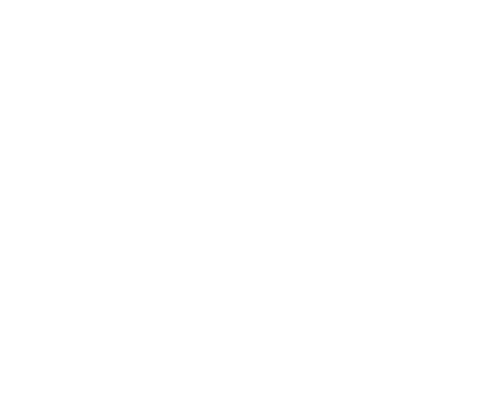

In [26]:
fig, ax = plt.subplots(figsize=(5,4)) 
x_min, x_max = X[:, 0].min(), X[:, 0].max()
y_min, y_max = X[:, 1].min(), X[:, 1].max()
Y = COLOR_LABELS[T]

x_grid, y_grid, predictions = prediction_grid_2d(x_min, x_max, y_min, y_max, prediction)
plot_categorical_predictions(ax, [x_grid, y_grid], X, Y, predictions)

ax.set_xlabel('x label')
ax.set_ylabel('y label')
ax.axis('equal')
ax.grid()

## Non-linearly separable data

In [83]:
%reload_ext autoreload
%autoreload 2

from data import (
    set_in_a_radius,
    sets_of_circle_A_not_B
)
from common import (
    prediction_grid_2d
)
from network import (
    train_two_layer_classifier
)
from drawing import (
    plot,
    scatter
)

### Data X and Label T
Training data set that cannot be linearly classified. ```X = ((A not B), (B not C), (C not A), (A and B and C and D))``` for circles A, B, C.

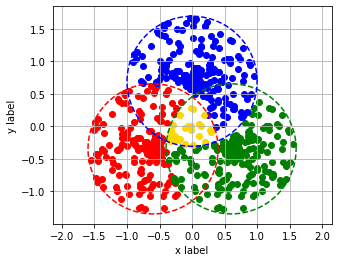

In [89]:
__M = 3        # Number of circles
__N = 250
radius = 1
circles, centres, intersection = sets_of_circle_A_not_B(radius=radius, ratio=1.2, m=__M, n=__N)

fig, ax = plt.subplots(figsize=(5,4)) 
ax.set_xlabel('x label')
ax.set_ylabel('y label')
ax.axis('equal')
ax.grid()
r = np.linspace(0, 2*np.pi, 100)

# (A not B), (B not C), (C not A)
for i in range(__M):
    circle = circles[i]
    if circle.size > 0:
        x = centres[i][0]
        y = centres[i][1]
        ax.scatter(circle[::, 0], circle[::, 1], color=COLOR_LABELS[i])
        ax.plot(
            x + radius * np.cos(r), 
            y + radius * np.sin(r), 
            linestyle='dashed', 
            color=COLOR_LABELS[i]
        )

# (A and B and C and D)
M = __M + 1
ax.scatter(intersection[::, 0], intersection[::, 1], color='gold')

In [90]:
# Stack all circles and intersect
X = np.vstack(
    [circles[i] for i in range(M-1)] + 
    [intersection]
)

T = np.hstack(
    [np.full(circles[i].shape[0], i) for i in range(M-1)] + 
    [np.full(intersection.shape[0], M-1)]
)
N = T.shape[0]
assert T.shape[0] == X.shape[0]

# Shuffle the data
indices = np.random.permutation(range(T.shape[0]))
X = X[indices]
T = T[indices]
Y = COLOR_LABELS[T]


print(f"X:{X.shape} T:{T.shape} ")

X:(608, 2) T:(608,) 


### Train on non-linear separable data

During the training, the loss often does not decrease. 

> Iteration [19976]: Loss[0.06914290965513335] has not improved from the previous [0.06914225566912098] for 1 times.

<ins>If reduce the **learning rate** at those points, the situation gets worse </ins>(continuous non-improvements instead of sporadic) and the training fails (the result model cannot classify). If keep using the same learning rate, the non-improvement continues more frequently but the training itself makes a progress. 

Need to understand why it happens and why reducing the rate will make the training fail. Possibl approach is visualizing the loss function with contour lines and the track of the gradient descent to see the terrain it went through. 

In [92]:
MAX_TEST_TIMES = 20000
D = 2
M1 = 20
W1 = weights.he(M1, D+1)
M2: int = M                 # Number of categories to classify
W2 = weights.he(M2, M1+1)
optimizer = SGD(lr=0.6)

X, T = transform_X_T(X, T)
W1, W2, objective, prediction, history = train_two_layer_classifier(
    N=N,
    D=D,
    X=X,
    T=T,
    M1=M1,
    W1=W1,
    M2=M2,
    W2=W2,
    log_loss_function=softmax_cross_entropy_log_loss,
    optimizer=optimizer,
    num_epochs=MAX_TEST_TIMES,
    test_numerical_gradient=False
)

iteration 0 Loss 1.330658143270141
iteration 100 Loss 0.21639333699440044
iteration 200 Loss 0.18983966961209311
iteration 300 Loss 0.17676391005730774
iteration 400 Loss 0.1685263060282
iteration 500 Loss 0.16220325396540455
iteration 600 Loss 0.15678332256415003
iteration 700 Loss 0.15199696662437848
iteration 800 Loss 0.1474573707318883
iteration 900 Loss 0.14311248841804738
iteration 1000 Loss 0.1389285471162465
iteration 1100 Loss 0.13496326992546115
iteration 1200 Loss 0.13131037221028374
iteration 1300 Loss 0.12793534276701043
iteration 1400 Loss 0.12471217058844439
iteration 1500 Loss 0.12167303524424901
iteration 1600 Loss 0.11883733035091286
iteration 1700 Loss 0.11613674404894044
iteration 1800 Loss 0.11358499372092772
iteration 1900 Loss 0.11117410124703322
iteration 2000 Loss 0.10858930177265308
iteration 2100 Loss 0.10594999958295612
iteration 2200 Loss 0.10371722532956003
iteration 2300 Loss 0.10168159125775642
iteration 2400 Loss 0.09990404012696413
iteration 2500 Loss 

Iteration [3843]: Loss[0.08628157615203533] has not improved from the previous [0.08628152203552258] for 1 times.


iteration 3900 Loss 0.08597620886661936


Iteration [3935]: Loss[0.08580406350935883] has not improved from the previous [0.08580344813485924] for 1 times.
Iteration [3968]: Loss[0.08563886244682357] has not improved from the previous [0.08563795560396957] for 1 times.
Iteration [3996]: Loss[0.08549963264486891] has not improved from the previous [0.0854995611875228] for 1 times.
Iteration [4005]: Loss[0.08545611517835733] has not improved from the previous [0.08545539362448083] for 1 times.


iteration 4000 Loss 0.08547517687216306


Iteration [4057]: Loss[0.08520947837075293] has not improved from the previous [0.08520778691797694] for 1 times.
Iteration [4083]: Loss[0.0850883833788816] has not improved from the previous [0.08508630736383414] for 1 times.
Iteration [4090]: Loss[0.08505501462637306] has not improved from the previous [0.08505467766059506] for 1 times.
Iteration [4103]: Loss[0.08499551746869471] has not improved from the previous [0.0849945039141123] for 1 times.
Iteration [4109]: Loss[0.08496889488565051] has not improved from the previous [0.08496679972445353] for 1 times.


iteration 4100 Loss 0.08500382262648468


Iteration [4115]: Loss[0.08494062945060454] has not improved from the previous [0.08493993978265212] for 1 times.
Iteration [4138]: Loss[0.08483652555335279] has not improved from the previous [0.08483645327168755] for 1 times.


iteration 4200 Loss 0.08455776946040888
iteration 4300 Loss 0.08413518802123758


Iteration [4409]: Loss[0.08370252572527026] has not improved from the previous [0.08369794872428502] for 1 times.


iteration 4400 Loss 0.0837289653743296


Iteration [4423]: Loss[0.08364806661422337] has not improved from the previous [0.08364361161579725] for 1 times.
Iteration [4435]: Loss[0.0836020004504467] has not improved from the previous [0.08359730642707217] for 1 times.
Iteration [4443]: Loss[0.08356621593647055] has not improved from the previous [0.08356500383665813] for 1 times.
Iteration [4452]: Loss[0.08353603794394482] has not improved from the previous [0.0835334956007726] for 1 times.
Iteration [4457]: Loss[0.0835178137224185] has not improved from the previous [0.08351629036978829] for 1 times.
Iteration [4462]: Loss[0.08349784791382832] has not improved from the previous [0.08349591812875094] for 1 times.
Iteration [4467]: Loss[0.08348074248310704] has not improved from the previous [0.08347857930380952] for 1 times.
Iteration [4470]: Loss[0.0834673651318174] has not improved from the previous [0.08346484051402062] for 1 times.
Iteration [4473]: Loss[0.08345652611089205] has not improved from the previous [0.0834561729

iteration 4500 Loss 0.08335111385498006


Iteration [4509]: Loss[0.08332454047705844] has not improved from the previous [0.08332040510923326] for 1 times.
Iteration [4516]: Loss[0.08329638408509764] has not improved from the previous [0.0832938027780573] for 1 times.
Iteration [4519]: Loss[0.08328695239557808] has not improved from the previous [0.08328372426571055] for 1 times.
Iteration [4522]: Loss[0.08327316270857014] has not improved from the previous [0.08327252087190991] for 1 times.
Iteration [4525]: Loss[0.08326519006043209] has not improved from the previous [0.08326109338697711] for 1 times.
Iteration [4529]: Loss[0.08325052456975865] has not improved from the previous [0.08324962868611227] for 1 times.
Iteration [4532]: Loss[0.08323622651698279] has not improved from the previous [0.08323613833875798] for 1 times.
Iteration [4535]: Loss[0.08322906527383374] has not improved from the previous [0.08322419019508213] for 1 times.
Iteration [4541]: Loss[0.08320753524333506] has not improved from the previous [0.0832014

iteration 4600 Loss 0.0829889176076068


Iteration [4611]: Loss[0.08295688168897013] has not improved from the previous [0.08295269255563202] for 1 times.
Iteration [4614]: Loss[0.0829398596800564] has not improved from the previous [0.08293857510793232] for 1 times.
Iteration [4616]: Loss[0.08293905721620609] has not improved from the previous [0.08293518692047376] for 1 times.
Iteration [4618]: Loss[0.0829263288247364] has not improved from the previous [0.082923834450453] for 1 times.
Iteration [4620]: Loss[0.08292633589068732] has not improved from the previous [0.08292059288200246] for 1 times.
Iteration [4623]: Loss[0.08290916748767442] has not improved from the previous [0.08290631468724538] for 1 times.
Iteration [4625]: Loss[0.08290821390558749] has not improved from the previous [0.08290244493678826] for 1 times.
Iteration [4628]: Loss[0.08289157600386264] has not improved from the previous [0.08288866872500755] for 1 times.
Iteration [4630]: Loss[0.0828906646950645] has not improved from the previous [0.08288472160

iteration 4700 Loss 0.08265089699166697


Iteration [4712]: Loss[0.08260429028003372] has not improved from the previous [0.08259951594164583] for 1 times.
Iteration [4715]: Loss[0.08259434135380717] has not improved from the previous [0.08258882011417007] for 1 times.
Iteration [4717]: Loss[0.08258621763980871] has not improved from the previous [0.0825830808857537] for 1 times.
Iteration [4719]: Loss[0.08258667539061623] has not improved from the previous [0.08257744872512121] for 1 times.
Iteration [4721]: Loss[0.08257317926910761] has not improved from the previous [0.08256989549553519] for 1 times.
Iteration [4722]: Loss[0.0825741617984679] has not improved from the previous [0.08257317926910761] for 3 times.
Iteration [4724]: Loss[0.08256456274396609] has not improved from the previous [0.0825585394540722] for 1 times.
Iteration [4728]: Loss[0.08254950653928668] has not improved from the previous [0.08254535141412388] for 1 times.
Iteration [4730]: Loss[0.0825430669210705] has not improved from the previous [0.0825401762

iteration 4800 Loss 0.08230483134071381


Iteration [4817]: Loss[0.08225664635347027] has not improved from the previous [0.08225322776491376] for 1 times.
Iteration [4818]: Loss[0.08225832629822204] has not improved from the previous [0.08225664635347027] for 3 times.
Iteration [4820]: Loss[0.08224629657864849] has not improved from the previous [0.08224348415060284] for 1 times.
Iteration [4821]: Loss[0.08224880469865481] has not improved from the previous [0.08224629657864849] for 3 times.
Iteration [4823]: Loss[0.08223662125168152] has not improved from the previous [0.08223402750710343] for 1 times.
Iteration [4824]: Loss[0.08223903911478896] has not improved from the previous [0.08223662125168152] for 3 times.
Iteration [4826]: Loss[0.08222600259729512] has not improved from the previous [0.08222459017885649] for 1 times.
Iteration [4829]: Loss[0.08221814020401624] has not improved from the previous [0.08221666154774653] for 1 times.
Iteration [4831]: Loss[0.08221203422512102] has not improved from the previous [0.082208

iteration 4900 Loss 0.08199926565524535


Iteration [4909]: Loss[0.08197009051999082] has not improved from the previous [0.08196861522615402] for 3 times.
Iteration [4911]: Loss[0.08195623990950021] has not improved from the previous [0.0819562326821838] for 1 times.
Iteration [4912]: Loss[0.08196194323051001] has not improved from the previous [0.08195623990950021] for 3 times.
Iteration [4915]: Loss[0.08194705859142243] has not improved from the previous [0.08194596637473396] for 1 times.
Iteration [4917]: Loss[0.08194088842405171] has not improved from the previous [0.0819360126144561] for 1 times.
Iteration [4918]: Loss[0.08194230668127127] has not improved from the previous [0.08194088842405171] for 3 times.
Iteration [4924]: Loss[0.0819170844251559] has not improved from the previous [0.08191636849555539] for 1 times.
Iteration [4925]: Loss[0.08192120754858598] has not improved from the previous [0.0819170844251559] for 3 times.
Iteration [4928]: Loss[0.08191261548275833] has not improved from the previous [0.0819063589

iteration 5000 Loss 0.08169513462690771


Iteration [5011]: Loss[0.08166295675443848] has not improved from the previous [0.0816545871467208] for 1 times.
Iteration [5014]: Loss[0.08164781204145508] has not improved from the previous [0.08164334970288163] for 1 times.
Iteration [5016]: Loss[0.08163958510852602] has not improved from the previous [0.08163709577241425] for 1 times.
Iteration [5017]: Loss[0.08164472232855265] has not improved from the previous [0.08163958510852602] for 3 times.
Iteration [5022]: Loss[0.08163053473361892] has not improved from the previous [0.08162160546004807] for 1 times.
Iteration [5025]: Loss[0.08161535398734754] has not improved from the previous [0.08161016208274502] for 1 times.
Iteration [5027]: Loss[0.0816055813126171] has not improved from the previous [0.0816051081935873] for 1 times.
Iteration [5028]: Loss[0.08161242390427471] has not improved from the previous [0.0816055813126171] for 3 times.
Iteration [5033]: Loss[0.08159837786660884] has not improved from the previous [0.0815889744

iteration 5100 Loss 0.08138931964007246


Iteration [5112]: Loss[0.08136156964372504] has not improved from the previous [0.08135968416039945] for 1 times.
Iteration [5114]: Loss[0.08135395759322575] has not improved from the previous [0.08135352226501145] for 1 times.
Iteration [5115]: Loss[0.08136062250072515] has not improved from the previous [0.08135395759322575] for 3 times.
Iteration [5120]: Loss[0.08133570463270266] has not improved from the previous [0.08133545938801368] for 1 times.
Iteration [5122]: Loss[0.08134149140452165] has not improved from the previous [0.08133181622565804] for 1 times.
Iteration [5125]: Loss[0.0813242935068506] has not improved from the previous [0.08132163689042242] for 1 times.
Iteration [5126]: Loss[0.08132880018446864] has not improved from the previous [0.0813242935068506] for 3 times.
Iteration [5129]: Loss[0.08131235797119582] has not improved from the previous [0.08131055223927942] for 1 times.
Iteration [5130]: Loss[0.08131854644160502] has not improved from the previous [0.08131235

iteration 5200 Loss 0.08111227516135064


Iteration [5210]: Loss[0.0810899986680841] has not improved from the previous [0.08108533044518172] for 1 times.
Iteration [5213]: Loss[0.08108837686812058] has not improved from the previous [0.0810774708121301] for 1 times.
Iteration [5219]: Loss[0.08106307977331775] has not improved from the previous [0.08106098279501595] for 1 times.
Iteration [5224]: Loss[0.08105814229361911] has not improved from the previous [0.08104746227721014] for 1 times.
Iteration [5228]: Loss[0.0810473502930658] has not improved from the previous [0.08103812595502002] for 1 times.
Iteration [5234]: Loss[0.08102166623600857] has not improved from the previous [0.08101930272793133] for 1 times.
Iteration [5235]: Loss[0.0810270867932743] has not improved from the previous [0.08102166623600857] for 3 times.
Iteration [5239]: Loss[0.0810100711107499] has not improved from the previous [0.08100849420426641] for 1 times.
Iteration [5244]: Loss[0.08100384613147918] has not improved from the previous [0.08099292819

iteration 5300 Loss 0.08084314499510314


Iteration [5315]: Loss[0.08080398918112316] has not improved from the previous [0.0808038963739514] for 1 times.
Iteration [5317]: Loss[0.0807984156567411] has not improved from the previous [0.08079790341216342] for 1 times.
Iteration [5319]: Loss[0.08079567497748574] has not improved from the previous [0.08079367975633232] for 1 times.
Iteration [5324]: Loss[0.08078484393351484] has not improved from the previous [0.08077969352130417] for 1 times.
Iteration [5327]: Loss[0.08077484335148322] has not improved from the previous [0.08077279947642534] for 1 times.
Iteration [5329]: Loss[0.08077051108625086] has not improved from the previous [0.08076698294742017] for 1 times.
Iteration [5330]: Loss[0.08077428949626204] has not improved from the previous [0.08077051108625086] for 3 times.
Iteration [5336]: Loss[0.08075141577473827] has not improved from the previous [0.08074855262736956] for 1 times.
Iteration [5339]: Loss[0.08074338474228301] has not improved from the previous [0.08074319

iteration 5400 Loss 0.08058419201190499


Iteration [5424]: Loss[0.08052577767992] has not improved from the previous [0.08052552822772113] for 1 times.
Iteration [5425]: Loss[0.0805375551545414] has not improved from the previous [0.08052577767992] for 3 times.
Iteration [5432]: Loss[0.08050849553034778] has not improved from the previous [0.08050562934725361] for 1 times.
Iteration [5434]: Loss[0.08050152552932972] has not improved from the previous [0.0805002332007942] for 1 times.
Iteration [5435]: Loss[0.08051269004728573] has not improved from the previous [0.08050152552932972] for 3 times.
Iteration [5442]: Loss[0.08048323609356492] has not improved from the previous [0.08048118796296837] for 1 times.
Iteration [5444]: Loss[0.08047804107964221] has not improved from the previous [0.08047547319052742] for 1 times.
Iteration [5445]: Loss[0.08048772152418404] has not improved from the previous [0.08047804107964221] for 3 times.
Iteration [5450]: Loss[0.08046430381558209] has not improved from the previous [0.08046355872715

iteration 5500 Loss 0.08033700252595698


Iteration [5511]: Loss[0.08031538872672808] has not improved from the previous [0.08031455362365103] for 1 times.
Iteration [5513]: Loss[0.08030820293255526] has not improved from the previous [0.0803073645279162] for 1 times.
Iteration [5514]: Loss[0.0803125374275648] has not improved from the previous [0.08030820293255526] for 3 times.
Iteration [5517]: Loss[0.08030077606872603] has not improved from the previous [0.08029941398276215] for 1 times.
Iteration [5520]: Loss[0.08029172247055487] has not improved from the previous [0.08029110510978664] for 1 times.
Iteration [5521]: Loss[0.0803030231992319] has not improved from the previous [0.08029172247055487] for 3 times.
Iteration [5526]: Loss[0.08027929086146028] has not improved from the previous [0.0802789581149639] for 1 times.
Iteration [5528]: Loss[0.0802724393680431] has not improved from the previous [0.0802712830248797] for 1 times.
Iteration [5531]: Loss[0.08026378350011658] has not improved from the previous [0.080263714652

iteration 5600 Loss 0.08010197370158965


Iteration [5614]: Loss[0.08007261679702503] has not improved from the previous [0.08006990833084586] for 1 times.
Iteration [5615]: Loss[0.08008103676976012] has not improved from the previous [0.08007261679702503] for 3 times.
Iteration [5623]: Loss[0.08005077542276197] has not improved from the previous [0.08004826044112956] for 1 times.
Iteration [5624]: Loss[0.08005306786252404] has not improved from the previous [0.08005077542276197] for 3 times.
Iteration [5627]: Loss[0.08004049529778129] has not improved from the previous [0.0800401272243683] for 1 times.
Iteration [5631]: Loss[0.08003060033388328] has not improved from the previous [0.0800302957435563] for 1 times.
Iteration [5634]: Loss[0.08002566168348295] has not improved from the previous [0.0800256125248157] for 1 times.
Iteration [5637]: Loss[0.08002028958664771] has not improved from the previous [0.08001627566113516] for 1 times.
Iteration [5638]: Loss[0.08002768958207244] has not improved from the previous [0.080020289

iteration 5700 Loss 0.0798753822625551


Iteration [5719]: Loss[0.07983490137000097] has not improved from the previous [0.07983150152126142] for 1 times.
Iteration [5720]: Loss[0.07983548721231776] has not improved from the previous [0.07983490137000097] for 3 times.
Iteration [5738]: Loss[0.07979030039583211] has not improved from the previous [0.0797896066230237] for 1 times.
Iteration [5741]: Loss[0.07978616675544319] has not improved from the previous [0.07978366856902937] for 1 times.
Iteration [5742]: Loss[0.0797873536256192] has not improved from the previous [0.07978616675544319] for 3 times.
Iteration [5746]: Loss[0.07977336341329766] has not improved from the previous [0.07977277963795726] for 1 times.
Iteration [5747]: Loss[0.07977660514508411] has not improved from the previous [0.07977336341329766] for 3 times.
Iteration [5751]: Loss[0.07976243242730542] has not improved from the previous [0.07976213019120204] for 1 times.
Iteration [5758]: Loss[0.07974671069138259] has not improved from the previous [0.07974629

iteration 5800 Loss 0.07965291378067389


Iteration [5812]: Loss[0.07963034058616747] has not improved from the previous [0.07962906379443528] for 1 times.
Iteration [5817]: Loss[0.07962143296873385] has not improved from the previous [0.07961836143098286] for 1 times.
Iteration [5824]: Loss[0.07960572912743553] has not improved from the previous [0.07960318560311488] for 1 times.
Iteration [5825]: Loss[0.07960652706869616] has not improved from the previous [0.07960572912743553] for 3 times.
Iteration [5833]: Loss[0.07958534793696662] has not improved from the previous [0.07958450204756108] for 1 times.
Iteration [5838]: Loss[0.07957654031813823] has not improved from the previous [0.07957321170431776] for 1 times.
Iteration [5845]: Loss[0.07955984574826806] has not improved from the previous [0.07955829705156693] for 1 times.
Iteration [5850]: Loss[0.07955066145896535] has not improved from the previous [0.07954789436210534] for 1 times.
Iteration [5854]: Loss[0.07954034185875011] has not improved from the previous [0.079539

iteration 5900 Loss 0.07944379526759521


Iteration [5922]: Loss[0.0793994218478289] has not improved from the previous [0.07939771115645464] for 1 times.
Iteration [5923]: Loss[0.07940010019105212] has not improved from the previous [0.0793994218478289] for 3 times.
Iteration [5933]: Loss[0.07937518427597048] has not improved from the previous [0.07937513047344445] for 1 times.
Iteration [5937]: Loss[0.07936819627250341] has not improved from the previous [0.07936668136674008] for 1 times.
Iteration [5941]: Loss[0.07935954014108378] has not improved from the previous [0.07935846532017127] for 1 times.
Iteration [5945]: Loss[0.07935053321865249] has not improved from the previous [0.0793502895119696] for 1 times.
Iteration [5949]: Loss[0.07934243984259591] has not improved from the previous [0.07934187904304174] for 1 times.
Iteration [5954]: Loss[0.0793327215060056] has not improved from the previous [0.07933213976424554] for 1 times.
Iteration [5958]: Loss[0.07932399990364843] has not improved from the previous [0.0793238982

iteration 6000 Loss 0.07923998611580452


Iteration [6024]: Loss[0.07919272112506963] has not improved from the previous [0.07918978533646301] for 1 times.
Iteration [6029]: Loss[0.07918243248949026] has not improved from the previous [0.07918029655042957] for 1 times.
Iteration [6034]: Loss[0.07917200065899958] has not improved from the previous [0.07917041414589457] for 1 times.
Iteration [6039]: Loss[0.07916203230323832] has not improved from the previous [0.07916069132304954] for 1 times.
Iteration [6044]: Loss[0.07915207132521682] has not improved from the previous [0.07915084031077721] for 1 times.
Iteration [6049]: Loss[0.07914161982984588] has not improved from the previous [0.07914088888920952] for 1 times.
Iteration [6054]: Loss[0.07913167200004424] has not improved from the previous [0.07913092952642974] for 1 times.
Iteration [6059]: Loss[0.07912155982757232] has not improved from the previous [0.0791210212640615] for 1 times.
Iteration [6064]: Loss[0.07911140949998549] has not improved from the previous [0.0791112

iteration 6100 Loss 0.07903855463136296


Iteration [6113]: Loss[0.07901708026752437] has not improved from the previous [0.07901493470211521] for 1 times.
Iteration [6118]: Loss[0.07900592937564585] has not improved from the previous [0.07900484721465681] for 1 times.
Iteration [6123]: Loss[0.07899613770493692] has not improved from the previous [0.07899502117631477] for 1 times.
Iteration [6128]: Loss[0.07898777778069126] has not improved from the previous [0.07898557349293847] for 1 times.
Iteration [6133]: Loss[0.07897637138187756] has not improved from the previous [0.07897588928810023] for 1 times.
Iteration [6138]: Loss[0.07896861294162334] has not improved from the previous [0.07896634867201835] for 1 times.
Iteration [6143]: Loss[0.07895708783189966] has not improved from the previous [0.07895656930594035] for 1 times.
Iteration [6149]: Loss[0.07894552882986905] has not improved from the previous [0.0789453737751161] for 1 times.
Iteration [6154]: Loss[0.07893710861885606] has not improved from the previous [0.0789359

iteration 6200 Loss 0.07884592962410629


Iteration [6216]: Loss[0.07881776875565683] has not improved from the previous [0.07881687471153147] for 1 times.
Iteration [6221]: Loss[0.07880898019731895] has not improved from the previous [0.0788073910185488] for 1 times.
Iteration [6227]: Loss[0.07879691574929873] has not improved from the previous [0.07879640453266185] for 1 times.
Iteration [6232]: Loss[0.07878743300383705] has not improved from the previous [0.07878665967546661] for 1 times.
Iteration [6237]: Loss[0.0787787387620766] has not improved from the previous [0.07877718176889237] for 1 times.
Iteration [6243]: Loss[0.0787668163671259] has not improved from the previous [0.07876634120722195] for 1 times.
Iteration [6248]: Loss[0.0787574435211877] has not improved from the previous [0.07875671762022186] for 1 times.
Iteration [6253]: Loss[0.078748157927788] has not improved from the previous [0.07874707814655126] for 1 times.
Iteration [6258]: Loss[0.07873932172278567] has not improved from the previous [0.078737799525

iteration 6300 Loss 0.07865792848358794


Iteration [6319]: Loss[0.07862556254130748] has not improved from the previous [0.07862505489017325] for 1 times.
Iteration [6325]: Loss[0.07861455919109368] has not improved from the previous [0.07861429723924228] for 1 times.
Iteration [6330]: Loss[0.07860549340893468] has not improved from the previous [0.07860470483902238] for 1 times.
Iteration [6336]: Loss[0.07859457913108907] has not improved from the previous [0.0785940478932184] for 1 times.
Iteration [6341]: Loss[0.07858558168447356] has not improved from the previous [0.07858424564715487] for 1 times.
Iteration [6347]: Loss[0.07857441032417177] has not improved from the previous [0.07857389302191209] for 1 times.
Iteration [6353]: Loss[0.07856332674768646] has not improved from the previous [0.07856296397583751] for 1 times.
Iteration [6359]: Loss[0.07855256617634378] has not improved from the previous [0.07855210029135683] for 1 times.
Iteration [6364]: Loss[0.07854364687434996] has not improved from the previous [0.0785423

iteration 6400 Loss 0.07847660129894138


Iteration [6417]: Loss[0.0784480178653294] has not improved from the previous [0.07844724632556503] for 1 times.
Iteration [6423]: Loss[0.07843718284852655] has not improved from the previous [0.07843664041794629] for 1 times.
Iteration [6429]: Loss[0.07842634384545326] has not improved from the previous [0.07842579527696741] for 1 times.
Iteration [6435]: Loss[0.07841586192551493] has not improved from the previous [0.07841503332325847] for 1 times.
Iteration [6441]: Loss[0.07840494294333335] has not improved from the previous [0.07840439935485315] for 1 times.
Iteration [6447]: Loss[0.07839444335192176] has not improved from the previous [0.07839365251238123] for 1 times.
Iteration [6453]: Loss[0.07838375252386345] has not improved from the previous [0.07838289494176477] for 1 times.
Iteration [6459]: Loss[0.07837288760242879] has not improved from the previous [0.07837229593501009] for 1 times.
Iteration [6465]: Loss[0.0783624282797097] has not improved from the previous [0.07836129

iteration 6500 Loss 0.07829786117804532


Iteration [6515]: Loss[0.07827429961199757] has not improved from the previous [0.07827352392935796] for 1 times.
Iteration [6521]: Loss[0.07826395459753059] has not improved from the previous [0.07826274999227872] for 1 times.
Iteration [6528]: Loss[0.07825168434507387] has not improved from the previous [0.07825111941479514] for 1 times.
Iteration [6534]: Loss[0.07824121697491478] has not improved from the previous [0.07824041604589847] for 1 times.
Iteration [6540]: Loss[0.07823066604329017] has not improved from the previous [0.07822967466166016] for 1 times.
Iteration [6547]: Loss[0.07821844437146148] has not improved from the previous [0.07821811623375718] for 1 times.
Iteration [6553]: Loss[0.0782082125223706] has not improved from the previous [0.07820722087288404] for 1 times.
Iteration [6560]: Loss[0.07819580108609327] has not improved from the previous [0.07819548192054167] for 1 times.
Iteration [6566]: Loss[0.07818574376511027] has not improved from the previous [0.0781846

iteration 6600 Loss 0.07812514604396355


Iteration [6612]: Loss[0.07810667226480644] has not improved from the previous [0.07810535670948891] for 1 times.
Iteration [6619]: Loss[0.07809450099194787] has not improved from the previous [0.07809348920586856] for 1 times.
Iteration [6626]: Loss[0.07808246814281006] has not improved from the previous [0.07808170778937068] for 1 times.
Iteration [6633]: Loss[0.0780704882913034] has not improved from the previous [0.0780701747377053] for 1 times.
Iteration [6639]: Loss[0.07806045285495322] has not improved from the previous [0.0780591398802966] for 1 times.
Iteration [6646]: Loss[0.07804840844765785] has not improved from the previous [0.07804766979308471] for 1 times.
Iteration [6653]: Loss[0.07803647686265947] has not improved from the previous [0.0780357287794794] for 1 times.
Iteration [6660]: Loss[0.07802469805723163] has not improved from the previous [0.07802387167942727] for 1 times.
Iteration [6667]: Loss[0.07801281252994956] has not improved from the previous [0.0780122310

iteration 6700 Loss 0.07795428028982468


Iteration [6716]: Loss[0.07793012056749893] has not improved from the previous [0.07792923015329747] for 1 times.
Iteration [6723]: Loss[0.07791849509495762] has not improved from the previous [0.07791751015634335] for 1 times.
Iteration [6730]: Loss[0.07790652620065358] has not improved from the previous [0.07790560850731806] for 1 times.
Iteration [6737]: Loss[0.07789507800094378] has not improved from the previous [0.07789371941638232] for 1 times.
Iteration [6745]: Loss[0.07788150852740248] has not improved from the previous [0.07788088808754792] for 1 times.
Iteration [6752]: Loss[0.07786996657208899] has not improved from the previous [0.07786882140806162] for 1 times.
Iteration [6759]: Loss[0.0778582148937816] has not improved from the previous [0.07785737630275] for 1 times.
Iteration [6766]: Loss[0.07784676079222586] has not improved from the previous [0.07784553150937912] for 1 times.
Iteration [6774]: Loss[0.07783336428642253] has not improved from the previous [0.0778326756

iteration 6800 Loss 0.07778789642208302


Iteration [6819]: Loss[0.07775919286740962] has not improved from the previous [0.07775828794831126] for 1 times.
Iteration [6827]: Loss[0.07774610644342998] has not improved from the previous [0.07774527444609178] for 1 times.
Iteration [6834]: Loss[0.0777345883157046] has not improved from the previous [0.07773359341688084] for 1 times.
Iteration [6842]: Loss[0.07772156700155616] has not improved from the previous [0.07772074578136116] for 1 times.
Iteration [6850]: Loss[0.07770862399946153] has not improved from the previous [0.07770775020676773] for 1 times.
Iteration [6858]: Loss[0.07769545110264384] has not improved from the previous [0.07769472409097604] for 1 times.
Iteration [6866]: Loss[0.07768244428946762] has not improved from the previous [0.0776819310240594] for 1 times.
Iteration [6874]: Loss[0.07766937298889397] has not improved from the previous [0.07766906288023391] for 1 times.
Iteration [6881]: Loss[0.07765840424540038] has not improved from the previous [0.07765701

iteration 6900 Loss 0.07762506021052112


Iteration [6921]: Loss[0.0775938287345468] has not improved from the previous [0.07759261878499488] for 1 times.
Iteration [6929]: Loss[0.07758104319549038] has not improved from the previous [0.07757967783005137] for 1 times.
Iteration [6937]: Loss[0.07756814204003702] has not improved from the previous [0.07756688037449996] for 1 times.
Iteration [6946]: Loss[0.07755373343855369] has not improved from the previous [0.07755285059533266] for 1 times.
Iteration [6954]: Loss[0.0775411649124696] has not improved from the previous [0.07754001772354861] for 1 times.
Iteration [6963]: Loss[0.07752660879564367] has not improved from the previous [0.07752610637422856] for 1 times.
Iteration [6971]: Loss[0.07751398163366603] has not improved from the previous [0.0775130004822973] for 1 times.
Iteration [6980]: Loss[0.07749951370487344] has not improved from the previous [0.07749927122407843] for 1 times.
Iteration [6988]: Loss[0.07748696610108317] has not improved from the previous [0.077486107

iteration 7000 Loss 0.07746557857771723


Iteration [7014]: Loss[0.07744606683178072] has not improved from the previous [0.07744538098387228] for 1 times.
Iteration [7022]: Loss[0.07743338088513511] has not improved from the previous [0.07743229379148789] for 1 times.
Iteration [7031]: Loss[0.07741939868731997] has not improved from the previous [0.07741825297930222] for 1 times.
Iteration [7040]: Loss[0.07740525208690112] has not improved from the previous [0.07740443929837142] for 1 times.
Iteration [7049]: Loss[0.07739107837045843] has not improved from the previous [0.07739043480480094] for 1 times.
Iteration [7057]: Loss[0.07737874160051064] has not improved from the previous [0.07737754241814378] for 1 times.
Iteration [7066]: Loss[0.07736478143628762] has not improved from the previous [0.07736355839403282] for 1 times.
Iteration [7075]: Loss[0.07735071452004928] has not improved from the previous [0.07734941708364393] for 1 times.
Iteration [7084]: Loss[0.07733658225309374] has not improved from the previous [0.077335

iteration 7100 Loss 0.07730892322446224


Iteration [7121]: Loss[0.0772791914666473] has not improved from the previous [0.07727838184090995] for 1 times.
Iteration [7130]: Loss[0.07726545612531122] has not improved from the previous [0.0772642283193923] for 1 times.
Iteration [7140]: Loss[0.07724996760240037] has not improved from the previous [0.07724930366544497] for 1 times.
Iteration [7149]: Loss[0.07723626888504638] has not improved from the previous [0.07723514255355526] for 1 times.
Iteration [7158]: Loss[0.07722247564067516] has not improved from the previous [0.07722110152009214] for 1 times.
Iteration [7168]: Loss[0.07720712483588756] has not improved from the previous [0.07720588849037534] for 1 times.
Iteration [7178]: Loss[0.07719171714341035] has not improved from the previous [0.07719106087771506] for 1 times.
Iteration [7187]: Loss[0.07717813847829247] has not improved from the previous [0.07717683412172022] for 1 times.
Iteration [7197]: Loss[0.07716288125257846] has not improved from the previous [0.07716203

iteration 7200 Loss 0.0771557764329277


Iteration [7217]: Loss[0.07713261125394905] has not improved from the previous [0.0771316535700111] for 1 times.
Iteration [7227]: Loss[0.07711752974214633] has not improved from the previous [0.07711646318502212] for 1 times.
Iteration [7237]: Loss[0.07710236477440442] has not improved from the previous [0.07710152416836154] for 1 times.
Iteration [7247]: Loss[0.07708726908070929] has not improved from the previous [0.07708663989932162] for 1 times.
Iteration [7257]: Loss[0.07707226764031014] has not improved from the previous [0.07707136041683026] for 1 times.
Iteration [7267]: Loss[0.07705741595037974] has not improved from the previous [0.0770562405452953] for 1 times.
Iteration [7277]: Loss[0.0770424626889284] has not improved from the previous [0.07704140388827077] for 1 times.
Iteration [7287]: Loss[0.0770274395133309] has not improved from the previous [0.07702638482131663] for 1 times.
Iteration [7297]: Loss[0.07701262170174861] has not improved from the previous [0.0770113975

iteration 7300 Loss 0.07700579816908348


Iteration [7318]: Loss[0.07698138538724168] has not improved from the previous [0.07698026520067888] for 1 times.
Iteration [7329]: Loss[0.07696521285020903] has not improved from the previous [0.07696417887645646] for 1 times.
Iteration [7339]: Loss[0.07695035835993445] has not improved from the previous [0.07694926762831628] for 1 times.
Iteration [7350]: Loss[0.07693428881079552] has not improved from the previous [0.07693309378411452] for 1 times.
Iteration [7361]: Loss[0.07691804097910357] has not improved from the previous [0.07691699313927879] for 1 times.
Iteration [7372]: Loss[0.07690179178171692] has not improved from the previous [0.07690100474313201] for 1 times.
Iteration [7383]: Loss[0.07688589797896359] has not improved from the previous [0.0768847392330543] for 1 times.
Iteration [7394]: Loss[0.07686986267986906] has not improved from the previous [0.07686888181052713] for 1 times.
Iteration [7405]: Loss[0.0768536966448833] has not improved from the previous [0.07685288

iteration 7400 Loss 0.0768583449088585


Iteration [7427]: Loss[0.07682187298758618] has not improved from the previous [0.07682100426838935] for 1 times.
Iteration [7438]: Loss[0.07680601734201566] has not improved from the previous [0.07680493239731416] for 1 times.
Iteration [7450]: Loss[0.0767888174190664] has not improved from the previous [0.07678782465747595] for 1 times.
Iteration [7461]: Loss[0.07677304853365281] has not improved from the previous [0.07677174407586992] for 1 times.
Iteration [7473]: Loss[0.07675579658153187] has not improved from the previous [0.07675485397549535] for 1 times.
Iteration [7484]: Loss[0.07674000341578627] has not improved from the previous [0.0767388956252458] for 1 times.
Iteration [7496]: Loss[0.07672283919791452] has not improved from the previous [0.0767218999429342] for 1 times.
Iteration [7508]: Loss[0.07670590475031205] has not improved from the previous [0.07670483726410864] for 1 times.


iteration 7500 Loss 0.07671472343867036


Iteration [7519]: Loss[0.07669028812844049] has not improved from the previous [0.0766888286426215] for 1 times.
Iteration [7531]: Loss[0.07667307719505133] has not improved from the previous [0.0766720858078086] for 1 times.
Iteration [7543]: Loss[0.07665630256094925] has not improved from the previous [0.07665493950125245] for 1 times.
Iteration [7555]: Loss[0.07663933631536272] has not improved from the previous [0.076638197719134] for 1 times.
Iteration [7567]: Loss[0.07662236852463428] has not improved from the previous [0.07662119241772015] for 1 times.
Iteration [7579]: Loss[0.07660570519651466] has not improved from the previous [0.0766042855956979] for 1 times.
Iteration [7591]: Loss[0.07658871322182922] has not improved from the previous [0.07658750310359529] for 1 times.
Iteration [7604]: Loss[0.07657057882648022] has not improved from the previous [0.07656943723165927] for 1 times.
Iteration [7616]: Loss[0.07655385274015254] has not improved from the previous [0.07655256036

iteration 7600 Loss 0.07657350396185746


Iteration [7629]: Loss[0.07653574534219228] has not improved from the previous [0.07653465060585814] for 1 times.
Iteration [7642]: Loss[0.07651780780948318] has not improved from the previous [0.07651682362246905] for 1 times.
Iteration [7654]: Loss[0.07650116083344262] has not improved from the previous [0.07649989653664675] for 1 times.
Iteration [7668]: Loss[0.07648193303796495] has not improved from the previous [0.07648088656891842] for 1 times.
Iteration [7680]: Loss[0.07646539276177186] has not improved from the previous [0.07646419958278187] for 1 times.
Iteration [7693]: Loss[0.07644754911795398] has not improved from the previous [0.07644620141414905] for 1 times.
Iteration [7706]: Loss[0.0764297367360047] has not improved from the previous [0.07642841112363016] for 1 times.


iteration 7700 Loss 0.07643523214275408


Iteration [7720]: Loss[0.076410592330814] has not improved from the previous [0.07640957459496328] for 1 times.
Iteration [7733]: Loss[0.07639296965962156] has not improved from the previous [0.07639176084435387] for 1 times.
Iteration [7746]: Loss[0.07637518605065029] has not improved from the previous [0.07637390843352133] for 1 times.
Iteration [7759]: Loss[0.07635754316842469] has not improved from the previous [0.07635630794323416] for 1 times.
Iteration [7773]: Loss[0.07633870296162497] has not improved from the previous [0.07633748737519575] for 1 times.
Iteration [7787]: Loss[0.07631991250690613] has not improved from the previous [0.07631867500353255] for 1 times.
Iteration [7800]: Loss[0.07630233869570548] has not improved from the previous [0.07630087272821856] for 1 times.
Iteration [7814]: Loss[0.07628364871027904] has not improved from the previous [0.07628230391096291] for 1 times.


iteration 7800 Loss 0.07630233869570548


Iteration [7828]: Loss[0.07626485935142609] has not improved from the previous [0.07626369661988133] for 1 times.
Iteration [7842]: Loss[0.07624610142935619] has not improved from the previous [0.07624498448104032] for 1 times.
Iteration [7856]: Loss[0.07622748413176933] has not improved from the previous [0.07622619008656517] for 1 times.
Iteration [7870]: Loss[0.07620902285947395] has not improved from the previous [0.07620746463323125] for 1 times.
Iteration [7885]: Loss[0.0761890238447863] has not improved from the previous [0.07618803881574712] for 1 times.
Iteration [7899]: Loss[0.0761706211941066] has not improved from the previous [0.07616927106656203] for 1 times.
Iteration [7914]: Loss[0.07615084553990258] has not improved from the previous [0.07614988499158509] for 1 times.


iteration 7900 Loss 0.0761674028085154


Iteration [7928]: Loss[0.07613243253937008] has not improved from the previous [0.07613119282413534] for 1 times.
Iteration [7943]: Loss[0.07611290267095853] has not improved from the previous [0.0761117913692011] for 1 times.
Iteration [7958]: Loss[0.0760933822220365] has not improved from the previous [0.07609196875828679] for 1 times.
Iteration [7972]: Loss[0.07607513478029143] has not improved from the previous [0.0760737272162733] for 1 times.
Iteration [7988]: Loss[0.07605434229968311] has not improved from the previous [0.07605330524521721] for 1 times.
Iteration [8002]: Loss[0.0760360871366233] has not improved from the previous [0.07603477586399904] for 1 times.
Iteration [8017]: Loss[0.07601690320642407] has not improved from the previous [0.0760154512038119] for 1 times.


iteration 8000 Loss 0.07603607205490696


Iteration [8033]: Loss[0.07599621145815105] has not improved from the previous [0.0759951370658661] for 1 times.
Iteration [8048]: Loss[0.07597712685710048] has not improved from the previous [0.07597563518466886] for 1 times.
Iteration [8063]: Loss[0.075957774707611] has not improved from the previous [0.07595647426789237] for 1 times.
Iteration [8079]: Loss[0.07593740980648189] has not improved from the previous [0.0759361395659157] for 1 times.
Iteration [8094]: Loss[0.07591827263617679] has not improved from the previous [0.07591703036500626] for 1 times.
Iteration [8110]: Loss[0.0758979581384666] has not improved from the previous [0.07589674665450956] for 1 times.


iteration 8100 Loss 0.07590803281226483


Iteration [8125]: Loss[0.07587910187246667] has not improved from the previous [0.07587756513367698] for 1 times.
Iteration [8141]: Loss[0.07585892292336566] has not improved from the previous [0.07585740748885558] for 1 times.
Iteration [8157]: Loss[0.07583874150278047] has not improved from the previous [0.07583725273079438] for 1 times.
Iteration [8174]: Loss[0.0758173231943654] has not improved from the previous [0.07581622722838599] for 1 times.
Iteration [8190]: Loss[0.07579736481277576] has not improved from the previous [0.07579604975465684] for 1 times.
Iteration [8206]: Loss[0.0757775005663862] has not improved from the previous [0.0757761250009658] for 1 times.
Iteration [8222]: Loss[0.07575766515302748] has not improved from the previous [0.07575605488310239] for 1 times.


iteration 8200 Loss 0.07578220031285952


Iteration [8239]: Loss[0.07573657756757404] has not improved from the previous [0.07573527042238175] for 1 times.
Iteration [8255]: Loss[0.07571674570748307] has not improved from the previous [0.0757153226976436] for 1 times.
Iteration [8272]: Loss[0.07569589629759432] has not improved from the previous [0.07569436565874037] for 1 times.
Iteration [8289]: Loss[0.07567500954912518] has not improved from the previous [0.07567368057958687] for 1 times.
Iteration [8306]: Loss[0.07565419488486205] has not improved from the previous [0.07565282886905053] for 1 times.


iteration 8300 Loss 0.07565873355653577


Iteration [8323]: Loss[0.07563346246003277] has not improved from the previous [0.07563218436058684] for 1 times.
Iteration [8340]: Loss[0.07561274398319486] has not improved from the previous [0.07561122524222398] for 1 times.
Iteration [8357]: Loss[0.07559214698251888] has not improved from the previous [0.0755906326099813] for 1 times.
Iteration [8375]: Loss[0.07557044396867715] has not improved from the previous [0.07556910882760193] for 1 times.
Iteration [8392]: Loss[0.07554987612939264] has not improved from the previous [0.0755484808685431] for 1 times.
Iteration [8409]: Loss[0.07552954184488544] has not improved from the previous [0.0755279362482503] for 1 times.


iteration 8400 Loss 0.07553757779779212


Iteration [8427]: Loss[0.07550795702900134] has not improved from the previous [0.07550637353373371] for 1 times.
Iteration [8445]: Loss[0.07548653037707397] has not improved from the previous [0.07548499590066848] for 1 times.
Iteration [8463]: Loss[0.07546508605517455] has not improved from the previous [0.07546346527460332] for 1 times.
Iteration [8481]: Loss[0.07544377127037828] has not improved from the previous [0.07544217796361444] for 1 times.
Iteration [8499]: Loss[0.07542241556774971] has not improved from the previous [0.07542077177939888] for 1 times.
Iteration [8517]: Loss[0.07540123121504456] has not improved from the previous [0.07539957998797314] for 1 times.


iteration 8500 Loss 0.07541920180464996


Iteration [8536]: Loss[0.07537888959626848] has not improved from the previous [0.07537748240896641] for 1 times.
Iteration [8554]: Loss[0.0753577791576542] has not improved from the previous [0.07535614664820765] for 1 times.
Iteration [8573]: Loss[0.0753354920947971] has not improved from the previous [0.07533406876236824] for 1 times.
Iteration [8592]: Loss[0.07531355017685337] has not improved from the previous [0.07531190584130769] for 1 times.
Iteration [8610]: Loss[0.07529273004232424] has not improved from the previous [0.07529086794470208] for 1 times.


iteration 8600 Loss 0.07530157093535922


Iteration [8629]: Loss[0.075270580476477] has not improved from the previous [0.07526908984016696] for 1 times.
Iteration [8649]: Loss[0.0752476736123614] has not improved from the previous [0.07524624976993266] for 1 times.
Iteration [8660]: Loss[0.07523502073564434] has not improved from the previous [0.07523353428767143] for 1 times.
Iteration [8681]: Loss[0.0752113594016203] has not improved from the previous [0.07520951093677578] for 1 times.
Iteration [8694]: Loss[0.07519616762314085] has not improved from the previous [0.07519468135113713] for 1 times.
Iteration [8716]: Loss[0.07517289783746421] has not improved from the previous [0.0751696265042123] for 1 times.


iteration 8700 Loss 0.07518679704755628


Iteration [8730]: Loss[0.07515603529201742] has not improved from the previous [0.0751536849554016] for 1 times.
Iteration [8745]: Loss[0.07513865268454689] has not improved from the previous [0.07513680670866126] for 1 times.
Iteration [8761]: Loss[0.07512070047121303] has not improved from the previous [0.07511887587255907] for 1 times.
Iteration [8778]: Loss[0.07510181610971378] has not improved from the previous [0.07509976795578593] for 1 times.
Iteration [8796]: Loss[0.07508230530236755] has not improved from the previous [0.07507951394473587] for 1 times.
Iteration [8815]: Loss[0.07506179221675018] has not improved from the previous [0.07505826727292352] for 1 times.


iteration 8800 Loss 0.07507402731496093


Iteration [8834]: Loss[0.07504160999110436] has not improved from the previous [0.07503693660216272] for 1 times.
Iteration [8855]: Loss[0.07501958728741517] has not improved from the previous [0.07501377363625726] for 1 times.
Iteration [8874]: Loss[0.07499951159715686] has not improved from the previous [0.07499256472577258] for 1 times.
Iteration [8895]: Loss[0.07497783002511989] has not improved from the previous [0.07496936353577763] for 1 times.


iteration 8900 Loss 0.07496301068195237


Iteration [8915]: Loss[0.07495718011532655] has not improved from the previous [0.07494733308022809] for 1 times.
Iteration [8927]: Loss[0.07494104794272456] has not improved from the previous [0.0749343543401064] for 1 times.
Iteration [8930]: Loss[0.07493463080606784] has not improved from the previous [0.07493234312937103] for 1 times.
Iteration [8961]: Loss[0.0749044991124445] has not improved from the previous [0.07489737831094462] for 1 times.
Iteration [8964]: Loss[0.07489763219180788] has not improved from the previous [0.07489568218568055] for 1 times.
Iteration [8991]: Loss[0.0748710783634051] has not improved from the previous [0.07486492350658618] for 1 times.
Iteration [9012]: Loss[0.07484932184839932] has not improved from the previous [0.07484235606370543] for 1 times.


iteration 9000 Loss 0.07485437096999925


Iteration [9015]: Loss[0.07484287177213181] has not improved from the previous [0.07484044353752908] for 1 times.
Iteration [9037]: Loss[0.07482062430246265] has not improved from the previous [0.07481567024212027] for 1 times.
Iteration [9056]: Loss[0.0748007717896787] has not improved from the previous [0.07479540777259669] for 1 times.
Iteration [9073]: Loss[0.07478265915711661] has not improved from the previous [0.07477724110650934] for 1 times.
Iteration [9090]: Loss[0.07476444857065882] has not improved from the previous [0.07475936669144873] for 1 times.


iteration 9100 Loss 0.07474784816613579


Iteration [9106]: Loss[0.0747473091625394] has not improved from the previous [0.07474247770971192] for 1 times.
Iteration [9122]: Loss[0.07472983572102102] has not improved from the previous [0.0747260044157213] for 1 times.
Iteration [9137]: Loss[0.07471365841122975] has not improved from the previous [0.07471021031429106] for 1 times.
Iteration [9151]: Loss[0.07469854822486163] has not improved from the previous [0.07469536359369414] for 1 times.
Iteration [9165]: Loss[0.07468319398100483] has not improved from the previous [0.07468080618993371] for 1 times.
Iteration [9166]: Loss[0.07468343229397811] has not improved from the previous [0.07468319398100483] for 3 times.
Iteration [9179]: Loss[0.07466777131535034] has not improved from the previous [0.07466652324422234] for 1 times.
Iteration [9180]: Loss[0.07466909708930554] has not improved from the previous [0.07466777131535034] for 3 times.
Iteration [9192]: Loss[0.07465349217976935] has not improved from the previous [0.07465293

iteration 9200 Loss 0.07464374672282548


Iteration [9227]: Loss[0.07461742628653979] has not improved from the previous [0.07461688425890978] for 1 times.
Iteration [9228]: Loss[0.07461964323228952] has not improved from the previous [0.07461742628653979] for 3 times.
Iteration [9239]: Loss[0.07460457166329774] has not improved from the previous [0.07460455560783721] for 1 times.
Iteration [9248]: Loss[0.07459666958856333] has not improved from the previous [0.07459538682060844] for 1 times.
Iteration [9249]: Loss[0.07459809110868651] has not improved from the previous [0.07459666958856333] for 3 times.
Iteration [9259]: Loss[0.07458420114014293] has not improved from the previous [0.0745838014141113] for 1 times.
Iteration [9260]: Loss[0.0745866523600739] has not improved from the previous [0.07458420114014293] for 3 times.
Iteration [9279]: Loss[0.07456437349102692] has not improved from the previous [0.07456347558151784] for 1 times.
Iteration [9280]: Loss[0.07456637947953774] has not improved from the previous [0.07456437

iteration 9300 Loss 0.07454189489385177


Iteration [9316]: Loss[0.07452735497144734] has not improved from the previous [0.07452566516018802] for 1 times.
Iteration [9317]: Loss[0.07452870082000175] has not improved from the previous [0.07452735497144734] for 3 times.
Iteration [9334]: Loss[0.07450915639962032] has not improved from the previous [0.07450759301915709] for 1 times.
Iteration [9335]: Loss[0.07451055291916237] has not improved from the previous [0.07450915639962032] for 3 times.
Iteration [9344]: Loss[0.07449794206032835] has not improved from the previous [0.07449757923839756] for 1 times.
Iteration [9352]: Loss[0.0744907613971685] has not improved from the previous [0.07448978811598359] for 1 times.
Iteration [9353]: Loss[0.07449282665280989] has not improved from the previous [0.0744907613971685] for 3 times.
Iteration [9361]: Loss[0.07448090276834045] has not improved from the previous [0.07448038695926273] for 1 times.
Iteration [9369]: Loss[0.07447350086626596] has not improved from the previous [0.07447281

iteration 9400 Loss 0.07444033058977076


Iteration [9424]: Loss[0.07441940965223132] has not improved from the previous [0.07441745403215679] for 1 times.
Iteration [9425]: Loss[0.07442077507730878] has not improved from the previous [0.07441940965223132] for 3 times.
Iteration [9433]: Loss[0.07440902012847539] has not improved from the previous [0.07440884172540399] for 1 times.
Iteration [9440]: Loss[0.07440271713771529] has not improved from the previous [0.07440208445634483] for 1 times.
Iteration [9441]: Loss[0.07440527174015057] has not improved from the previous [0.07440271713771529] for 3 times.
Iteration [9448]: Loss[0.0743942441649589] has not improved from the previous [0.07439382537120343] for 1 times.
Iteration [9455]: Loss[0.07438731278587063] has not improved from the previous [0.0743872541319367] for 1 times.
Iteration [9456]: Loss[0.07439046688122991] has not improved from the previous [0.07438731278587063] for 3 times.
Iteration [9463]: Loss[0.07437946092456467] has not improved from the previous [0.07437907

iteration 9500 Loss 0.07434215759436266


Iteration [9525]: Loss[0.07431863113895346] has not improved from the previous [0.0743185972865101] for 1 times.
Iteration [9531]: Loss[0.07431363022039529] has not improved from the previous [0.07431280680686671] for 1 times.
Iteration [9532]: Loss[0.07431623145748886] has not improved from the previous [0.07431363022039529] for 3 times.
Iteration [9538]: Loss[0.07430618402158791] has not improved from the previous [0.07430548549769829] for 1 times.
Iteration [9544]: Loss[0.07430021124919978] has not improved from the previous [0.07429976353954539] for 1 times.
Iteration [9545]: Loss[0.07430332858744314] has not improved from the previous [0.07430021124919978] for 3 times.
Iteration [9552]: Loss[0.07429255973367181] has not improved from the previous [0.07429228591284004] for 1 times.
Iteration [9558]: Loss[0.0742866136398998] has not improved from the previous [0.07428659434730932] for 1 times.
Iteration [9563]: Loss[0.07428219444592513] has not improved from the previous [0.07428125

iteration 9600 Loss 0.07424503690599829


Iteration [9608]: Loss[0.0742385510876257] has not improved from the previous [0.07423814146326123] for 1 times.
Iteration [9613]: Loss[0.07423375094855895] has not improved from the previous [0.07423303879961331] for 1 times.
Iteration [9619]: Loss[0.07422796283289322] has not improved from the previous [0.07422790388060295] for 1 times.
Iteration [9620]: Loss[0.0742314992480742] has not improved from the previous [0.07422796283289322] for 3 times.
Iteration [9626]: Loss[0.07422132571546652] has not improved from the previous [0.07422100460165508] for 1 times.
Iteration [9631]: Loss[0.07421654617761606] has not improved from the previous [0.07421587141128412] for 1 times.
Iteration [9636]: Loss[0.07421207618466549] has not improved from the previous [0.07421098373756234] for 1 times.
Iteration [9637]: Loss[0.07421469809448993] has not improved from the previous [0.07421207618466549] for 3 times.
Iteration [9649]: Loss[0.07419919878744903] has not improved from the previous [0.07419908

iteration 9700 Loss 0.07415091273615336


Iteration [9710]: Loss[0.07414135765428354] has not improved from the previous [0.07414124543959252] for 1 times.
Iteration [9711]: Loss[0.07414516934496163] has not improved from the previous [0.07414135765428354] for 3 times.
Iteration [9726]: Loss[0.07412653669988496] has not improved from the previous [0.07412564483376362] for 1 times.
Iteration [9731]: Loss[0.07412245939930973] has not improved from the previous [0.07412119102358289] for 1 times.
Iteration [9732]: Loss[0.07412510804413308] has not improved from the previous [0.07412245939930973] for 3 times.
Iteration [9738]: Loss[0.07411519311992433] has not improved from the previous [0.07411511434567812] for 1 times.
Iteration [9752]: Loss[0.07410343326368331] has not improved from the previous [0.07410126256406051] for 1 times.
Iteration [9753]: Loss[0.07410543610617758] has not improved from the previous [0.07410343326368331] for 3 times.
Iteration [9768]: Loss[0.07408781745994696] has not improved from the previous [0.074086

iteration 9800 Loss 0.07405632994966153


Iteration [9810]: Loss[0.07404812920274013] has not improved from the previous [0.07404773241708114] for 1 times.
Iteration [9819]: Loss[0.07403980824300774] has not improved from the previous [0.07403906627734391] for 1 times.
Iteration [9824]: Loss[0.07403523017117393] has not improved from the previous [0.07403500757940669] for 1 times.
Iteration [9825]: Loss[0.0740390667942694] has not improved from the previous [0.07403523017117393] for 3 times.
Iteration [9830]: Loss[0.0740296044181679] has not improved from the previous [0.07402940475868741] for 1 times.
Iteration [9834]: Loss[0.0740259960296272] has not improved from the previous [0.0740251931057823] for 1 times.
Iteration [9843]: Loss[0.07401841052461512] has not improved from the previous [0.0740168273283257] for 1 times.
Iteration [9844]: Loss[0.0740210695172015] has not improved from the previous [0.07401841052461512] for 3 times.
Iteration [9849]: Loss[0.07401217451239372] has not improved from the previous [0.074011524240

iteration 9900 Loss 0.07396631210960519


Iteration [9910]: Loss[0.07395638664494768] has not improved from the previous [0.07395546717409174] for 1 times.
Iteration [9919]: Loss[0.07394848144799025] has not improved from the previous [0.0739477409274882] for 1 times.
Iteration [9920]: Loss[0.07395209959445272] has not improved from the previous [0.07394848144799025] for 3 times.
Iteration [9925]: Loss[0.0739426396437052] has not improved from the previous [0.07394258869729199] for 1 times.
Iteration [9929]: Loss[0.0739389676265988] has not improved from the previous [0.07393867339601849] for 1 times.
Iteration [9933]: Loss[0.07393542391793001] has not improved from the previous [0.0739347819472868] for 1 times.
Iteration [9937]: Loss[0.07393239165120918] has not improved from the previous [0.07393096799942664] for 1 times.
Iteration [9938]: Loss[0.0739354715969379] has not improved from the previous [0.07393239165120918] for 3 times.
Iteration [9943]: Loss[0.07392639199722802] has not improved from the previous [0.07392611741

iteration 10000 Loss 0.0738742354353082


Iteration [10013]: Loss[0.07386327185001386] has not improved from the previous [0.0738632016486478] for 1 times.
Iteration [10014]: Loss[0.07386772182646144] has not improved from the previous [0.07386327185001386] for 3 times.
Iteration [10018]: Loss[0.07385909284378735] has not improved from the previous [0.07385838667118616] for 1 times.
Iteration [10022]: Loss[0.07385539478069487] has not improved from the previous [0.07385483769938493] for 1 times.
Iteration [10026]: Loss[0.07385170601350784] has not improved from the previous [0.07385137171774059] for 1 times.
Iteration [10030]: Loss[0.0738481398376727] has not improved from the previous [0.07384776551064214] for 1 times.
Iteration [10034]: Loss[0.07384512186548543] has not improved from the previous [0.0738442464101924] for 1 times.
Iteration [10035]: Loss[0.0738488947713645] has not improved from the previous [0.07384512186548543] for 3 times.
Iteration [10039]: Loss[0.0738403723329886] has not improved from the previous [0.07

iteration 10100 Loss 0.07378440376746999


Iteration [10114]: Loss[0.07377403241911408] has not improved from the previous [0.07377321352917932] for 1 times.
Iteration [10118]: Loss[0.07377032401098109] has not improved from the previous [0.07377003027851468] for 1 times.
Iteration [10122]: Loss[0.07376672583617254] has not improved from the previous [0.07376664565845706] for 1 times.
Iteration [10125]: Loss[0.07376340515957151] has not improved from the previous [0.07376320208088459] for 1 times.
Iteration [10129]: Loss[0.073761788210332] has not improved from the previous [0.07375951799563996] for 1 times.
Iteration [10130]: Loss[0.07376457307821649] has not improved from the previous [0.073761788210332] for 3 times.
Iteration [10134]: Loss[0.07375657677447163] has not improved from the previous [0.07375552010111971] for 1 times.
Iteration [10138]: Loss[0.07375277439250555] has not improved from the previous [0.07375239723549401] for 1 times.
Iteration [10145]: Loss[0.07374587244811433] has not improved from the previous [0.0

iteration 10200 Loss 0.07369784675847209


Iteration [10216]: Loss[0.07368441482855122] has not improved from the previous [0.07368387833937595] for 1 times.
Iteration [10220]: Loss[0.07368144060082732] has not improved from the previous [0.07368090082825025] for 1 times.
Iteration [10223]: Loss[0.07367816946108086] has not improved from the previous [0.0736778152093799] for 1 times.
Iteration [10227]: Loss[0.07367645233002229] has not improved from the previous [0.0736746267448437] for 1 times.
Iteration [10228]: Loss[0.07367976826449611] has not improved from the previous [0.07367645233002229] for 3 times.
Iteration [10232]: Loss[0.07367112224183159] has not improved from the previous [0.0736709256004568] for 1 times.
Iteration [10235]: Loss[0.07366790734692823] has not improved from the previous [0.07366756095046811] for 1 times.
Iteration [10239]: Loss[0.07366517427006578] has not improved from the previous [0.07366437900220406] for 1 times.
Iteration [10242]: Loss[0.07366167915049454] has not improved from the previous [0.

iteration 10300 Loss 0.07361130094658594


Iteration [10310]: Loss[0.0736045440890799] has not improved from the previous [0.07360358165054359] for 1 times.
Iteration [10313]: Loss[0.07360114583634597] has not improved from the previous [0.07360081436595826] for 1 times.
Iteration [10317]: Loss[0.0735984331740536] has not improved from the previous [0.07359774274592776] for 1 times.
Iteration [10320]: Loss[0.0735963371149859] has not improved from the previous [0.07359473111496713] for 1 times.
Iteration [10321]: Loss[0.07360007504299493] has not improved from the previous [0.0735963371149859] for 3 times.
Iteration [10325]: Loss[0.07359174790417915] has not improved from the previous [0.07359136525555347] for 1 times.
Iteration [10328]: Loss[0.07358944773249448] has not improved from the previous [0.07358808180388375] for 1 times.
Iteration [10335]: Loss[0.07358335388427273] has not improved from the previous [0.07358223266987467] for 1 times.
Iteration [10338]: Loss[0.07357994551805713] has not improved from the previous [0.0

iteration 10400 Loss 0.07352689164011113


Iteration [10413]: Loss[0.07351771738220321] has not improved from the previous [0.07351662487267185] for 1 times.
Iteration [10416]: Loss[0.07351521279895026] has not improved from the previous [0.07351395847445706] for 1 times.
Iteration [10419]: Loss[0.07351173442595584] has not improved from the previous [0.07351142238370625] for 1 times.
Iteration [10423]: Loss[0.07350990477542654] has not improved from the previous [0.0735086018224133] for 1 times.
Iteration [10424]: Loss[0.07351398626034966] has not improved from the previous [0.07350990477542654] for 3 times.
Iteration [10427]: Loss[0.07350620233891951] has not improved from the previous [0.0735048465345631] for 1 times.
Iteration [10430]: Loss[0.07350277165421644] has not improved from the previous [0.0735023029960558] for 1 times.
Iteration [10434]: Loss[0.07349993432052335] has not improved from the previous [0.07349954040303784] for 1 times.
Iteration [10437]: Loss[0.07349759744652877] has not improved from the previous [0.

iteration 10500 Loss 0.07344424426565795


Iteration [10512]: Loss[0.07343541986148709] has not improved from the previous [0.07343488030549716] for 1 times.
Iteration [10515]: Loss[0.07343290183081186] has not improved from the previous [0.07343237702922972] for 1 times.
Iteration [10518]: Loss[0.07343073827307064] has not improved from the previous [0.07342968670822725] for 1 times.
Iteration [10519]: Loss[0.07343530044657987] has not improved from the previous [0.07343073827307064] for 3 times.
Iteration [10522]: Loss[0.07342758877949274] has not improved from the previous [0.07342627466112124] for 1 times.
Iteration [10525]: Loss[0.07342504592684777] has not improved from the previous [0.07342373453578441] for 1 times.
Iteration [10528]: Loss[0.07342177065847759] has not improved from the previous [0.07342117983534834] for 1 times.
Iteration [10535]: Loss[0.07341634721572203] has not improved from the previous [0.07341610391155864] for 1 times.
Iteration [10538]: Loss[0.07341418606749615] has not improved from the previous 

iteration 10600 Loss 0.0733631108271917


Iteration [10619]: Loss[0.07334833022166654] has not improved from the previous [0.07334770247841285] for 1 times.
Iteration [10620]: Loss[0.07335336673446215] has not improved from the previous [0.07334833022166654] for 3 times.
Iteration [10623]: Loss[0.07334501297059869] has not improved from the previous [0.0733444417339415] for 1 times.
Iteration [10626]: Loss[0.07334254150960637] has not improved from the previous [0.07334193888452241] for 1 times.
Iteration [10629]: Loss[0.07333998864577335] has not improved from the previous [0.07333962948387399] for 1 times.
Iteration [10632]: Loss[0.07333752755030398] has not improved from the previous [0.07333709444551069] for 1 times.
Iteration [10635]: Loss[0.07333515006065572] has not improved from the previous [0.0733345750471582] for 1 times.
Iteration [10638]: Loss[0.0733329330833534] has not improved from the previous [0.07333223856342358] for 1 times.
Iteration [10639]: Loss[0.07333792439688944] has not improved from the previous [0.

iteration 10700 Loss 0.07328211527581525


Iteration [10716]: Loss[0.07326964080859187] has not improved from the previous [0.07326905660570315] for 1 times.
Iteration [10719]: Loss[0.07326723456704905] has not improved from the previous [0.07326658579187188] for 1 times.
Iteration [10721]: Loss[0.07327306702524135] has not improved from the previous [0.07326664294896168] for 1 times.
Iteration [10723]: Loss[0.07326430012943227] has not improved from the previous [0.07326368374460612] for 1 times.
Iteration [10726]: Loss[0.07326184058395283] has not improved from the previous [0.073261187552063] for 1 times.
Iteration [10729]: Loss[0.07325949633021663] has not improved from the previous [0.07325867352263829] for 1 times.
Iteration [10732]: Loss[0.07325730906124406] has not improved from the previous [0.0732561664441409] for 1 times.
Iteration [10735]: Loss[0.07325588827297609] has not improved from the previous [0.0732537919975031] for 1 times.
Iteration [10736]: Loss[0.07326004182696905] has not improved from the previous [0.0

iteration 10800 Loss 0.0732037236632543


Iteration [10811]: Loss[0.07319482388035277] has not improved from the previous [0.07319378968274912] for 1 times.
Iteration [10814]: Loss[0.07319343532113648] has not improved from the previous [0.07319148797873266] for 1 times.
Iteration [10815]: Loss[0.07319790301567748] has not improved from the previous [0.07319343532113648] for 3 times.
Iteration [10818]: Loss[0.07318961982290319] has not improved from the previous [0.07318949430680351] for 1 times.
Iteration [10820]: Loss[0.07318735245273708] has not improved from the previous [0.07318724866920928] for 1 times.
Iteration [10823]: Loss[0.07318510692345705] has not improved from the previous [0.07318470051052862] for 1 times.
Iteration [10826]: Loss[0.07318295111236009] has not improved from the previous [0.0731821652751202] for 1 times.
Iteration [10829]: Loss[0.0731808051202335] has not improved from the previous [0.07317964379380316] for 1 times.
Iteration [10832]: Loss[0.07317895502228751] has not improved from the previous [0

iteration 10900 Loss 0.07313156361062506


Iteration [10915]: Loss[0.07312021471576895] has not improved from the previous [0.07311550036176477] for 3 times.
Iteration [10920]: Loss[0.07310988479510977] has not improved from the previous [0.0731092714535126] for 1 times.
Iteration [10923]: Loss[0.07310836520110814] has not improved from the previous [0.07310667756619454] for 1 times.
Iteration [10926]: Loss[0.07310556235628154] has not improved from the previous [0.07310538156444887] for 1 times.
Iteration [10928]: Loss[0.0731034876865953] has not improved from the previous [0.073103008445078] for 1 times.
Iteration [10931]: Loss[0.07310146986607526] has not improved from the previous [0.07310048712088955] for 1 times.
Iteration [10934]: Loss[0.07310029786586421] has not improved from the previous [0.07309826473016269] for 1 times.
Iteration [10935]: Loss[0.07310474853557462] has not improved from the previous [0.07310029786586421] for 3 times.
Iteration [10938]: Loss[0.07309638790366643] has not improved from the previous [0.0

iteration 11000 Loss 0.0730488027940401


Iteration [11011]: Loss[0.0730406581125319] has not improved from the previous [0.07303951142862469] for 1 times.
Iteration [11013]: Loss[0.07303833236205859] has not improved from the previous [0.0730378663783295] for 1 times.
Iteration [11016]: Loss[0.07303645988247838] has not improved from the previous [0.07303531843382577] for 1 times.
Iteration [11019]: Loss[0.07303613031886277] has not improved from the previous [0.07303337184179531] for 1 times.
Iteration [11020]: Loss[0.07304000765192269] has not improved from the previous [0.07303613031886277] for 3 times.
Iteration [11022]: Loss[0.07303167730105445] has not improved from the previous [0.07303123910023587] for 1 times.
Iteration [11025]: Loss[0.07302980253893358] has not improved from the previous [0.07302855062655988] for 1 times.
Iteration [11028]: Loss[0.07302777923881076] has not improved from the previous [0.07302663785384396] for 1 times.
Iteration [11030]: Loss[0.07302556756248337] has not improved from the previous [0

iteration 11100 Loss 0.07297360555558945


Iteration [11110]: Loss[0.07296549568868796] has not improved from the previous [0.07296442021244143] for 1 times.
Iteration [11113]: Loss[0.07296409419149663] has not improved from the previous [0.07296245253453046] for 1 times.
Iteration [11114]: Loss[0.07296912857697764] has not improved from the previous [0.07296409419149663] for 3 times.
Iteration [11116]: Loss[0.07296090733648242] has not improved from the previous [0.0729603824878589] for 1 times.
Iteration [11119]: Loss[0.0729594163773798] has not improved from the previous [0.07295789838671082] for 1 times.
Iteration [11121]: Loss[0.07295677781809036] has not improved from the previous [0.07295667923195859] for 1 times.
Iteration [11124]: Loss[0.07295514178330781] has not improved from the previous [0.07295396759130479] for 1 times.
Iteration [11127]: Loss[0.07295318543046654] has not improved from the previous [0.07295208846976356] for 1 times.
Iteration [11129]: Loss[0.07295106697364422] has not improved from the previous [0

iteration 11200 Loss 0.07289848943818178


Iteration [11218]: Loss[0.07288591934191938] has not improved from the previous [0.07288428055686454] for 1 times.
Iteration [11220]: Loss[0.07288330273099398] has not improved from the previous [0.07288317154559527] for 1 times.
Iteration [11223]: Loss[0.07288217647564965] has not improved from the previous [0.0728804926834109] for 1 times.
Iteration [11225]: Loss[0.07287953124872602] has not improved from the previous [0.07287944247847869] for 1 times.
Iteration [11228]: Loss[0.07287846202262621] has not improved from the previous [0.07287672585748473] for 1 times.
Iteration [11230]: Loss[0.07287585431260968] has not improved from the previous [0.07287569971385918] for 1 times.
Iteration [11233]: Loss[0.0728755883799616] has not improved from the previous [0.0728730384418945] for 1 times.
Iteration [11234]: Loss[0.07287993373439704] has not improved from the previous [0.0728755883799616] for 3 times.
Iteration [11236]: Loss[0.07287175927142962] has not improved from the previous [0.0

iteration 11300 Loss 0.0728237404685028


Iteration [11317]: Loss[0.07281297476510065] has not improved from the previous [0.07281185893812442] for 1 times.
Iteration [11320]: Loss[0.0728108932227805] has not improved from the previous [0.07281016393220865] for 1 times.
Iteration [11322]: Loss[0.07280937582930597] has not improved from the previous [0.07280809469024993] for 1 times.
Iteration [11325]: Loss[0.0728070682661547] has not improved from the previous [0.07280662057523167] for 1 times.
Iteration [11327]: Loss[0.0728061061084508] has not improved from the previous [0.07280441969510672] for 1 times.
Iteration [11329]: Loss[0.07280380383292201] has not improved from the previous [0.07280319436661481] for 1 times.
Iteration [11332]: Loss[0.07280253459037457] has not improved from the previous [0.07280108463804831] for 1 times.
Iteration [11333]: Loss[0.07280801962771682] has not improved from the previous [0.07280253459037457] for 3 times.
Iteration [11335]: Loss[0.07279985669002845] has not improved from the previous [0.

iteration 11400 Loss 0.07275095679704169


Iteration [11412]: Loss[0.0727511877527746] has not improved from the previous [0.0727451952593763] for 3 times.
Iteration [11414]: Loss[0.07274351574616689] has not improved from the previous [0.0727418603206436] for 1 times.
Iteration [11416]: Loss[0.07274111070516698] has not improved from the previous [0.07274054999654347] for 1 times.
Iteration [11419]: Loss[0.07273960805971524] has not improved from the previous [0.07273842108078701] for 1 times.
Iteration [11421]: Loss[0.07273772456032561] has not improved from the previous [0.07273667814354082] for 1 times.
Iteration [11424]: Loss[0.07273574883699324] has not improved from the previous [0.07273504396955097] for 1 times.
Iteration [11426]: Loss[0.07273476782807183] has not improved from the previous [0.07273287655498768] for 1 times.
Iteration [11428]: Loss[0.07273244252681318] has not improved from the previous [0.07273173741905023] for 1 times.
Iteration [11431]: Loss[0.07273102765193835] has not improved from the previous [0.

iteration 11500 Loss 0.07267949206874244


Iteration [11518]: Loss[0.07266856061952721] has not improved from the previous [0.07266755228914813] for 1 times.
Iteration [11521]: Loss[0.07266658132929531] has not improved from the previous [0.07266591722936121] for 1 times.
Iteration [11523]: Loss[0.07266558366203087] has not improved from the previous [0.07266383901823967] for 1 times.
Iteration [11525]: Loss[0.07266343697945152] has not improved from the previous [0.07266252239258698] for 1 times.
Iteration [11528]: Loss[0.07266158824777728] has not improved from the previous [0.07266082565392422] for 1 times.
Iteration [11530]: Loss[0.07266136231104439] has not improved from the previous [0.07265878451849643] for 1 times.
Iteration [11531]: Loss[0.07266604656319127] has not improved from the previous [0.07266136231104439] for 3 times.
Iteration [11533]: Loss[0.07265811636185378] has not improved from the previous [0.07265696568637792] for 1 times.
Iteration [11536]: Loss[0.07265598274575916] has not improved from the previous 

iteration 11600 Loss 0.07260902766814979


Iteration [11613]: Loss[0.07260173941835874] has not improved from the previous [0.07260083848495649] for 1 times.
Iteration [11616]: Loss[0.07259986144253301] has not improved from the previous [0.07259918450734523] for 1 times.
Iteration [11618]: Loss[0.07259881955117105] has not improved from the previous [0.0725972082452793] for 1 times.
Iteration [11620]: Loss[0.07259687668009762] has not improved from the previous [0.07259575176765536] for 1 times.
Iteration [11623]: Loss[0.07259478324004262] has not improved from the previous [0.07259434160845457] for 1 times.
Iteration [11625]: Loss[0.07259371296683842] has not improved from the previous [0.07259240609184153] for 1 times.
Iteration [11627]: Loss[0.07259204856242632] has not improved from the previous [0.07259068537490028] for 1 times.
Iteration [11630]: Loss[0.07258984365618207] has not improved from the previous [0.07258954319799851] for 1 times.
Iteration [11631]: Loss[0.07259678419313212] has not improved from the previous [

iteration 11700 Loss 0.0725394800560346


Iteration [11718]: Loss[0.07252945479164453] has not improved from the previous [0.07252800898708148] for 1 times.
Iteration [11720]: Loss[0.0725277984251787] has not improved from the previous [0.07252635564862793] for 1 times.
Iteration [11725]: Loss[0.07252424328656898] has not improved from the previous [0.07252350389167764] for 1 times.
Iteration [11727]: Loss[0.07252381356043669] has not improved from the previous [0.0725217655335236] for 1 times.
Iteration [11728]: Loss[0.07252920598113677] has not improved from the previous [0.07252381356043669] for 3 times.
Iteration [11730]: Loss[0.07252139475627767] has not improved from the previous [0.0725199329012685] for 1 times.
Iteration [11732]: Loss[0.07251951459093169] has not improved from the previous [0.07251834874502737] for 1 times.
Iteration [11735]: Loss[0.07251727236526219] has not improved from the previous [0.0725171091341727] for 1 times.
Iteration [11737]: Loss[0.07251616726517252] has not improved from the previous [0.0

iteration 11800 Loss 0.07247274396336521


Iteration [11820]: Loss[0.07245949096597697] has not improved from the previous [0.07245814531613252] for 1 times.
Iteration [11825]: Loss[0.07245615594860838] has not improved from the previous [0.0724554016852225] for 1 times.
Iteration [11826]: Loss[0.07246288755601615] has not improved from the previous [0.07245615594860838] for 3 times.
Iteration [11828]: Loss[0.07245420783139964] has not improved from the previous [0.07245363484710217] for 1 times.
Iteration [11830]: Loss[0.07245305487506548] has not improved from the previous [0.07245182313108967] for 1 times.
Iteration [11832]: Loss[0.072451901196063] has not improved from the previous [0.0724501823944868] for 1 times.
Iteration [11834]: Loss[0.07245006141130532] has not improved from the previous [0.07244880147754615] for 1 times.
Iteration [11839]: Loss[0.07244659068948675] has not improved from the previous [0.07244596063508608] for 1 times.
Iteration [11841]: Loss[0.07244548114113032] has not improved from the previous [0.0

iteration 11900 Loss 0.0724064326844718


Iteration [11914]: Loss[0.07239661899112415] has not improved from the previous [0.0723951010582783] for 1 times.
Iteration [11916]: Loss[0.07239540736806815] has not improved from the previous [0.07239355251385199] for 1 times.
Iteration [11918]: Loss[0.07239351676960429] has not improved from the previous [0.07239228313572861] for 1 times.
Iteration [11923]: Loss[0.07239036812144353] has not improved from the previous [0.07238952402500833] for 1 times.
Iteration [11924]: Loss[0.07239709122618962] has not improved from the previous [0.07239036812144353] for 3 times.
Iteration [11926]: Loss[0.07238827271483399] has not improved from the previous [0.0723878708755576] for 1 times.
Iteration [11928]: Loss[0.07238710244386395] has not improved from the previous [0.07238612914803184] for 1 times.
Iteration [11930]: Loss[0.07238594234028628] has not improved from the previous [0.0723845571714538] for 1 times.
Iteration [11932]: Loss[0.07238478097238267] has not improved from the previous [0.

iteration 12000 Loss 0.07234631224373332


Iteration [12017]: Loss[0.07232795861573843] has not improved from the previous [0.0723269845145641] for 1 times.
Iteration [12019]: Loss[0.0723271550599218] has not improved from the previous [0.07232550274043549] for 1 times.
Iteration [12020]: Loss[0.07233318967801056] has not improved from the previous [0.0723271550599218] for 3 times.
Iteration [12022]: Loss[0.07232490968622371] has not improved from the previous [0.07232400837692389] for 1 times.
Iteration [12024]: Loss[0.07232370493892237] has not improved from the previous [0.07232234880572527] for 1 times.
Iteration [12026]: Loss[0.07232250075506563] has not improved from the previous [0.07232085398787416] for 1 times.
Iteration [12028]: Loss[0.07232131278983074] has not improved from the previous [0.07231934213562123] for 1 times.
Iteration [12030]: Loss[0.07231946470412039] has not improved from the previous [0.07231805756147316] for 1 times.
Iteration [12035]: Loss[0.07231584611245383] has not improved from the previous [0.

iteration 12100 Loss 0.0722719921137457


Iteration [12114]: Loss[0.07226406907225565] has not improved from the previous [0.07226405017221708] for 1 times.
Iteration [12116]: Loss[0.0722628923933592] has not improved from the previous [0.07226253703387382] for 1 times.
Iteration [12118]: Loss[0.07226207172333077] has not improved from the previous [0.07226111115966316] for 1 times.
Iteration [12119]: Loss[0.0722688604465807] has not improved from the previous [0.07226207172333077] for 3 times.
Iteration [12121]: Loss[0.07225979555685011] has not improved from the previous [0.07225971342827772] for 1 times.
Iteration [12123]: Loss[0.07225858245520395] has not improved from the previous [0.07225809829393276] for 1 times.
Iteration [12125]: Loss[0.07225732207189521] has not improved from the previous [0.07225666076486977] for 1 times.
Iteration [12127]: Loss[0.0722561130834333] has not improved from the previous [0.07225524856575855] for 1 times.
Iteration [12129]: Loss[0.07225490775447406] has not improved from the previous [0.

iteration 12200 Loss 0.07220817062060166


Iteration [12213]: Loss[0.0722004704441651] has not improved from the previous [0.07219980179238646] for 1 times.
Iteration [12214]: Loss[0.07220756880792382] has not improved from the previous [0.0722004704441651] for 3 times.
Iteration [12218]: Loss[0.07219732188867097] has not improved from the previous [0.07219696380887498] for 1 times.
Iteration [12220]: Loss[0.07219610373246584] has not improved from the previous [0.07219551639712887] for 1 times.
Iteration [12222]: Loss[0.07219484372390468] has not improved from the previous [0.07219413390750826] for 1 times.
Iteration [12224]: Loss[0.07219355620635377] has not improved from the previous [0.0721927913977499] for 1 times.
Iteration [12226]: Loss[0.07219229143062333] has not improved from the previous [0.07219145056673615] for 1 times.
Iteration [12228]: Loss[0.07219106755536532] has not improved from the previous [0.07219009064021319] for 1 times.
Iteration [12230]: Loss[0.07218983949362473] has not improved from the previous [0.

iteration 12300 Loss 0.07214549817148781


Iteration [12311]: Loss[0.07213847820011059] has not improved from the previous [0.07213767473693246] for 1 times.
Iteration [12313]: Loss[0.07213725295916633] has not improved from the previous [0.07213614020949162] for 1 times.
Iteration [12315]: Loss[0.0721359604444239] has not improved from the previous [0.072134845735803] for 1 times.
Iteration [12317]: Loss[0.07213470110845434] has not improved from the previous [0.07213353064104724] for 1 times.
Iteration [12319]: Loss[0.07213344503687703] has not improved from the previous [0.0721321939606425] for 1 times.
Iteration [12321]: Loss[0.07213215786022768] has not improved from the previous [0.07213088614263906] for 1 times.
Iteration [12323]: Loss[0.07213084415741385] has not improved from the previous [0.07212961623328944] for 1 times.
Iteration [12325]: Loss[0.07212954663011299] has not improved from the previous [0.07212834298419254] for 1 times.
Iteration [12327]: Loss[0.0721284120387833] has not improved from the previous [0.07

iteration 12400 Loss 0.0720814641942226


Iteration [12431]: Loss[0.07207145680917194] has not improved from the previous [0.07206298864231285] for 1 times.
Iteration [12434]: Loss[0.07206088702256] has not improved from the previous [0.07206059801945226] for 1 times.
Iteration [12436]: Loss[0.07205963611254768] has not improved from the previous [0.07205939528439993] for 1 times.
Iteration [12438]: Loss[0.07205839613277709] has not improved from the previous [0.07205806940583795] for 1 times.
Iteration [12440]: Loss[0.07205711458601875] has not improved from the previous [0.07205679302042578] for 1 times.
Iteration [12442]: Loss[0.07205581966661258] has not improved from the previous [0.07205553233731425] for 1 times.
Iteration [12444]: Loss[0.07205450192623306] has not improved from the previous [0.0720542773745985] for 1 times.
Iteration [12446]: Loss[0.07205328607650907] has not improved from the previous [0.07205303549879835] for 1 times.
Iteration [12448]: Loss[0.07205205671158825] has not improved from the previous [0.0

iteration 12500 Loss 0.07201961605227201


Iteration [12515]: Loss[0.07201102120514252] has not improved from the previous [0.0720101479967016] for 1 times.
Iteration [12517]: Loss[0.07200977883086795] has not improved from the previous [0.07200892553745522] for 1 times.
Iteration [12519]: Loss[0.07200854936099353] has not improved from the previous [0.07200764615455925] for 1 times.
Iteration [12521]: Loss[0.07200735531202514] has not improved from the previous [0.07200634678944609] for 1 times.
Iteration [12523]: Loss[0.07200609847984546] has not improved from the previous [0.07200501699717642] for 1 times.
Iteration [12525]: Loss[0.07200490126739614] has not improved from the previous [0.07200376155394193] for 1 times.
Iteration [12527]: Loss[0.07200365284049934] has not improved from the previous [0.07200248343942357] for 1 times.
Iteration [12529]: Loss[0.07201160220371632] has not improved from the previous [0.0720012312623806] for 1 times.
Iteration [12532]: Loss[0.07200114083504197] has not improved from the previous [0

iteration 12600 Loss 0.07195719352501144


Iteration [12607]: Loss[0.07196423923483192] has not improved from the previous [0.07195352571884242] for 1 times.
Iteration [12610]: Loss[0.07195305038188568] has not improved from the previous [0.07195173430326157] for 1 times.
Iteration [12615]: Loss[0.07194954831328057] has not improved from the previous [0.0719494469037166] for 1 times.
Iteration [12617]: Loss[0.07194838294430765] has not improved from the previous [0.07194808714104488] for 1 times.
Iteration [12619]: Loss[0.071947218932943] has not improved from the previous [0.07194676328754507] for 1 times.
Iteration [12621]: Loss[0.07194609548671842] has not improved from the previous [0.0719454285045267] for 1 times.
Iteration [12623]: Loss[0.07194496443494376] has not improved from the previous [0.07194406213285706] for 1 times.
Iteration [12625]: Loss[0.07195302952714484] has not improved from the previous [0.07194308049532687] for 1 times.
Iteration [12628]: Loss[0.0719426108551873] has not improved from the previous [0.07

iteration 12700 Loss 0.07189892463379306


Iteration [12706]: Loss[0.07189687252282125] has not improved from the previous [0.07189635448657417] for 3 times.
Iteration [12708]: Loss[0.07189446875437577] has not improved from the previous [0.07189271720446459] for 1 times.
Iteration [12710]: Loss[0.07189293926150121] has not improved from the previous [0.0718917023193917] for 1 times.
Iteration [12712]: Loss[0.0718916242248384] has not improved from the previous [0.07189045952092353] for 1 times.
Iteration [12714]: Loss[0.07189035510058087] has not improved from the previous [0.0718892376418093] for 1 times.
Iteration [12716]: Loss[0.07188924512326669] has not improved from the previous [0.07188796499689845] for 1 times.
Iteration [12718]: Loss[0.07188812647732264] has not improved from the previous [0.07188658718100656] for 1 times.
Iteration [12720]: Loss[0.07189616602973033] has not improved from the previous [0.0718854445575269] for 1 times.
Iteration [12723]: Loss[0.07188501537766524] has not improved from the previous [0.0

iteration 12800 Loss 0.07183929340487472


Iteration [12808]: Loss[0.07183502610835854] has not improved from the previous [0.07183425783829404] for 1 times.
Iteration [12809]: Loss[0.07184250162999622] has not improved from the previous [0.07183502610835854] for 3 times.
Iteration [12812]: Loss[0.07183246324088623] has not improved from the previous [0.07183151988506588] for 1 times.
Iteration [12814]: Loss[0.07183126407928646] has not improved from the previous [0.07183025143157253] for 1 times.
Iteration [12816]: Loss[0.07183017285459763] has not improved from the previous [0.07182890363653051] for 1 times.
Iteration [12818]: Loss[0.07182909760387378] has not improved from the previous [0.07182749037216936] for 1 times.
Iteration [12820]: Loss[0.07182794870005778] has not improved from the previous [0.07182610592435827] for 1 times.
Iteration [12822]: Loss[0.07182684081070076] has not improved from the previous [0.07182481312866901] for 1 times.
Iteration [12824]: Loss[0.07182635353694974] has not improved from the previous 

iteration 12900 Loss 0.07178088235590027


Iteration [12912]: Loss[0.07177445441159121] has not improved from the previous [0.07177269751996553] for 1 times.
Iteration [12914]: Loss[0.07177320564377862] has not improved from the previous [0.07177147498466396] for 1 times.
Iteration [12916]: Loss[0.0717720473423673] has not improved from the previous [0.07177009251502339] for 1 times.
Iteration [12918]: Loss[0.07177165082897621] has not improved from the previous [0.07176878322516919] for 1 times.
Iteration [12919]: Loss[0.07177757884231976] has not improved from the previous [0.07177165082897621] for 3 times.
Iteration [12922]: Loss[0.0717710871611762] has not improved from the previous [0.07176766743792266] for 1 times.
Iteration [12924]: Loss[0.07176735331029659] has not improved from the previous [0.07176639570296472] for 1 times.
Iteration [12931]: Loss[0.07176259581101387] has not improved from the previous [0.0717625376122799] for 1 times.
Iteration [12933]: Loss[0.07176155011960118] has not improved from the previous [0.

iteration 13000 Loss 0.07173179664806495


Iteration [13016]: Loss[0.07171421351340627] has not improved from the previous [0.07171308508736497] for 1 times.
Iteration [13018]: Loss[0.0717131016715574] has not improved from the previous [0.07171174457086842] for 1 times.
Iteration [13020]: Loss[0.07172131527652663] has not improved from the previous [0.07171044577147902] for 1 times.
Iteration [13024]: Loss[0.0717106140754441] has not improved from the previous [0.07170882066615805] for 1 times.
Iteration [13026]: Loss[0.07170902367862081] has not improved from the previous [0.07170751250668303] for 1 times.
Iteration [13028]: Loss[0.07170772530234713] has not improved from the previous [0.07170611957653479] for 1 times.
Iteration [13030]: Loss[0.071706561752135] has not improved from the previous [0.0717047754932195] for 1 times.
Iteration [13032]: Loss[0.0717071852687206] has not improved from the previous [0.07170337620390194] for 1 times.
Iteration [13033]: Loss[0.0717165588353274] has not improved from the previous [0.0717

iteration 13100 Loss 0.07166445658802197


Iteration [13121]: Loss[0.0716543935950483] has not improved from the previous [0.07165437147707117] for 1 times.
Iteration [13123]: Loss[0.07165338301560943] has not improved from the previous [0.07165281162838791] for 1 times.
Iteration [13125]: Loss[0.07165573892123484] has not improved from the previous [0.07165171942783162] for 1 times.
Iteration [13127]: Loss[0.07165366254073151] has not improved from the previous [0.07165095953375163] for 1 times.
Iteration [13128]: Loss[0.07165927020824374] has not improved from the previous [0.07165366254073151] for 3 times.
Iteration [13131]: Loss[0.0716492487522185] has not improved from the previous [0.07164848130852552] for 1 times.
Iteration [13133]: Loss[0.0716481440349686] has not improved from the previous [0.07164705786292953] for 1 times.
Iteration [13135]: Loss[0.07165049468196451] has not improved from the previous [0.07164584988058254] for 1 times.
Iteration [13140]: Loss[0.07164404183908168] has not improved from the previous [0.

iteration 13200 Loss 0.07160944557802633


Iteration [13212]: Loss[0.07160414832126565] has not improved from the previous [0.0716028799619903] for 1 times.
Iteration [13214]: Loss[0.0716065854130086] has not improved from the previous [0.07160192489664532] for 1 times.
Iteration [13216]: Loss[0.07160264411562048] has not improved from the previous [0.07160181482730772] for 1 times.
Iteration [13217]: Loss[0.07161006434361383] has not improved from the previous [0.07160264411562048] for 3 times.
Iteration [13220]: Loss[0.07160003766316135] has not improved from the previous [0.0715985216700183] for 1 times.
Iteration [13222]: Loss[0.07159895460278143] has not improved from the previous [0.07159705286103511] for 1 times.
Iteration [13225]: Loss[0.07159780346368919] has not improved from the previous [0.07159641411143307] for 1 times.
Iteration [13227]: Loss[0.07159622902242706] has not improved from the previous [0.07159493363483006] for 1 times.
Iteration [13229]: Loss[0.07159494765932443] has not improved from the previous [0.

iteration 13300 Loss 0.07155584028037344


Iteration [13317]: Loss[0.07154678584430592] has not improved from the previous [0.07154470662531388] for 1 times.
Iteration [13320]: Loss[0.07154571670326026] has not improved from the previous [0.0715441976248831] for 1 times.
Iteration [13322]: Loss[0.07154407496928607] has not improved from the previous [0.07154261345292146] for 1 times.
Iteration [13324]: Loss[0.07154286271745927] has not improved from the previous [0.07154112481741418] for 1 times.
Iteration [13326]: Loss[0.07154066737532415] has not improved from the previous [0.0715399366271123] for 1 times.
Iteration [13327]: Loss[0.07154180053411294] has not improved from the previous [0.07154066737532415] for 3 times.
Iteration [13329]: Loss[0.07154954366856699] has not improved from the previous [0.07153939921213454] for 1 times.
Iteration [13332]: Loss[0.07153947470081042] has not improved from the previous [0.07153674893233217] for 1 times.
Iteration [13333]: Loss[0.07154006616109207] has not improved from the previous [0

iteration 13400 Loss 0.07150163332194047


Iteration [13409]: Loss[0.07150036564608926] has not improved from the previous [0.07149563798123391] for 1 times.
Iteration [13411]: Loss[0.07149565370765083] has not improved from the previous [0.071495604780456] for 1 times.
Iteration [13412]: Loss[0.07150381477441776] has not improved from the previous [0.07149565370765083] for 3 times.
Iteration [13415]: Loss[0.0714937316184168] has not improved from the previous [0.07149211423760286] for 1 times.
Iteration [13418]: Loss[0.07149276108310965] has not improved from the previous [0.07149161653701418] for 1 times.
Iteration [13420]: Loss[0.07149115031110213] has not improved from the previous [0.07148997425037268] for 1 times.
Iteration [13422]: Loss[0.07148992272904942] has not improved from the previous [0.07148833677800233] for 1 times.
Iteration [13424]: Loss[0.07149254981556981] has not improved from the previous [0.07148765366501579] for 1 times.
Iteration [13427]: Loss[0.07148691535593713] has not improved from the previous [0.

iteration 13500 Loss 0.07145136475015851


Iteration [13511]: Loss[0.07144193768637024] has not improved from the previous [0.07144173996574703] for 1 times.
Iteration [13513]: Loss[0.07144471778471669] has not improved from the previous [0.07144074956793985] for 1 times.
Iteration [13515]: Loss[0.07144000189607269] has not improved from the previous [0.07143991272657181] for 1 times.
Iteration [13518]: Loss[0.07143806757875541] has not improved from the previous [0.07143781404851957] for 1 times.
Iteration [13520]: Loss[0.07144085355186172] has not improved from the previous [0.07143725090719552] for 1 times.
Iteration [13522]: Loss[0.07143800544730979] has not improved from the previous [0.07143607517842118] for 1 times.
Iteration [13523]: Loss[0.07144435704096395] has not improved from the previous [0.07143800544730979] for 3 times.
Iteration [13526]: Loss[0.07143817743599087] has not improved from the previous [0.07143353529797791] for 1 times.
Iteration [13531]: Loss[0.07143149101774204] has not improved from the previous 

iteration 13600 Loss 0.0713965040054294


Iteration [13615]: Loss[0.07138781616985426] has not improved from the previous [0.07138749997146603] for 1 times.
Iteration [13616]: Loss[0.07139033809097431] has not improved from the previous [0.07138781616985426] for 3 times.
Iteration [13618]: Loss[0.07138578013980043] has not improved from the previous [0.07138554252812686] for 1 times.
Iteration [13621]: Loss[0.07138778944195999] has not improved from the previous [0.07138392217345273] for 1 times.
Iteration [13623]: Loss[0.07138457440963383] has not improved from the previous [0.07138294562562625] for 1 times.
Iteration [13624]: Loss[0.07139113355059219] has not improved from the previous [0.07138457440963383] for 3 times.
Iteration [13627]: Loss[0.07138501698315354] has not improved from the previous [0.07138102643681099] for 1 times.
Iteration [13629]: Loss[0.07138034369002103] has not improved from the previous [0.07138019006439834] for 1 times.
Iteration [13632]: Loss[0.07137827114972284] has not improved from the previous 

iteration 13700 Loss 0.07134438392881273


Iteration [13709]: Loss[0.07133869754492599] has not improved from the previous [0.0713369478528296] for 1 times.
Iteration [13712]: Loss[0.07133791762917559] has not improved from the previous [0.07133647348411498] for 1 times.
Iteration [13714]: Loss[0.07133623651816622] has not improved from the previous [0.0713345763585651] for 1 times.
Iteration [13716]: Loss[0.07133433090077784] has not improved from the previous [0.07133414567950798] for 1 times.
Iteration [13717]: Loss[0.0713353882514996] has not improved from the previous [0.07133433090077784] for 3 times.
Iteration [13719]: Loss[0.07134303485067389] has not improved from the previous [0.07133288706622896] for 1 times.
Iteration [13723]: Loss[0.07133244645786188] has not improved from the previous [0.07133096978801003] for 1 times.
Iteration [13727]: Loss[0.07133040138552889] has not improved from the previous [0.07132894431012111] for 1 times.
Iteration [13728]: Loss[0.07133189667963784] has not improved from the previous [0.

iteration 13800 Loss 0.07129125003613053


Iteration [13813]: Loss[0.07128515230226101] has not improved from the previous [0.07128482886011707] for 1 times.
Iteration [13815]: Loss[0.0712882752402518] has not improved from the previous [0.07128434499058285] for 1 times.
Iteration [13818]: Loss[0.07129157842404876] has not improved from the previous [0.07128334447074262] for 1 times.
Iteration [13822]: Loss[0.07128189094464599] has not improved from the previous [0.0712803598725776] for 1 times.
Iteration [13824]: Loss[0.07128011558878036] has not improved from the previous [0.07127833034754134] for 1 times.
Iteration [13827]: Loss[0.07127932932681061] has not improved from the previous [0.07127801297581371] for 1 times.
Iteration [13829]: Loss[0.07127752124290031] has not improved from the previous [0.07127596633883468] for 1 times.
Iteration [13831]: Loss[0.07127565939291125] has not improved from the previous [0.07127556262881259] for 1 times.
Iteration [13832]: Loss[0.07127672423737182] has not improved from the previous [0

iteration 13900 Loss 0.07124075631727261


Iteration [13913]: Loss[0.07123891952360373] has not improved from the previous [0.07123439621900746] for 1 times.
Iteration [13918]: Loss[0.07123627854471905] has not improved from the previous [0.07123193774053738] for 1 times.
Iteration [13920]: Loss[0.07123238898584199] has not improved from the previous [0.07123137131593213] for 1 times.
Iteration [13921]: Loss[0.07123950083116548] has not improved from the previous [0.07123238898584199] for 3 times.
Iteration [13924]: Loss[0.07123346687348873] has not improved from the previous [0.0712301591346878] for 1 times.
Iteration [13927]: Loss[0.0712276770536458] has not improved from the previous [0.07122731645007907] for 1 times.
Iteration [13929]: Loss[0.07123087270882023] has not improved from the previous [0.07122735799222879] for 1 times.
Iteration [13932]: Loss[0.07122508568869439] has not improved from the previous [0.07122481509524423] for 1 times.
Iteration [13934]: Loss[0.07122830441751217] has not improved from the previous [0

iteration 14000 Loss 0.07119081539013189


Iteration [14010]: Loss[0.07118654320626373] has not improved from the previous [0.07118631047316441] for 1 times.
Iteration [14012]: Loss[0.07118966670261216] has not improved from the previous [0.07118551792210637] for 1 times.
Iteration [14016]: Loss[0.07118382989040951] has not improved from the previous [0.0711835829655192] for 1 times.
Iteration [14017]: Loss[0.07118683428291903] has not improved from the previous [0.07118382989040951] for 3 times.
Iteration [14020]: Loss[0.07119014911857606] has not improved from the previous [0.07118147086383239] for 1 times.
Iteration [14024]: Loss[0.0711798393453528] has not improved from the previous [0.07117940868581112] for 1 times.
Iteration [14026]: Loss[0.07118295155929753] has not improved from the previous [0.07117818477565907] for 1 times.
Iteration [14031]: Loss[0.07118018571955267] has not improved from the previous [0.07117644829177336] for 1 times.
Iteration [14035]: Loss[0.07117430813214445] has not improved from the previous [0

iteration 14100 Loss 0.07114298266030666


Iteration [14114]: Loss[0.0711360539898606] has not improved from the previous [0.07113532274331955] for 1 times.
Iteration [14115]: Loss[0.07113862704495051] has not improved from the previous [0.0711360539898606] for 3 times.
Iteration [14119]: Loss[0.07113397225829401] has not improved from the previous [0.07113272029810924] for 1 times.
Iteration [14120]: Loss[0.07113601344543512] has not improved from the previous [0.07113397225829401] for 3 times.
Iteration [14122]: Loss[0.07113133451956269] has not improved from the previous [0.07113110356973401] for 1 times.
Iteration [14123]: Loss[0.07114540816387342] has not improved from the previous [0.07113133451956269] for 3 times.
Iteration [14127]: Loss[0.07113311761851791] has not improved from the previous [0.07112913315392734] for 1 times.
Iteration [14132]: Loss[0.07113055545114] has not improved from the previous [0.0711268823525931] for 1 times.
Iteration [14136]: Loss[0.07112499937709162] has not improved from the previous [0.071

iteration 14200 Loss 0.07109473489443176


Iteration [14217]: Loss[0.071086167875481] has not improved from the previous [0.07108515784443466] for 1 times.
Iteration [14218]: Loss[0.07109315025630872] has not improved from the previous [0.071086167875481] for 3 times.
Iteration [14220]: Loss[0.07108457005879613] has not improved from the previous [0.0710845142850394] for 1 times.
Iteration [14224]: Loss[0.07108613275355605] has not improved from the previous [0.071082567063156] for 1 times.
Iteration [14226]: Loss[0.07108118709568352] has not improved from the previous [0.07108104470701793] for 1 times.
Iteration [14228]: Loss[0.071081237350988] has not improved from the previous [0.07107993740020184] for 1 times.
Iteration [14229]: Loss[0.07108329248619896] has not improved from the previous [0.071081237350988] for 3 times.
Iteration [14232]: Loss[0.07108210345318478] has not improved from the previous [0.07107826238535349] for 1 times.
Iteration [14234]: Loss[0.07107770731775254] has not improved from the previous [0.07107713

iteration 14300 Loss 0.07104580243076455


Iteration [14317]: Loss[0.07103953051145435] has not improved from the previous [0.07103699009378389] for 1 times.
Iteration [14318]: Loss[0.07104026934445719] has not improved from the previous [0.07103953051145435] for 3 times.
Iteration [14320]: Loss[0.07103692654975413] has not improved from the previous [0.0710352672272325] for 1 times.
Iteration [14321]: Loss[0.07104972601643034] has not improved from the previous [0.07103692654975413] for 3 times.
Iteration [14324]: Loss[0.0710355237834576] has not improved from the previous [0.07103348666424766] for 1 times.
Iteration [14325]: Loss[0.0710374287503692] has not improved from the previous [0.0710355237834576] for 3 times.
Iteration [14327]: Loss[0.07103302421809869] has not improved from the previous [0.07103258316547428] for 1 times.
Iteration [14329]: Loss[0.07103347157401592] has not improved from the previous [0.07103145574695563] for 1 times.
Iteration [14330]: Loss[0.07103485338212334] has not improved from the previous [0.0

iteration 14400 Loss 0.07099901609116857


Iteration [14417]: Loss[0.07098994017465465] has not improved from the previous [0.07098949079789448] for 1 times.
Iteration [14418]: Loss[0.07099081560440727] has not improved from the previous [0.07098994017465465] for 3 times.
Iteration [14420]: Loss[0.07098896433916395] has not improved from the previous [0.07098863085560785] for 1 times.
Iteration [14422]: Loss[0.07099230496968811] has not improved from the previous [0.07098753116407557] for 1 times.
Iteration [14425]: Loss[0.07099518777017245] has not improved from the previous [0.07098641739175626] for 1 times.
Iteration [14429]: Loss[0.07098484209792376] has not improved from the previous [0.07098321011093327] for 1 times.
Iteration [14430]: Loss[0.07098531005322407] has not improved from the previous [0.07098484209792376] for 3 times.
Iteration [14432]: Loss[0.07098364408490414] has not improved from the previous [0.0709828235102793] for 1 times.
Iteration [14434]: Loss[0.07098435867732582] has not improved from the previous [

iteration 14500 Loss 0.07095539304275554


Iteration [14511]: Loss[0.0709470418240827] has not improved from the previous [0.07094679654758558] for 3 times.
Iteration [14513]: Loss[0.07094627045974934] has not improved from the previous [0.07094516785115947] for 1 times.
Iteration [14515]: Loss[0.07094461668162051] has not improved from the previous [0.07094336743941927] for 1 times.
Iteration [14516]: Loss[0.07094524960359024] has not improved from the previous [0.07094461668162051] for 3 times.
Iteration [14518]: Loss[0.0709429577131525] has not improved from the previous [0.07094166081663396] for 1 times.
Iteration [14519]: Loss[0.0709436470353344] has not improved from the previous [0.0709429577131525] for 3 times.
Iteration [14521]: Loss[0.07094233615402308] has not improved from the previous [0.07094106187778101] for 1 times.
Iteration [14523]: Loss[0.07094052237932494] has not improved from the previous [0.07093990508144747] for 1 times.
Iteration [14524]: Loss[0.07094136804064476] has not improved from the previous [0.0

iteration 14600 Loss 0.07090459619738748


Iteration [14608]: Loss[0.07090211641394675] has not improved from the previous [0.07090148533962418] for 1 times.
Iteration [14609]: Loss[0.07090542124259244] has not improved from the previous [0.07090211641394675] for 3 times.
Iteration [14612]: Loss[0.0709044256220243] has not improved from the previous [0.07089936101846388] for 1 times.
Iteration [14616]: Loss[0.07089873761512663] has not improved from the previous [0.07089795649847616] for 1 times.
Iteration [14617]: Loss[0.07090147170635139] has not improved from the previous [0.07089873761512663] for 3 times.
Iteration [14619]: Loss[0.07089662650631877] has not improved from the previous [0.07089638925360721] for 1 times.
Iteration [14620]: Loss[0.07091096161881667] has not improved from the previous [0.07089662650631877] for 3 times.
Iteration [14623]: Loss[0.07089570670369975] has not improved from the previous [0.07089452871384741] for 1 times.
Iteration [14624]: Loss[0.07089854462615426] has not improved from the previous [

iteration 14700 Loss 0.07086362679674092


Iteration [14716]: Loss[0.07086095013840761] has not improved from the previous [0.07085293435687284] for 1 times.
Iteration [14720]: Loss[0.07085067027741343] has not improved from the previous [0.07084965947570568] for 1 times.
Iteration [14721]: Loss[0.07085157752513406] has not improved from the previous [0.07085067027741343] for 3 times.
Iteration [14723]: Loss[0.0708493633381197] has not improved from the previous [0.07084893395334654] for 1 times.
Iteration [14726]: Loss[0.07084878870841875] has not improved from the previous [0.07084778051026637] for 1 times.
Iteration [14728]: Loss[0.07084702548810633] has not improved from the previous [0.07084609524402528] for 1 times.
Iteration [14729]: Loss[0.07084777542796807] has not improved from the previous [0.07084702548810633] for 3 times.
Iteration [14731]: Loss[0.07084600243997403] has not improved from the previous [0.07084385850191614] for 1 times.
Iteration [14732]: Loss[0.07084628708993757] has not improved from the previous [

iteration 14800 Loss 0.07081300114512781


Iteration [14812]: Loss[0.07080941602354017] has not improved from the previous [0.07080791562427936] for 1 times.
Iteration [14813]: Loss[0.07081004756484575] has not improved from the previous [0.07080941602354017] for 3 times.
Iteration [14815]: Loss[0.07080817656173097] has not improved from the previous [0.07080610381823867] for 1 times.
Iteration [14816]: Loss[0.07080854049050939] has not improved from the previous [0.07080817656173097] for 3 times.
Iteration [14818]: Loss[0.07081568617436751] has not improved from the previous [0.07080672708953668] for 1 times.
Iteration [14822]: Loss[0.07080820997089639] has not improved from the previous [0.0708031691743887] for 1 times.
Iteration [14825]: Loss[0.07080522865864688] has not improved from the previous [0.07080248353511481] for 1 times.
Iteration [14826]: Loss[0.07081719967590938] has not improved from the previous [0.07080522865864688] for 3 times.
Iteration [14829]: Loss[0.07080232591968208] has not improved from the previous [

iteration 14900 Loss 0.07077866329374198


Iteration [14918]: Loss[0.07076594658413073] has not improved from the previous [0.0707643474459759] for 3 times.
Iteration [14920]: Loss[0.07076235646694962] has not improved from the previous [0.07076079009259444] for 1 times.
Iteration [14921]: Loss[0.07076480776867586] has not improved from the previous [0.07076235646694962] for 3 times.
Iteration [14923]: Loss[0.07076090573013863] has not improved from the previous [0.07075961159151124] for 1 times.
Iteration [14924]: Loss[0.070774319640456] has not improved from the previous [0.07076090573013863] for 3 times.
Iteration [14927]: Loss[0.07076047955327029] has not improved from the previous [0.07075750602206222] for 1 times.
Iteration [14928]: Loss[0.07076160407272625] has not improved from the previous [0.07076047955327029] for 3 times.
Iteration [14930]: Loss[0.07075790710962353] has not improved from the previous [0.07075661754189257] for 1 times.
Iteration [14931]: Loss[0.07076062510474772] has not improved from the previous [0.

iteration 15000 Loss 0.07072663451305683


Iteration [15022]: Loss[0.0707180872646274] has not improved from the previous [0.07071621147301718] for 1 times.
Iteration [15023]: Loss[0.07073085126768563] has not improved from the previous [0.0707180872646274] for 3 times.
Iteration [15026]: Loss[0.0707158699488379] has not improved from the previous [0.07071456668956466] for 1 times.
Iteration [15029]: Loss[0.07071443681206378] has not improved from the previous [0.07071371628511032] for 1 times.
Iteration [15030]: Loss[0.07071726741377792] has not improved from the previous [0.07071443681206378] for 3 times.
Iteration [15032]: Loss[0.07071298867627503] has not improved from the previous [0.07071197310815354] for 1 times.
Iteration [15033]: Loss[0.07071592507557264] has not improved from the previous [0.07071298867627503] for 3 times.
Iteration [15035]: Loss[0.07071127704202992] has not improved from the previous [0.07071073646030125] for 1 times.
Iteration [15036]: Loss[0.07071475963148967] has not improved from the previous [0.

iteration 15100 Loss 0.0706859027714627


Iteration [15118]: Loss[0.07067718788347835] has not improved from the previous [0.07067440730191547] for 1 times.
Iteration [15119]: Loss[0.07067852999463577] has not improved from the previous [0.07067718788347835] for 3 times.
Iteration [15121]: Loss[0.0706748026804841] has not improved from the previous [0.07067350019570182] for 1 times.
Iteration [15122]: Loss[0.07067751117866221] has not improved from the previous [0.0706748026804841] for 3 times.
Iteration [15124]: Loss[0.07067301158303736] has not improved from the previous [0.07067234591684457] for 1 times.
Iteration [15125]: Loss[0.07067635046141095] has not improved from the previous [0.07067301158303736] for 3 times.
Iteration [15127]: Loss[0.070671428967978] has not improved from the previous [0.07067109695787001] for 1 times.
Iteration [15128]: Loss[0.07067513883500152] has not improved from the previous [0.070671428967978] for 3 times.
Iteration [15131]: Loss[0.07067383025616997] has not improved from the previous [0.070

iteration 15200 Loss 0.07064094753167688


Iteration [15210]: Loss[0.07063699539793782] has not improved from the previous [0.07063661644684872] for 3 times.
Iteration [15212]: Loss[0.07063723785504351] has not improved from the previous [0.07063437946295126] for 1 times.
Iteration [15213]: Loss[0.07063795671038837] has not improved from the previous [0.07063723785504351] for 3 times.
Iteration [15215]: Loss[0.070635960818226] has not improved from the previous [0.07063260025379653] for 1 times.
Iteration [15216]: Loss[0.07063664813288352] has not improved from the previous [0.070635960818226] for 3 times.
Iteration [15218]: Loss[0.07063428708625967] has not improved from the previous [0.07063140128558977] for 1 times.
Iteration [15219]: Loss[0.07063546107197256] has not improved from the previous [0.07063428708625967] for 3 times.
Iteration [15221]: Loss[0.07063266296705316] has not improved from the previous [0.07063019544740197] for 1 times.
Iteration [15222]: Loss[0.07063427149168562] has not improved from the previous [0.0

iteration 15300 Loss 0.07059643749916185


Iteration [15313]: Loss[0.0705924582481469] has not improved from the previous [0.07059121455601855] for 1 times.
Iteration [15314]: Loss[0.07059279852502534] has not improved from the previous [0.0705924582481469] for 3 times.
Iteration [15316]: Loss[0.07059095123535623] has not improved from the previous [0.07058967053701685] for 1 times.
Iteration [15317]: Loss[0.07059161862619542] has not improved from the previous [0.07059095123535623] for 3 times.
Iteration [15319]: Loss[0.07058951009766591] has not improved from the previous [0.07058837302540286] for 1 times.
Iteration [15320]: Loss[0.07059033086425479] has not improved from the previous [0.07058951009766591] for 3 times.
Iteration [15322]: Loss[0.07058808955887681] has not improved from the previous [0.07058710346973288] for 1 times.
Iteration [15323]: Loss[0.0705890309186658] has not improved from the previous [0.07058808955887681] for 3 times.
Iteration [15325]: Loss[0.07059584526274269] has not improved from the previous [0.

iteration 15400 Loss 0.07055598601055584


Iteration [15412]: Loss[0.07055068353529714] has not improved from the previous [0.0705497136656283] for 1 times.
Iteration [15413]: Loss[0.07055119765094786] has not improved from the previous [0.07055068353529714] for 3 times.
Iteration [15415]: Loss[0.07054938923928761] has not improved from the previous [0.07054836288841208] for 1 times.
Iteration [15416]: Loss[0.07054992052383825] has not improved from the previous [0.07054938923928761] for 3 times.
Iteration [15418]: Loss[0.07055666516122229] has not improved from the previous [0.07054795662654201] for 1 times.
Iteration [15423]: Loss[0.07054681508424333] has not improved from the previous [0.07054614968234359] for 1 times.
Iteration [15424]: Loss[0.07055002052687913] has not improved from the previous [0.07054681508424333] for 3 times.
Iteration [15426]: Loss[0.07054656452705352] has not improved from the previous [0.07054438239546519] for 1 times.
Iteration [15427]: Loss[0.07055919450042128] has not improved from the previous [

iteration 15500 Loss 0.07051444969378473


Iteration [15509]: Loss[0.07051135277866323] has not improved from the previous [0.07051040065286186] for 1 times.
Iteration [15512]: Loss[0.07051044155166503] has not improved from the previous [0.07050934500026373] for 1 times.
Iteration [15515]: Loss[0.07050914443823893] has not improved from the previous [0.07050825889878191] for 1 times.
Iteration [15517]: Loss[0.0705071482329119] has not improved from the previous [0.07050675233032747] for 1 times.
Iteration [15518]: Loss[0.07050785338039382] has not improved from the previous [0.0705071482329119] for 3 times.
Iteration [15520]: Loss[0.07050602345334045] has not improved from the previous [0.07050524745269071] for 1 times.
Iteration [15521]: Loss[0.07050650324841848] has not improved from the previous [0.07050602345334045] for 3 times.
Iteration [15523]: Loss[0.07050489774857578] has not improved from the previous [0.07050378333698028] for 1 times.
Iteration [15524]: Loss[0.0705052125329923] has not improved from the previous [0.

iteration 15600 Loss 0.07047685875337328


Iteration [15615]: Loss[0.07046811087843827] has not improved from the previous [0.0704677898669044] for 1 times.
Iteration [15619]: Loss[0.07046671700881993] has not improved from the previous [0.07046582909408637] for 1 times.
Iteration [15622]: Loss[0.07046541837332466] has not improved from the previous [0.07046449679518112] for 1 times.
Iteration [15625]: Loss[0.07046408232866569] has not improved from the previous [0.07046341351324903] for 1 times.
Iteration [15628]: Loss[0.07046273145802914] has not improved from the previous [0.0704624185985666] for 1 times.
Iteration [15630]: Loss[0.07046934729084856] has not improved from the previous [0.07046104551659112] for 1 times.
Iteration [15633]: Loss[0.07046239289249834] has not improved from the previous [0.0704615754957566] for 1 times.
Iteration [15635]: Loss[0.07046189922432085] has not improved from the previous [0.07045910198326177] for 1 times.
Iteration [15636]: Loss[0.07046282891196816] has not improved from the previous [0.

iteration 15700 Loss 0.0704333741116871


Iteration [15712]: Loss[0.07043076370194042] has not improved from the previous [0.07042848368989305] for 1 times.
Iteration [15714]: Loss[0.07042833381040417] has not improved from the previous [0.07042808946468547] for 1 times.
Iteration [15718]: Loss[0.07042699737789192] has not improved from the previous [0.07042665677450329] for 1 times.
Iteration [15720]: Loss[0.07042553961038778] has not improved from the previous [0.07042501010762763] for 1 times.
Iteration [15721]: Loss[0.07042567374946673] has not improved from the previous [0.07042553961038778] for 3 times.
Iteration [15723]: Loss[0.07042919145220239] has not improved from the previous [0.07042340084595725] for 1 times.
Iteration [15725]: Loss[0.07042402577911018] has not improved from the previous [0.07042354968976858] for 1 times.
Iteration [15726]: Loss[0.07042485194472428] has not improved from the previous [0.07042402577911018] for 3 times.
Iteration [15727]: Loss[0.07043342266790621] has not improved from the previous 

iteration 15800 Loss 0.0703933292150273


Iteration [15812]: Loss[0.07039069563481612] has not improved from the previous [0.07038870953729069] for 1 times.
Iteration [15813]: Loss[0.07039260045642436] has not improved from the previous [0.07039069563481612] for 3 times.
Iteration [15815]: Loss[0.07038972321272773] has not improved from the previous [0.07038714590549623] for 1 times.
Iteration [15816]: Loss[0.07039458219073277] has not improved from the previous [0.07038972321272773] for 3 times.
Iteration [15818]: Loss[0.07038829098779953] has not improved from the previous [0.0703878445089277] for 1 times.
Iteration [15820]: Loss[0.07039450526545403] has not improved from the previous [0.07038752974057078] for 1 times.
Iteration [15823]: Loss[0.07038779358980418] has not improved from the previous [0.07038592901942699] for 1 times.
Iteration [15825]: Loss[0.07038577166700925] has not improved from the previous [0.07038471836888034] for 1 times.
Iteration [15826]: Loss[0.07039893447110918] has not improved from the previous [

iteration 15900 Loss 0.07036211988742007


Iteration [15911]: Loss[0.07035526416682018] has not improved from the previous [0.07035196271697669] for 1 times.
Iteration [15913]: Loss[0.07035273573705177] has not improved from the previous [0.07034946055962628] for 1 times.
Iteration [15914]: Loss[0.07035693247469052] has not improved from the previous [0.07035273573705177] for 3 times.
Iteration [15916]: Loss[0.07035048632509078] has not improved from the previous [0.07034980161546504] for 1 times.
Iteration [15918]: Loss[0.07034853461614081] has not improved from the previous [0.07034781610271364] for 1 times.
Iteration [15919]: Loss[0.07034885170599597] has not improved from the previous [0.07034853461614081] for 3 times.
Iteration [15921]: Loss[0.07035589564474644] has not improved from the previous [0.07034622551549174] for 1 times.
Iteration [15924]: Loss[0.07036126309523989] has not improved from the previous [0.07034703184156549] for 1 times.
Iteration [15927]: Loss[0.07034768890883536] has not improved from the previous 

iteration 16000 Loss 0.07031704072054154


Iteration [16011]: Loss[0.07031504716778839] has not improved from the previous [0.07031255499963647] for 1 times.
Iteration [16012]: Loss[0.07031992011934693] has not improved from the previous [0.07031504716778839] for 3 times.
Iteration [16014]: Loss[0.07031438669888691] has not improved from the previous [0.07031151618108812] for 1 times.
Iteration [16015]: Loss[0.07031477244329842] has not improved from the previous [0.07031438669888691] for 3 times.
Iteration [16017]: Loss[0.07031347934012015] has not improved from the previous [0.07030904048959756] for 1 times.
Iteration [16018]: Loss[0.07033031964746483] has not improved from the previous [0.07031347934012015] for 3 times.
Iteration [16022]: Loss[0.07031021709374859] has not improved from the previous [0.07030851458857798] for 1 times.
Iteration [16023]: Loss[0.07031607725391593] has not improved from the previous [0.07031021709374859] for 3 times.
Iteration [16025]: Loss[0.07030962993394256] has not improved from the previous 

iteration 16100 Loss 0.07027996131501027


Iteration [16109]: Loss[0.07027957069115363] has not improved from the previous [0.07027438872440785] for 1 times.
Iteration [16110]: Loss[0.0702823082152591] has not improved from the previous [0.07027957069115363] for 3 times.
Iteration [16112]: Loss[0.07027560092681082] has not improved from the previous [0.07027509170491421] for 1 times.
Iteration [16113]: Loss[0.07027578761390481] has not improved from the previous [0.07027560092681082] for 3 times.
Iteration [16114]: Loss[0.07028129517880312] has not improved from the previous [0.07027578761390481] for 5 times.
Iteration [16119]: Loss[0.07027183900767704] has not improved from the previous [0.07027145591970867] for 1 times.
Iteration [16120]: Loss[0.07027402685558287] has not improved from the previous [0.07027183900767704] for 3 times.
Iteration [16122]: Loss[0.07027441447041738] has not improved from the previous [0.07027200616793149] for 1 times.
Iteration [16125]: Loss[0.07027448263355737] has not improved from the previous [

iteration 16200 Loss 0.0702459472971715


Iteration [16210]: Loss[0.07025363299770812] has not improved from the previous [0.0702405372824924] for 3 times.
Iteration [16215]: Loss[0.07024120153818797] has not improved from the previous [0.07023663064550854] for 1 times.
Iteration [16217]: Loss[0.07023772271932917] has not improved from the previous [0.07023761851549264] for 1 times.
Iteration [16221]: Loss[0.0702378856289413] has not improved from the previous [0.07023513548399617] for 1 times.
Iteration [16223]: Loss[0.07023662619494775] has not improved from the previous [0.07023497599102826] for 1 times.
Iteration [16225]: Loss[0.07023830057096873] has not improved from the previous [0.07023173304522279] for 1 times.
Iteration [16227]: Loss[0.07023403233594254] has not improved from the previous [0.07023236746511363] for 1 times.
Iteration [16229]: Loss[0.07024186537935131] has not improved from the previous [0.0702331347340587] for 1 times.
Iteration [16231]: Loss[0.07023400178298296] has not improved from the previous [0.

iteration 16300 Loss 0.07020517428782379


Iteration [16316]: Loss[0.07020505070997837] has not improved from the previous [0.07019972661407782] for 1 times.
Iteration [16318]: Loss[0.07020104792208394] has not improved from the previous [0.07019861463244839] for 1 times.
Iteration [16320]: Loss[0.07020842376745039] has not improved from the previous [0.07019988733909303] for 1 times.
Iteration [16322]: Loss[0.07020103874575603] has not improved from the previous [0.07019895761935918] for 1 times.
Iteration [16325]: Loss[0.07019807271740819] has not improved from the previous [0.0701968739781444] for 1 times.
Iteration [16326]: Loss[0.07020463148433885] has not improved from the previous [0.07019807271740819] for 3 times.
Iteration [16328]: Loss[0.07019925698202083] has not improved from the previous [0.07019566986377894] for 1 times.
Iteration [16329]: Loss[0.07020897777439516] has not improved from the previous [0.07019925698202083] for 3 times.
Iteration [16331]: Loss[0.07019820170508102] has not improved from the previous [

iteration 16400 Loss 0.07017074538713279


Iteration [16414]: Loss[0.07018524360169581] has not improved from the previous [0.07016847140544273] for 3 times.
Iteration [16418]: Loss[0.0701660897986081] has not improved from the previous [0.07016490800816863] for 1 times.
Iteration [16420]: Loss[0.0701651107937121] has not improved from the previous [0.07016197392643445] for 1 times.
Iteration [16421]: Loss[0.07016523386090986] has not improved from the previous [0.0701651107937121] for 3 times.
Iteration [16423]: Loss[0.07016535247161598] has not improved from the previous [0.07016236581772668] for 1 times.
Iteration [16426]: Loss[0.07016285981670689] has not improved from the previous [0.07015951319466496] for 1 times.
Iteration [16428]: Loss[0.07017498816378455] has not improved from the previous [0.07016182660665814] for 1 times.
Iteration [16432]: Loss[0.07015910002371448] has not improved from the previous [0.07015889936309114] for 1 times.
Iteration [16433]: Loss[0.07016652078916379] has not improved from the previous [0.

iteration 16500 Loss 0.07014100484061088


Iteration [16512]: Loss[0.07013531310294092] has not improved from the previous [0.07013372531425244] for 1 times.
Iteration [16514]: Loss[0.0701322388837851] has not improved from the previous [0.0701285700932836] for 1 times.
Iteration [16516]: Loss[0.07013125364272434] has not improved from the previous [0.07012944556524968] for 1 times.
Iteration [16519]: Loss[0.07013000323728023] has not improved from the previous [0.07012732440409836] for 1 times.
Iteration [16521]: Loss[0.07013113045050019] has not improved from the previous [0.07012726580122297] for 1 times.
Iteration [16523]: Loss[0.07012832627807555] has not improved from the previous [0.07012684344391208] for 1 times.
Iteration [16524]: Loss[0.07012995972598424] has not improved from the previous [0.07012832627807555] for 3 times.
Iteration [16526]: Loss[0.0701316111033891] has not improved from the previous [0.07012282830170928] for 1 times.
Iteration [16527]: Loss[0.0701443044262155] has not improved from the previous [0.0

iteration 16600 Loss 0.07010063493337226


Iteration [16613]: Loss[0.070096352609749] has not improved from the previous [0.07009413475884395] for 1 times.
Iteration [16615]: Loss[0.07009877322658317] has not improved from the previous [0.07009585201235417] for 1 times.
Iteration [16617]: Loss[0.0700969502838634] has not improved from the previous [0.07009162143977142] for 1 times.
Iteration [16618]: Loss[0.07009715420474394] has not improved from the previous [0.0700969502838634] for 3 times.
Iteration [16620]: Loss[0.07009444325493638] has not improved from the previous [0.07009069652666242] for 1 times.
Iteration [16622]: Loss[0.07009688138131392] has not improved from the previous [0.0700921691455995] for 1 times.
Iteration [16624]: Loss[0.07009778122159886] has not improved from the previous [0.07008936542271324] for 1 times.
Iteration [16625]: Loss[0.07011077052487442] has not improved from the previous [0.07009778122159886] for 3 times.
Iteration [16627]: Loss[0.07009254846978272] has not improved from the previous [0.07

iteration 16700 Loss 0.07006503478846915


Iteration [16710]: Loss[0.07006595015619843] has not improved from the previous [0.07006281189913387] for 1 times.
Iteration [16712]: Loss[0.07006395387939958] has not improved from the previous [0.07005943820879156] for 1 times.
Iteration [16713]: Loss[0.07006416325205045] has not improved from the previous [0.07006395387939958] for 3 times.
Iteration [16715]: Loss[0.07006249334525051] has not improved from the previous [0.07005792319363006] for 1 times.
Iteration [16717]: Loss[0.07006379289980429] has not improved from the previous [0.07005910976783848] for 1 times.
Iteration [16719]: Loss[0.07006066125973735] has not improved from the previous [0.07005753026474] for 1 times.
Iteration [16720]: Loss[0.07006176803123348] has not improved from the previous [0.07006066125973735] for 3 times.
Iteration [16722]: Loss[0.07006021933854746] has not improved from the previous [0.07005525990582917] for 1 times.
Iteration [16723]: Loss[0.07006058159397506] has not improved from the previous [0.

iteration 16800 Loss 0.07003005562289276


Iteration [16814]: Loss[0.07002722047956231] has not improved from the previous [0.07002672194303904] for 1 times.
Iteration [16815]: Loss[0.07002919414408368] has not improved from the previous [0.07002722047956231] for 3 times.
Iteration [16818]: Loss[0.07003356140666561] has not improved from the previous [0.0700246959253642] for 1 times.
Iteration [16820]: Loss[0.07002543118094512] has not improved from the previous [0.07002355074436122] for 1 times.
Iteration [16821]: Loss[0.07003114428578223] has not improved from the previous [0.07002543118094512] for 3 times.
Iteration [16823]: Loss[0.07002446306944554] has not improved from the previous [0.07002359044116974] for 1 times.
Iteration [16826]: Loss[0.07002676911710112] has not improved from the previous [0.0700220897928675] for 1 times.
Iteration [16827]: Loss[0.07004324924009757] has not improved from the previous [0.07002676911710112] for 3 times.
Iteration [16830]: Loss[0.0700224044049461] has not improved from the previous [0.

iteration 16900 Loss 0.06999568884950291


Iteration [16910]: Loss[0.07000172776466199] has not improved from the previous [0.06999224083178988] for 1 times.
Iteration [16911]: Loss[0.07001344165246291] has not improved from the previous [0.07000172776466199] for 3 times.
Iteration [16913]: Loss[0.06999644704498792] has not improved from the previous [0.06999365042304723] for 1 times.
Iteration [16915]: Loss[0.06999372622229877] has not improved from the previous [0.06999254568916806] for 1 times.
Iteration [16916]: Loss[0.06999482090937788] has not improved from the previous [0.06999372622229877] for 3 times.
Iteration [16919]: Loss[0.0699935200786087] has not improved from the previous [0.06999048568840333] for 1 times.
Iteration [16920]: Loss[0.06999779216778795] has not improved from the previous [0.0699935200786087] for 3 times.
Iteration [16922]: Loss[0.06999268556668632] has not improved from the previous [0.06998808141429276] for 1 times.
Iteration [16924]: Loss[0.06999418701357883] has not improved from the previous [0

iteration 17000 Loss 0.06997243561260645


Iteration [17009]: Loss[0.06996500528705005] has not improved from the previous [0.06995982937025538] for 1 times.
Iteration [17011]: Loss[0.06996518138326496] has not improved from the previous [0.06995881658220611] for 1 times.
Iteration [17014]: Loss[0.06996221147735918] has not improved from the previous [0.06996039112940075] for 1 times.
Iteration [17017]: Loss[0.06996013662564542] has not improved from the previous [0.06995857764016426] for 1 times.
Iteration [17018]: Loss[0.06997929692947585] has not improved from the previous [0.06996013662564542] for 3 times.
Iteration [17020]: Loss[0.06996202761674662] has not improved from the previous [0.06995925833686556] for 1 times.
Iteration [17024]: Loss[0.0699580584953556] has not improved from the previous [0.06995761276455108] for 1 times.
Iteration [17025]: Loss[0.06995852315953564] has not improved from the previous [0.0699580584953556] for 3 times.
Iteration [17028]: Loss[0.06995721023661235] has not improved from the previous [0

iteration 17100 Loss 0.06993016242607683


Iteration [17106]: Loss[0.06993222349944732] has not improved from the previous [0.06992815257623522] for 1 times.
Iteration [17108]: Loss[0.06993282647391219] has not improved from the previous [0.06992880725072854] for 1 times.
Iteration [17110]: Loss[0.06992978032246584] has not improved from the previous [0.06992887189441205] for 1 times.
Iteration [17111]: Loss[0.06993036098727551] has not improved from the previous [0.06992978032246584] for 3 times.
Iteration [17114]: Loss[0.06992870712468403] has not improved from the previous [0.06992629360495062] for 1 times.
Iteration [17116]: Loss[0.06993376094350456] has not improved from the previous [0.06992735367771442] for 1 times.
Iteration [17119]: Loss[0.06992723143473793] has not improved from the previous [0.06992616685759613] for 1 times.
Iteration [17121]: Loss[0.069926930033483] has not improved from the previous [0.06992490792815931] for 1 times.
Iteration [17122]: Loss[0.06993148468583138] has not improved from the previous [0

iteration 17200 Loss 0.06990510258020612


Iteration [17207]: Loss[0.06990224016807096] has not improved from the previous [0.06989771620852009] for 1 times.
Iteration [17209]: Loss[0.06989783365986413] has not improved from the previous [0.06989714236437075] for 1 times.
Iteration [17212]: Loss[0.0698993587520897] has not improved from the previous [0.06989537275372064] for 1 times.
Iteration [17215]: Loss[0.06989898279326558] has not improved from the previous [0.06989397602425447] for 1 times.
Iteration [17217]: Loss[0.06989538697420969] has not improved from the previous [0.0698939697270612] for 1 times.
Iteration [17218]: Loss[0.06990061057359831] has not improved from the previous [0.06989538697420969] for 3 times.
Iteration [17220]: Loss[0.0698962276469433] has not improved from the previous [0.06989125782775245] for 1 times.
Iteration [17222]: Loss[0.06989644354738445] has not improved from the previous [0.06989087132146052] for 1 times.
Iteration [17226]: Loss[0.06989431996679314] has not improved from the previous [0.

iteration 17300 Loss 0.06987018699193037


Iteration [17315]: Loss[0.06986493307935869] has not improved from the previous [0.06986258256570257] for 3 times.
Iteration [17317]: Loss[0.06987031794628018] has not improved from the previous [0.06986119313939274] for 1 times.
Iteration [17319]: Loss[0.06986395869059096] has not improved from the previous [0.0698603214474828] for 1 times.
Iteration [17321]: Loss[0.06986117673330756] has not improved from the previous [0.06986068973113554] for 1 times.
Iteration [17322]: Loss[0.06987681132822979] has not improved from the previous [0.06986117673330756] for 3 times.
Iteration [17324]: Loss[0.06986236607949388] has not improved from the previous [0.06986193719634126] for 1 times.
Iteration [17327]: Loss[0.06986119070050094] has not improved from the previous [0.06985894722880442] for 1 times.
Iteration [17331]: Loss[0.06985878586009654] has not improved from the previous [0.06985874811017813] for 1 times.
Iteration [17332]: Loss[0.06986492314802112] has not improved from the previous [

iteration 17400 Loss 0.06984033438635509


Iteration [17404]: Loss[0.06983686337150169] has not improved from the previous [0.0698340511588194] for 1 times.
Iteration [17406]: Loss[0.06983631903691193] has not improved from the previous [0.06983534789337667] for 1 times.
Iteration [17409]: Loss[0.06983458771723629] has not improved from the previous [0.0698342546618349] for 1 times.
Iteration [17410]: Loss[0.06984038267542156] has not improved from the previous [0.06983458771723629] for 3 times.
Iteration [17412]: Loss[0.06983595846310356] has not improved from the previous [0.06982977512826113] for 1 times.
Iteration [17414]: Loss[0.06983147389044818] has not improved from the previous [0.06982930750510691] for 1 times.
Iteration [17415]: Loss[0.06983293223014415] has not improved from the previous [0.06983147389044818] for 3 times.
Iteration [17417]: Loss[0.06985218635922777] has not improved from the previous [0.06983104636015278] for 1 times.
Iteration [17419]: Loss[0.0698355202374568] has not improved from the previous [0.

iteration 17500 Loss 0.06980537375159022


Iteration [17509]: Loss[0.06980333304994676] has not improved from the previous [0.06980229350830494] for 1 times.
Iteration [17510]: Loss[0.069804302747194] has not improved from the previous [0.06980333304994676] for 3 times.
Iteration [17511]: Loss[0.06982306035089907] has not improved from the previous [0.069804302747194] for 5 times.
Iteration [17513]: Loss[0.0698053772353509] has not improved from the previous [0.06980153421425578] for 1 times.
Iteration [17515]: Loss[0.069803598979831] has not improved from the previous [0.06979927639091334] for 1 times.
Iteration [17517]: Loss[0.06980495771475596] has not improved from the previous [0.06979747652249305] for 1 times.
Iteration [17519]: Loss[0.06980061365336068] has not improved from the previous [0.06979928110409657] for 1 times.
Iteration [17520]: Loss[0.06980557925582893] has not improved from the previous [0.06980061365336068] for 3 times.
Iteration [17522]: Loss[0.06980082867463828] has not improved from the previous [0.0697

iteration 17600 Loss 0.06977727809743527


Iteration [17609]: Loss[0.06977535310996161] has not improved from the previous [0.06977020452070752] for 1 times.
Iteration [17611]: Loss[0.0697728670961163] has not improved from the previous [0.06977001605937036] for 1 times.
Iteration [17612]: Loss[0.0697733237555981] has not improved from the previous [0.0697728670961163] for 3 times.
Iteration [17615]: Loss[0.06977361135925195] has not improved from the previous [0.06976991638952239] for 1 times.
Iteration [17616]: Loss[0.06978939888174161] has not improved from the previous [0.06977361135925195] for 3 times.
Iteration [17618]: Loss[0.06977336957689657] has not improved from the previous [0.06976935518131806] for 1 times.
Iteration [17620]: Loss[0.06976999108116504] has not improved from the previous [0.06976847479953693] for 1 times.
Iteration [17622]: Loss[0.06977033348123968] has not improved from the previous [0.0697686161379172] for 1 times.
Iteration [17625]: Loss[0.06976781307071968] has not improved from the previous [0.0

iteration 17700 Loss 0.06974574773655168


Iteration [17717]: Loss[0.06974044647822303] has not improved from the previous [0.06973907948483334] for 1 times.
Iteration [17719]: Loss[0.0697448093086774] has not improved from the previous [0.06973830686349404] for 1 times.
Iteration [17721]: Loss[0.06973850385250875] has not improved from the previous [0.06973827337424629] for 1 times.
Iteration [17722]: Loss[0.06974066714628031] has not improved from the previous [0.06973850385250875] for 3 times.
Iteration [17725]: Loss[0.06973877343737299] has not improved from the previous [0.06973744458850174] for 1 times.
Iteration [17726]: Loss[0.0697430888999482] has not improved from the previous [0.06973877343737299] for 3 times.
Iteration [17728]: Loss[0.06973842450142059] has not improved from the previous [0.06973406317979004] for 1 times.
Iteration [17730]: Loss[0.06973959799329217] has not improved from the previous [0.06973392281562127] for 1 times.
Iteration [17732]: Loss[0.06973665459648982] has not improved from the previous [0

iteration 17800 Loss 0.06971219502168724


Iteration [17807]: Loss[0.06973488686295663] has not improved from the previous [0.06971097679530432] for 1 times.
Iteration [17809]: Loss[0.06971640174960121] has not improved from the previous [0.06971207741489195] for 1 times.
Iteration [17811]: Loss[0.0697145929489766] has not improved from the previous [0.06970989313511533] for 1 times.
Iteration [17813]: Loss[0.06971515302810205] has not improved from the previous [0.06970874667379505] for 1 times.
Iteration [17817]: Loss[0.06971134122973274] has not improved from the previous [0.06970975422228677] for 1 times.
Iteration [17818]: Loss[0.06971498705541125] has not improved from the previous [0.06971134122973274] for 3 times.
Iteration [17820]: Loss[0.06970960234334996] has not improved from the previous [0.06970787771514182] for 1 times.
Iteration [17822]: Loss[0.06971466283295613] has not improved from the previous [0.0697088135811349] for 1 times.
Iteration [17824]: Loss[0.06970912352871392] has not improved from the previous [0

iteration 17900 Loss 0.06968465583385171


Iteration [17916]: Loss[0.06968065176785684] has not improved from the previous [0.06968054706879383] for 1 times.
Iteration [17917]: Loss[0.06968219466992052] has not improved from the previous [0.06968065176785684] for 3 times.
Iteration [17920]: Loss[0.06967932573404091] has not improved from the previous [0.06967877584355371] for 1 times.
Iteration [17921]: Loss[0.06968178628013194] has not improved from the previous [0.06967932573404091] for 3 times.
Iteration [17924]: Loss[0.06968562285909985] has not improved from the previous [0.06967740925276732] for 1 times.
Iteration [17925]: Loss[0.06969642548221157] has not improved from the previous [0.06968562285909985] for 3 times.
Iteration [17927]: Loss[0.0696789873630463] has not improved from the previous [0.06967764957932461] for 1 times.
Iteration [17930]: Loss[0.0696789480705396] has not improved from the previous [0.06967567738050251] for 1 times.
Iteration [17931]: Loss[0.06968105437803442] has not improved from the previous [0

iteration 18000 Loss 0.06965673732583098


Iteration [18017]: Loss[0.06965151735533745] has not improved from the previous [0.06965143271793708] for 1 times.
Iteration [18019]: Loss[0.06965584722095966] has not improved from the previous [0.06965044882288908] for 1 times.
Iteration [18022]: Loss[0.0696507756539187] has not improved from the previous [0.06964954972777754] for 1 times.
Iteration [18023]: Loss[0.06965090795145847] has not improved from the previous [0.0696507756539187] for 3 times.
Iteration [18026]: Loss[0.06964934010082102] has not improved from the previous [0.06964812764911434] for 1 times.
Iteration [18027]: Loss[0.06964975610270978] has not improved from the previous [0.06964934010082102] for 3 times.
Iteration [18030]: Loss[0.06964792379277573] has not improved from the previous [0.06964701109306967] for 1 times.
Iteration [18031]: Loss[0.06965982011399688] has not improved from the previous [0.06964792379277573] for 3 times.
Iteration [18034]: Loss[0.06964900391470148] has not improved from the previous [0

iteration 18100 Loss 0.0696292338213242


Iteration [18112]: Loss[0.06963466740424454] has not improved from the previous [0.06962578508509228] for 5 times.
Iteration [18114]: Loss[0.0696265568822994] has not improved from the previous [0.06962474145459893] for 1 times.
Iteration [18116]: Loss[0.06962433462909502] has not improved from the previous [0.06962137790586514] for 1 times.
Iteration [18118]: Loss[0.06962546581172695] has not improved from the previous [0.0696209660732521] for 1 times.
Iteration [18120]: Loss[0.06962290576116562] has not improved from the previous [0.06962087457084636] for 1 times.
Iteration [18122]: Loss[0.06962245011157575] has not improved from the previous [0.0696196041195557] for 1 times.
Iteration [18124]: Loss[0.06962175327058116] has not improved from the previous [0.06962125987575525] for 1 times.
Iteration [18126]: Loss[0.06962118423859809] has not improved from the previous [0.06961860173625273] for 1 times.
Iteration [18127]: Loss[0.06963153314003814] has not improved from the previous [0.

iteration 18200 Loss 0.06961685208802602


Iteration [18217]: Loss[0.06959640117993215] has not improved from the previous [0.06959230855816798] for 1 times.
Iteration [18218]: Loss[0.06961079956180338] has not improved from the previous [0.06959640117993215] for 3 times.
Iteration [18221]: Loss[0.06959572913688233] has not improved from the previous [0.06959376464641476] for 1 times.
Iteration [18223]: Loss[0.06959345144430293] has not improved from the previous [0.06959218536979211] for 1 times.
Iteration [18225]: Loss[0.06959270737567673] has not improved from the previous [0.06959096926071212] for 1 times.
Iteration [18226]: Loss[0.06959271875089551] has not improved from the previous [0.06959270737567673] for 3 times.
Iteration [18230]: Loss[0.06959057029415143] has not improved from the previous [0.06959009285506423] for 1 times.
Iteration [18231]: Loss[0.06959143409004657] has not improved from the previous [0.06959057029415143] for 3 times.
Iteration [18234]: Loss[0.06958945227550807] has not improved from the previous 

iteration 18300 Loss 0.06957146005643844


Iteration [18307]: Loss[0.0695695283925737] has not improved from the previous [0.06956798578234209] for 1 times.
Iteration [18309]: Loss[0.06957101773185916] has not improved from the previous [0.06956714321207336] for 1 times.
Iteration [18311]: Loss[0.06956867915725959] has not improved from the previous [0.06956654418467252] for 1 times.
Iteration [18313]: Loss[0.06957009881941857] has not improved from the previous [0.06956522368867897] for 1 times.
Iteration [18315]: Loss[0.06956768023126127] has not improved from the previous [0.06956532066900793] for 1 times.
Iteration [18317]: Loss[0.06957074434574036] has not improved from the previous [0.06956469225881709] for 1 times.
Iteration [18319]: Loss[0.06956493590701489] has not improved from the previous [0.06956450797127306] for 1 times.
Iteration [18320]: Loss[0.06956858818760173] has not improved from the previous [0.06956493590701489] for 3 times.
Iteration [18324]: Loss[0.06956975759595775] has not improved from the previous [

iteration 18400 Loss 0.0695401893123635


Iteration [18416]: Loss[0.06954035418865112] has not improved from the previous [0.06953807990860267] for 1 times.
Iteration [18419]: Loss[0.06953797967631783] has not improved from the previous [0.0695368850298259] for 1 times.
Iteration [18420]: Loss[0.06954843337221916] has not improved from the previous [0.06953797967631783] for 3 times.
Iteration [18423]: Loss[0.06953806800113604] has not improved from the previous [0.06953544586965237] for 1 times.
Iteration [18426]: Loss[0.06954002818538459] has not improved from the previous [0.06953361425717156] for 1 times.
Iteration [18430]: Loss[0.06953867536570223] has not improved from the previous [0.06953198378749932] for 1 times.
Iteration [18434]: Loss[0.06953544319080697] has not improved from the previous [0.06953087958103288] for 1 times.
Iteration [18436]: Loss[0.0695449711067343] has not improved from the previous [0.06953191567925937] for 1 times.
Iteration [18439]: Loss[0.06953343249280806] has not improved from the previous [0

iteration 18500 Loss 0.0695157458471767


Iteration [18511]: Loss[0.06952808890172812] has not improved from the previous [0.06951799753636244] for 3 times.
Iteration [18514]: Loss[0.06951454474596475] has not improved from the previous [0.06951095081256664] for 1 times.
Iteration [18516]: Loss[0.06951054012092703] has not improved from the previous [0.06951037810377958] for 1 times.
Iteration [18517]: Loss[0.06951257445780004] has not improved from the previous [0.06951054012092703] for 3 times.
Iteration [18518]: Loss[0.06951444112937423] has not improved from the previous [0.06951257445780004] for 5 times.
Iteration [18521]: Loss[0.06951074163513944] has not improved from the previous [0.06950849224477353] for 1 times.
Iteration [18523]: Loss[0.06951098929110239] has not improved from the previous [0.06950808900173315] for 1 times.
Iteration [18526]: Loss[0.06950806990284075] has not improved from the previous [0.06950742006971576] for 1 times.
Iteration [18527]: Loss[0.06950821708631123] has not improved from the previous 

iteration 18600 Loss 0.06949013120673499


Iteration [18616]: Loss[0.06950122683617739] has not improved from the previous [0.0694870795486767] for 5 times.
Iteration [18618]: Loss[0.06948530852725862] has not improved from the previous [0.06948527660064188] for 1 times.
Iteration [18620]: Loss[0.06948452891607672] has not improved from the previous [0.06948275473664285] for 1 times.
Iteration [18622]: Loss[0.06948370291910363] has not improved from the previous [0.06948032416544732] for 1 times.
Iteration [18624]: Loss[0.06948424726967493] has not improved from the previous [0.06948151567501211] for 1 times.
Iteration [18627]: Loss[0.06948511578583834] has not improved from the previous [0.0694797565766215] for 1 times.
Iteration [18631]: Loss[0.06948205389731714] has not improved from the previous [0.0694764377805396] for 1 times.
Iteration [18633]: Loss[0.06948047021279521] has not improved from the previous [0.06947938037725146] for 1 times.
Iteration [18635]: Loss[0.06947809026718765] has not improved from the previous [0.

iteration 18700 Loss 0.06946295516869022


Iteration [18717]: Loss[0.06945789802680548] has not improved from the previous [0.06945738013154926] for 1 times.
Iteration [18721]: Loss[0.06945642928212221] has not improved from the previous [0.06945502708902748] for 1 times.
Iteration [18723]: Loss[0.06945713635947501] has not improved from the previous [0.06945554033804935] for 1 times.
Iteration [18725]: Loss[0.06945664842012038] has not improved from the previous [0.06945125410075603] for 1 times.
Iteration [18727]: Loss[0.0694599143626009] has not improved from the previous [0.0694535378392214] for 1 times.
Iteration [18730]: Loss[0.06946071783577916] has not improved from the previous [0.06945139528219721] for 1 times.
Iteration [18731]: Loss[0.06946888212284898] has not improved from the previous [0.06946071783577916] for 3 times.
Iteration [18738]: Loss[0.06945265085908765] has not improved from the previous [0.06944998217462213] for 1 times.
Iteration [18740]: Loss[0.06945237990885432] has not improved from the previous [0

iteration 18800 Loss 0.06943448031459455


Iteration [18817]: Loss[0.06943796865958896] has not improved from the previous [0.06942977090747438] for 3 times.
Iteration [18818]: Loss[0.06944671412365547] has not improved from the previous [0.06943796865958896] for 5 times.
Iteration [18821]: Loss[0.06943004044397594] has not improved from the previous [0.06942916202800052] for 1 times.
Iteration [18823]: Loss[0.06942848874188706] has not improved from the previous [0.0694281347818219] for 1 times.
Iteration [18824]: Loss[0.06943381958251785] has not improved from the previous [0.06942848874188706] for 3 times.
Iteration [18827]: Loss[0.0694318563341609] has not improved from the previous [0.0694251530628208] for 1 times.
Iteration [18829]: Loss[0.06942945756346246] has not improved from the previous [0.06942849331284168] for 1 times.
Iteration [18831]: Loss[0.06942739012130521] has not improved from the previous [0.06942356630745851] for 1 times.
Iteration [18832]: Loss[0.06942785571241296] has not improved from the previous [0.

iteration 18900 Loss 0.06940892050145926


Iteration [18921]: Loss[0.06940956122611093] has not improved from the previous [0.06940200827410757] for 1 times.
Iteration [18924]: Loss[0.06940753350180313] has not improved from the previous [0.06940047018904669] for 1 times.
Iteration [18925]: Loss[0.0694174222313711] has not improved from the previous [0.06940753350180313] for 3 times.
Iteration [18929]: Loss[0.06940118613576211] has not improved from the previous [0.0694010534935821] for 1 times.
Iteration [18932]: Loss[0.06940203383307937] has not improved from the previous [0.06939821031637737] for 1 times.
Iteration [18934]: Loss[0.0694024136751745] has not improved from the previous [0.06939853163051513] for 1 times.
Iteration [18936]: Loss[0.06939846609442547] has not improved from the previous [0.0693963639153337] for 1 times.
Iteration [18937]: Loss[0.06940338608889036] has not improved from the previous [0.06939846609442547] for 3 times.
Iteration [18938]: Loss[0.06941480353283602] has not improved from the previous [0.0

iteration 19000 Loss 0.06938294863009464


Iteration [19020]: Loss[0.06937773427407574] has not improved from the previous [0.0693740246357508] for 1 times.
Iteration [19021]: Loss[0.06938181864545107] has not improved from the previous [0.06937773427407574] for 3 times.
Iteration [19022]: Loss[0.06939358894365287] has not improved from the previous [0.06938181864545107] for 5 times.
Iteration [19029]: Loss[0.06937644487106498] has not improved from the previous [0.06937293603837433] for 1 times.
Iteration [19031]: Loss[0.06937745367791151] has not improved from the previous [0.06937307469902772] for 1 times.
Iteration [19034]: Loss[0.06938102493482023] has not improved from the previous [0.06937201184700437] for 1 times.
Iteration [19035]: Loss[0.06938860244734507] has not improved from the previous [0.06938102493482023] for 3 times.
Iteration [19040]: Loss[0.06937233975591096] has not improved from the previous [0.06937228661254216] for 1 times.
Iteration [19042]: Loss[0.06937382532575659] has not improved from the previous [

iteration 19100 Loss 0.06935433399202932


Iteration [19117]: Loss[0.0693560533057203] has not improved from the previous [0.06935034610598856] for 1 times.
Iteration [19119]: Loss[0.06935396890221925] has not improved from the previous [0.0693530999092789] for 1 times.
Iteration [19121]: Loss[0.06935081657726007] has not improved from the previous [0.06935002268434663] for 1 times.
Iteration [19123]: Loss[0.06935469935357444] has not improved from the previous [0.06935059848426144] for 1 times.
Iteration [19125]: Loss[0.0693517213833836] has not improved from the previous [0.06934981708356876] for 1 times.
Iteration [19127]: Loss[0.06934835344181105] has not improved from the previous [0.0693474424160228] for 1 times.
Iteration [19128]: Loss[0.06935894430145707] has not improved from the previous [0.06934835344181105] for 3 times.
Iteration [19129]: Loss[0.06936467073415853] has not improved from the previous [0.06935894430145707] for 5 times.
Iteration [19134]: Loss[0.06934853232632182] has not improved from the previous [0.0

iteration 19200 Loss 0.06933334600898318


Iteration [19211]: Loss[0.06933044251881153] has not improved from the previous [0.06932672908156122] for 1 times.
Iteration [19213]: Loss[0.06933393469144755] has not improved from the previous [0.06932604004689442] for 1 times.
Iteration [19216]: Loss[0.06932802874300814] has not improved from the previous [0.06932498900897432] for 1 times.
Iteration [19218]: Loss[0.06933630030835175] has not improved from the previous [0.069326833875098] for 1 times.
Iteration [19222]: Loss[0.06932918680452671] has not improved from the previous [0.0693227454400356] for 1 times.
Iteration [19224]: Loss[0.06932361169246741] has not improved from the previous [0.06932316565855622] for 1 times.
Iteration [19225]: Loss[0.06932882941396482] has not improved from the previous [0.06932361169246741] for 3 times.
Iteration [19230]: Loss[0.06932810729201054] has not improved from the previous [0.06932299473411696] for 1 times.
Iteration [19233]: Loss[0.06932509485700643] has not improved from the previous [0.

iteration 19300 Loss 0.06930576175241313


Iteration [19308]: Loss[0.06930570671267028] has not improved from the previous [0.06930110058094081] for 1 times.
Iteration [19310]: Loss[0.06930442398686096] has not improved from the previous [0.06930113522076452] for 1 times.
Iteration [19311]: Loss[0.06930451930280153] has not improved from the previous [0.06930442398686096] for 3 times.
Iteration [19312]: Loss[0.06931894053481792] has not improved from the previous [0.06930451930280153] for 5 times.
Iteration [19317]: Loss[0.06930432376033886] has not improved from the previous [0.0693008523678927] for 1 times.
Iteration [19319]: Loss[0.0692997490839317] has not improved from the previous [0.06929961846618926] for 1 times.
Iteration [19320]: Loss[0.0693059551875468] has not improved from the previous [0.0692997490839317] for 3 times.
Iteration [19321]: Loss[0.06931555919915462] has not improved from the previous [0.0693059551875468] for 5 times.
Iteration [19326]: Loss[0.06930167011794224] has not improved from the previous [0.06

iteration 19400 Loss 0.06928492769785431


Iteration [19413]: Loss[0.06928048509927844] has not improved from the previous [0.06927667904960796] for 1 times.
Iteration [19415]: Loss[0.06927611185460185] has not improved from the previous [0.06927547197370391] for 1 times.
Iteration [19416]: Loss[0.06928245522052041] has not improved from the previous [0.06927611185460185] for 3 times.
Iteration [19417]: Loss[0.06929126774383139] has not improved from the previous [0.06928245522052041] for 5 times.
Iteration [19422]: Loss[0.069277492673916] has not improved from the previous [0.06927471876068542] for 1 times.
Iteration [19425]: Loss[0.06928150033994003] has not improved from the previous [0.06927230127739692] for 1 times.
Iteration [19426]: Loss[0.06928800849495287] has not improved from the previous [0.06928150033994003] for 3 times.
Iteration [19429]: Loss[0.069274781773092] has not improved from the previous [0.06927463690072538] for 1 times.
Iteration [19431]: Loss[0.06927517244569069] has not improved from the previous [0.0

iteration 19500 Loss 0.06925691802380685


Iteration [19517]: Loss[0.06925218251034843] has not improved from the previous [0.06924967271675851] for 1 times.
Iteration [19518]: Loss[0.0692525512437553] has not improved from the previous [0.06925218251034843] for 3 times.
Iteration [19519]: Loss[0.0692550107553743] has not improved from the previous [0.0692525512437553] for 5 times.
Iteration [19521]: Loss[0.06925214635585832] has not improved from the previous [0.06925029187118968] for 1 times.
Iteration [19524]: Loss[0.06926262065090084] has not improved from the previous [0.06924651620820155] for 1 times.
Iteration [19528]: Loss[0.06925075367547305] has not improved from the previous [0.06924959327597263] for 1 times.
Iteration [19530]: Loss[0.06925019123584641] has not improved from the previous [0.06924704497551319] for 1 times.
Iteration [19532]: Loss[0.0692511420298267] has not improved from the previous [0.06924882908352004] for 1 times.
Iteration [19535]: Loss[0.06924762725020277] has not improved from the previous [0.0

iteration 19600 Loss 0.0692289274752012


Iteration [19607]: Loss[0.06923115179143391] has not improved from the previous [0.06922951894645167] for 3 times.
Iteration [19608]: Loss[0.069233891590668] has not improved from the previous [0.06923115179143391] for 5 times.
Iteration [19610]: Loss[0.0692309873274287] has not improved from the previous [0.06922768739368598] for 1 times.
Iteration [19613]: Loss[0.06923408419498706] has not improved from the previous [0.06922430318198422] for 1 times.
Iteration [19614]: Loss[0.06923670773071935] has not improved from the previous [0.06923408419498706] for 3 times.
Iteration [19617]: Loss[0.0692309427809315] has not improved from the previous [0.06922667862852307] for 1 times.
Iteration [19620]: Loss[0.06922885532745725] has not improved from the previous [0.06922396133998827] for 1 times.
Iteration [19624]: Loss[0.06922779177985021] has not improved from the previous [0.06922479493989331] for 1 times.
Iteration [19626]: Loss[0.06923057356781992] has not improved from the previous [0.0

iteration 19700 Loss 0.06920721033796551


Iteration [19714]: Loss[0.06920908675185655] has not improved from the previous [0.06920202758020111] for 1 times.
Iteration [19715]: Loss[0.06921671227362194] has not improved from the previous [0.06920908675185655] for 3 times.
Iteration [19718]: Loss[0.06920557445182735] has not improved from the previous [0.06920474558368231] for 1 times.
Iteration [19720]: Loss[0.06920272917171483] has not improved from the previous [0.06920139583347602] for 1 times.
Iteration [19721]: Loss[0.06920426712207108] has not improved from the previous [0.06920272917171483] for 3 times.
Iteration [19723]: Loss[0.0692033101755046] has not improved from the previous [0.06919907107371143] for 1 times.
Iteration [19727]: Loss[0.06920288666435548] has not improved from the previous [0.06919899836785719] for 1 times.
Iteration [19729]: Loss[0.06920352402457891] has not improved from the previous [0.06920063700045864] for 1 times.
Iteration [19732]: Loss[0.06919925180494757] has not improved from the previous [

iteration 19800 Loss 0.06918313710945787


Iteration [19808]: Loss[0.06918232654945682] has not improved from the previous [0.06918177557345025] for 1 times.
Iteration [19810]: Loss[0.06917955634947655] has not improved from the previous [0.06917924948697934] for 1 times.
Iteration [19811]: Loss[0.06919183171731043] has not improved from the previous [0.06917955634947655] for 3 times.
Iteration [19812]: Loss[0.06919405569568822] has not improved from the previous [0.06919183171731043] for 5 times.
Iteration [19815]: Loss[0.06918158438553992] has not improved from the previous [0.06918053651397153] for 1 times.
Iteration [19817]: Loss[0.069179424823772] has not improved from the previous [0.06917756803010831] for 1 times.
Iteration [19818]: Loss[0.0691823758272316] has not improved from the previous [0.069179424823772] for 3 times.
Iteration [19819]: Loss[0.06919323406917553] has not improved from the previous [0.0691823758272316] for 5 times.
Iteration [19822]: Loss[0.0691804078019567] has not improved from the previous [0.0691

iteration 19900 Loss 0.06916052964443015


Iteration [19910]: Loss[0.06915578115846194] has not improved from the previous [0.06915574957553261] for 1 times.
Iteration [19911]: Loss[0.06916643881248524] has not improved from the previous [0.06915578115846194] for 3 times.
Iteration [19912]: Loss[0.06916999050839599] has not improved from the previous [0.06916643881248524] for 5 times.
Iteration [19915]: Loss[0.06915829157318316] has not improved from the previous [0.06915708179147537] for 1 times.
Iteration [19917]: Loss[0.06915519451476186] has not improved from the previous [0.0691543382517622] for 1 times.
Iteration [19918]: Loss[0.06915882743123591] has not improved from the previous [0.06915519451476186] for 3 times.
Iteration [19922]: Loss[0.06915551986269093] has not improved from the previous [0.0691548726725502] for 1 times.
Iteration [19925]: Loss[0.0691635376918979] has not improved from the previous [0.06915222195326368] for 1 times.
Iteration [19926]: Loss[0.06916649547292476] has not improved from the previous [0.

### Plot predictions

/home/oonisim/home/repository/git/oonisim/python_programs/nlp/src/drawing/functions.py:67: UserWarning: linewidths is ignored by contourf
  axes.contourf(grid[0], grid[1], predictions, cmap=plt.cm.gist_rainbow, alpha=0.4, linewidths=3.0)


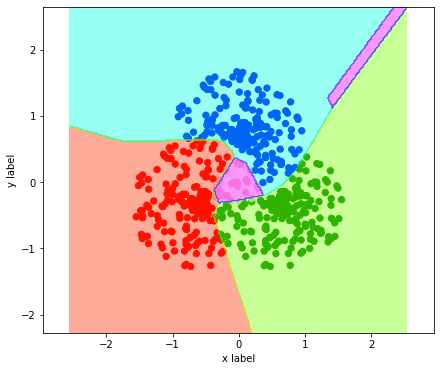

In [93]:
fig, ax = plt.subplots(figsize=(7,6)) 
x_min, x_max = X[:, 0].min(), X[:, 0].max()
y_min, y_max = X[:, 1].min(), X[:, 1].max()
Y = COLOR_LABELS[T]

x_grid, y_grid, predictions = prediction_grid_2d(x_min, x_max, y_min, y_max, prediction)
plot_categorical_predictions(ax, [x_grid, y_grid], X, Y, predictions)

ax.set_xlabel('x label')
ax.set_ylabel('y label')
ax.axis('equal')
ax.grid()

### Plot training error

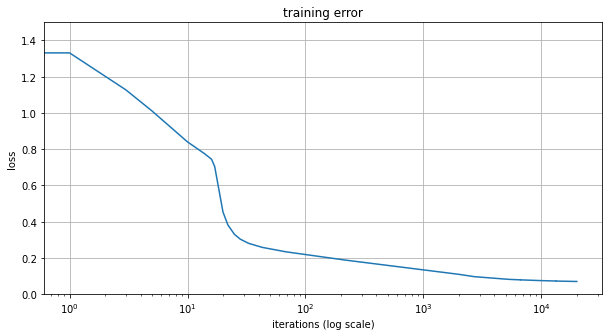

In [95]:
X = range(len(history))
Y = history
xlabel = 'iterations (log scale)'
ylabel = 'loss'
title = "training error"
fig, ax = plot(X, Y, title=title, xlabel=xlabel, ylabel=ylabel,figsize=(10,5))
ax.set_ylim(0.0, 1.5)
ax.set_xscale('log')